<a href="https://colab.research.google.com/github/bsse1009/SPL2-nlp/blob/master/full_model/SPL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
  !cp "drive/My Drive/app/data/magnitude/wiki-news-300d-1M.magnitude" .
  !cp "drive/My Drive/app/data/magnitude/glove_medium_glove.6B.50d.magnitude.tmp" .
  !cp "drive/My Drive/app/layers/highway_layer.py" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.answer" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.context" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.question" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.span" .
  # !cp "drive/My Drive/app/data/preproccess_squad/train_3.answer" .
  !cp "drive/My Drive/app/data/preproccess_squad/train_14.context" .
  !cp "drive/My Drive/app/data/preproccess_squad/train_14.question" .
  !cp "drive/My Drive/app/data/preproccess_squad/train_14.span" .
  !cp "drive/My Drive/app/data/magnitude/glove-lemmatized.6B.100d.magnitude" .

In [ ]:
!pip install --upgrade pip
!pip install --upgrade wheel
!pip install --upgrade build
!pip install pymagnitude

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, TimeDistributed, LSTM, Bidirectional, Concatenate, Lambda, Reshape, Add, Activation, Multiply, Dense
from tensorflow.keras.models import Model, load_model
from keras.layers.advanced_activations import Softmax
import tensorflow.keras.backend as K
import tensorflow.keras as keras
import numpy as np
from tqdm import tqdm
from highway_layer import Highway
import os
from pymagnitude import Magnitude, MagnitudeUtils

In [ ]:
class SimilarityMatrix(Layer):
  def __init__(self, **kwargs):
    super(SimilarityMatrix, self).__init__(**kwargs)
  
  def build(self, input_shape):
    self.context_shape = input_shape[0]
    self.question_shape = input_shape[1]

    self.kernel = self.add_weight(name="kernel",
                                  shape=(3 * input_shape[0][2], 1),
                                  initializer='uniform',
                                  trainable=True)

    super(SimilarityMatrix, self).build(input_shape)

  def calculate_similarity(self, context_vectors, query_vectors):

    element_wise_multiply = context_vectors * query_vectors
    concatenated_tensor = tf.concat(
    [context_vectors, query_vectors, element_wise_multiply], axis=-1)
    similarity = K.squeeze(K.dot(concatenated_tensor, self.kernel), axis=-1)

    return similarity

  def build_similarity_matrix(self, context, question):
    num_context_words = K.shape(context)[1]
    num_query_words = K.shape(question)[1]
    context_dim_repeat = K.concatenate([[1, 1], [num_query_words], [1]], 0)
    query_dim_repeat = K.concatenate([[1], [num_context_words], [1, 1]], 0)
    context_vectors = K.tile(K.expand_dims(context, axis=2), context_dim_repeat)
    query_vectors = K.tile(K.expand_dims(question, axis=1), query_dim_repeat)
    similarity_matrix = self.calculate_similarity(context_vectors, query_vectors)
    return similarity_matrix

  def call(self, x):
    context, question = x
    self.similarity_matrix = self.build_similarity_matrix(context, question)
    return self.similarity_matrix
  
  def compute_output_shape(self, input_shape):
    return (input_shape[0][0],input_shape[0][1],input_shape[1][1])

In [ ]:
class C2Q_Layer(Layer):
  def __init__(self, **kwargs):
    super(C2Q_Layer, self).__init__(**kwargs)

  def build(self, input_shape):
    super(C2Q_Layer, self).build(input_shape)

  def call(self,x):
    similarity_matrix, question=x
    attention = tf.nn.softmax(similarity_matrix)

    self.U_A=K.sum(K.dot(attention,question),-2)

    return self.U_A

  def compute_output_shape(self, input_shape):
    return self.U_A.shape;

In [ ]:
class Q2C_Layer(Layer):
  def __init__(self, **kwargs):
    super(Q2C_Layer, self).__init__(**kwargs)

  def build(self, input_shape):
    super(Q2C_Layer, self).build(input_shape)

  def call(self,x):
    similarity_matrix, context=x
    attention = tf.nn.softmax(K.max(similarity_matrix,axis=-1))

    temp=K.expand_dims(K.sum(K.dot(attention,context),-2),1)

    H_A=K.tile(temp,[1,similarity_matrix.shape[1],1])

    return H_A
  
  def compute_output_shape(self, input_shape):
    return self.H_A.shape;

In [ ]:
class MegaMerge(Layer):
  def __init__(self, **kwargs):
    super(MegaMerge, self).__init__(**kwargs)

  def build(self, input_shape):
    super(MegaMerge, self).build(input_shape)

  def call(self,x):
    context,c2q,q2c=x
    self.G=K.concatenate([context,c2q,context*c2q,context*q2c],axis=-1)

    return self.G;

  def compute_output_shape(self, input_shape):
    return self.G.shape;

In [ ]:
class ModellingLayer(Layer):
    def __init__(self,**kwargs):
        super(ModellingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape=input_shape
  
        self.lstm1 = Bidirectional(LSTM(int(input_shape[2]//8),
                                   activation='tanh',
                                   input_shape=(input_shape[1],input_shape[2]),
                                   return_sequences=True, trainable=True))
        self.lstm2 = Bidirectional(LSTM(int(input_shape[2]//8),
                                   activation='tanh',
                                   input_shape=(input_shape[1], int(input_shape[2]//4)),
                                   return_sequences=True, trainable=True))
        super(ModellingLayer, self).build(input_shape)

    def call(self, x):
        
        self.M1=self.lstm1(x)
        
        self.M2=self.lstm2(self.M1)
        
        self.temp1=tf.concat([x, self.M1], -1)
        self.temp2=tf.concat([x, self.M2], -1)
        
        return self.temp1,self.temp2

    def compute_output_shape(self, input_shape):
        return self.temp1.shape,self.temp2.shape

In [ ]:
class OutputLayer(Layer):
    def __init__(self,**kwargs):
        super(OutputLayer, self).__init__(**kwargs)

    def build(self,input_shape):
  
        self.w1=self.add_weight(name="w1",
                                shape=(input_shape[0][2],),
                                initializer='uniform',
                                trainable=True)
        self.w2=self.add_weight(name="w2",
                                shape=(input_shape[0][2],),
                                initializer='uniform',
                                trainable=True)

        super(OutputLayer, self).build(input_shape)

    def call(self, x):

        answer_span1=tf.tensordot(x[0],tf.transpose(self.w1),1)
        answer_span2=tf.tensordot(x[1], tf.transpose(self.w2), 1)
        
        self.p1=tf.nn.softmax(answer_span1)
        self.p2=tf.nn.softmax(answer_span2)
        
        
        return self.p1,self.p2

    def compute_output_shape(self, input_shape):
        return self.p1.shape,self.p2.shape


In [ ]:
class Vectors():
    def __init__(self):
        glove = Magnitude("glove-lemmatized.6B.100d.magnitude")
        fasttext = Magnitude("wiki-news-300d-1M.magnitude")
        self.vectors = Magnitude(glove,fasttext)

    def load_vectors(self):
        return self.vectors


In [ ]:
from keras.callbacks import *
class BiDAF():

    def __init__(self, vector_dimension, max_context_length=None, max_query_length=None):
        self.vector_dimension = vector_dimension
        self.max_context_length = max_context_length
        self.max_query_length = max_query_length
        with tf.device('/device:GPU:0'):
            passage_input = Input(shape=(self.max_context_length, vector_dimension), dtype='float32', name="passage_input")
            question_input = Input(shape=(self.max_query_length, vector_dimension), dtype='float32', name="question_input")

            highway_layers = Highway(name='highway_layer')
            query_embedding = highway_layers(question_input)
            context_embedding = highway_layers(passage_input)

            contextual_embedding = Bidirectional(LSTM(vector_dimension, activation="tanh", recurrent_activation="sigmoid",
                                                return_sequences=True), name='bidirectional_encoder')
            contextual_embedded_query = contextual_embedding(query_embedding)
            contextual_embedded_context = contextual_embedding(context_embedding)

            similarity_matrix = SimilarityMatrix(name="sm")([contextual_embedded_context, contextual_embedded_query])
            c2q = C2Q_Layer(name="c2q")([similarity_matrix, contextual_embedded_query])
            q2c = Q2C_Layer(name="q2c")([similarity_matrix, contextual_embedded_context])
            megamerge = MegaMerge(name="mega")([contextual_embedded_context, c2q, q2c])
            t1, t2 = ModellingLayer(name="modelling")(megamerge)
            p1, p2 = OutputLayer(name="output")([t1, t2])

            model = Model(inputs=[passage_input, question_input], outputs=[p1, p2])
            model.summary()
            model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
            # for i, w in enumerate(model.weights): print(i, w.name)
            self.model = model

    def predict(self, c, q):
        p1, p2 = self.model.predict(x={"passage_input": c, "question_input": q}, batch_size=1)
        return p1, p2

    def train_model(self, x1, x2, y1, y2, epochs=1):
        with tf.device('/device:GPU:0'):
            filepath="drive/My Drive/app/bidaf_{epoch:03d}.h5"
            checkpoint = ModelCheckpoint(filepath, verbose=1)
            callbacks_list = [checkpoint]
            history = self.model.fit(x={"passage_input": x1, "question_input": x2}, y={"output": y1, "output_1": y2},
                                     batch_size=10,
                                     epochs=epochs, verbose=2,
                                     callbacks=callbacks_list)
            self.model.save('drive/My Drive/app/bidaf250_31.h5')
            return history, self.model

    def load_bidaf(self, path):
      custom_objects = {
          "Highway": Highway,
          "SimilarityMatrix": SimilarityMatrix,
          "C2Q_Layer": C2Q_Layer,
          "Q2C_Layer": Q2C_Layer,
          "MegaMerge": MegaMerge,
          "ModellingLayer": ModellingLayer,
          "OutputLayer": OutputLayer
      }

      self.model = load_model(path, custom_objects=custom_objects)

In [13]:
    with tf.device('/device:GPU:0'):
        context_data = []
        question_data = []
        output_data1 = []
        output_data2 = []
        i = 0
        sample_size = 4174
        vectors = Vectors().load_vectors()
        with open("train_14.context", 'r', encoding='utf8') as context_file, \
                open("train_14.question", 'r', encoding='utf8') as question_file, \
                open("train_14.span", 'r', encoding='utf8') as span_file:

            for context, question, span in zip(tqdm(context_file, total=sample_size),
                                               tqdm(question_file, total=sample_size),
                                               tqdm(span_file, total=sample_size)):

                context = [context]
                question = [question]
                passage = [pas.strip() for pas in context]
                cont = []
                for pas in passage:
                    context_tokens = pas.split(" ")
                    cont.append(context_tokens)
                original_passage = [pas.lower() for pas in passage]
                quest = []
                for ques in question:
                    question_tokens = ques.split(" ")
                    quest.append(question_tokens)
                context_batch = vectors.query(cont)
                question_batch = vectors.query(quest)
                pad1 = np.zeros(shape=(1, 250 - len(cont[0]), 400))
                context_batch = np.concatenate((context_batch, pad1), 1)

                pad2 = np.zeros(shape=(1, 20 - len(quest[0]), 400))
                question_batch = np.concatenate((question_batch, pad2), 1)
                answer_span = span.split()
                output1 = np.zeros(shape=(1, 250), dtype=float)
                output2 = np.zeros(shape=(1, 250), dtype=float)
                output1[0][int(answer_span[0])] = 1
                output2[0][int(answer_span[1])] = 1
                # context_batch = tf.convert_to_tensor(context_batch, tf.float32)
                # question_batch = tf.convert_to_tensor(question_batch, tf.float32)
                # output1 = tf.convert_to_tensor(output1, tf.float32)
                # output2 = tf.convert_to_tensor(output2, tf.float32)

                context_data.append(context_batch)
                question_data.append(question_batch)
                output_data1.append(output1)
                output_data2.append(output2)
                # bidef.train_model(context_batch, question_batch, output, 5)
                i = i + 1
                if i == sample_size:
                    break
                print(i)

        context_data = np.array(context_data)
        context_data = np.reshape(context_data, (sample_size, 250, 400))
        question_data = np.array(question_data)
        question_data = np.reshape(question_data, (sample_size, 20, 400))
        output_data1 = np.array(output_data1)
        output_data1 = np.reshape(output_data1, (sample_size, 250))
        output_data2 = np.array(output_data2)
        output_data2 = np.reshape(output_data2, (sample_size, 250))

  0%|          | 0/4174 [00:00<?, ?it/s]

  0%|          | 1/4174 [00:00<09:54,  7.02it/s]

  0%|          | 3/4174 [00:00<06:38, 10.47it/s]

  0%|          | 3/4174 [00:00<06:36, 10.52it/s]

1
2
3


  0%|          | 5/4174 [00:00<07:04,  9.83it/s]

  0%|          | 5/4174 [00:00<07:05,  9.80it/s]

4
5
6


  0%|          | 7/4174 [00:00<07:17,  9.53it/s]

  0%|          | 7/4174 [00:00<07:17,  9.52it/s]

7


  0%|          | 8/4174 [00:00<09:46,  7.10it/s]

  0%|          | 8/4174 [00:00<09:49,  7.07it/s]

8


  0%|          | 9/4174 [00:01<12:37,  5.50it/s]

  0%|          | 10/4174 [00:01<11:15,  6.17it/s]

  0%|          | 10/4174 [00:01<11:08,  6.23it/s]

9
10


  0%|          | 11/4174 [00:01<11:09,  6.22it/s]

  0%|          | 12/4174 [00:01<10:28,  6.62it/s]

  0%|          | 12/4174 [00:01<10:27,  6.63it/s]

11
12


  0%|          | 13/4174 [00:01<09:46,  7.09it/s]

  0%|          | 13/4174 [00:01<09:48,  7.07it/s]

13
14


  0%|          | 15/4174 [00:02<09:54,  6.99it/s]

  0%|          | 16/4174 [00:02<09:24,  7.37it/s]

  0%|          | 16/4174 [00:02<09:19,  7.43it/s]

15
16


  0%|          | 17/4174 [00:02<09:15,  7.48it/s]

  0%|          | 18/4174 [00:02<09:15,  7.48it/s]

  0%|          | 18/4174 [00:02<09:14,  7.49it/s]

17
18


  0%|          | 19/4174 [00:02<09:03,  7.64it/s]

  0%|          | 20/4174 [00:02<10:15,  6.75it/s]

  0%|          | 20/4174 [00:02<10:13,  6.77it/s]

19
20


  1%|          | 21/4174 [00:02<11:02,  6.27it/s]

  1%|          | 21/4174 [00:02<11:08,  6.21it/s]

21
22


  1%|          | 23/4174 [00:03<09:15,  7.47it/s]

  1%|          | 24/4174 [00:03<10:05,  6.85it/s]

23
24




  1%|          | 25/4174 [00:03<09:38,  7.18it/s]

  1%|          | 26/4174 [00:03<09:32,  7.24it/s]

  1%|          | 26/4174 [00:03<09:32,  7.25it/s]

25
26


  1%|          | 27/4174 [00:03<09:30,  7.27it/s]

  1%|          | 28/4174 [00:03<09:40,  7.15it/s]

  1%|          | 28/4174 [00:03<09:40,  7.14it/s]

27
28


  1%|          | 29/4174 [00:04<09:23,  7.36it/s]

  1%|          | 30/4174 [00:04<09:11,  7.52it/s]

  1%|          | 30/4174 [00:04<09:12,  7.50it/s]

29
30
31


  1%|          | 32/4174 [00:04<09:51,  7.01it/s]

  1%|          | 33/4174 [00:04<10:09,  6.79it/s]

  1%|          | 33/4174 [00:04<10:09,  6.79it/s]

32
33


  1%|          | 34/4174 [00:04<09:38,  7.16it/s]

  1%|          | 35/4174 [00:04<10:02,  6.87it/s]

  1%|          | 35/4174 [00:04<10:07,  6.81it/s]

34
35


  1%|          | 36/4174 [00:05<09:40,  7.13it/s]

  1%|          | 37/4174 [00:05<09:40,  7.13it/s]

  1%|          | 37/4174 [00:05<09:41,  7.12it/s]

36
37


  1%|          | 38/4174 [00:05<10:25,  6.61it/s]

  1%|          | 39/4174 [00:05<10:05,  6.83it/s]

  1%|          | 39/4174 [00:05<10:17,  6.69it/s]

38
39


  1%|          | 40/4174 [00:05<10:09,  6.78it/s]

  1%|          | 41/4174 [00:05<09:29,  7.26it/s]

  1%|          | 41/4174 [00:05<09:29,  7.25it/s]

40
41


  1%|          | 42/4174 [00:05<09:33,  7.20it/s]

  1%|          | 43/4174 [00:05<08:50,  7.79it/s]

  1%|          | 43/4174 [00:05<08:44,  7.88it/s]

42
43


  1%|          | 44/4174 [00:06<08:50,  7.79it/s]

  1%|          | 45/4174 [00:06<10:00,  6.88it/s]

  1%|          | 45/4174 [00:06<09:59,  6.89it/s]

44
45


  1%|          | 46/4174 [00:06<09:51,  6.98it/s]

  1%|          | 47/4174 [00:06<09:50,  6.99it/s]

  1%|          | 47/4174 [00:06<09:45,  7.04it/s]

46
47


  1%|          | 48/4174 [00:06<10:06,  6.80it/s]

  1%|          | 49/4174 [00:06<09:53,  6.95it/s]

  1%|          | 49/4174 [00:06<09:54,  6.94it/s]

48
49


  1%|          | 50/4174 [00:07<09:51,  6.97it/s]

  1%|          | 51/4174 [00:07<10:11,  6.75it/s]

  1%|          | 51/4174 [00:07<10:16,  6.68it/s]

50
51


  1%|          | 52/4174 [00:07<09:39,  7.11it/s]

  1%|▏         | 53/4174 [00:07<09:38,  7.12it/s]

  1%|▏         | 53/4174 [00:07<09:38,  7.12it/s]

52
53


  1%|▏         | 54/4174 [00:07<10:55,  6.29it/s]

  1%|▏         | 55/4174 [00:07<10:12,  6.72it/s]

  1%|▏         | 55/4174 [00:07<10:13,  6.71it/s]

54
55


  1%|▏         | 56/4174 [00:07<09:18,  7.38it/s]

  1%|▏         | 57/4174 [00:07<08:46,  7.81it/s]

  1%|▏         | 57/4174 [00:07<08:44,  7.84it/s]

56
57
58


  1%|▏         | 59/4174 [00:08<07:21,  9.32it/s]

  1%|▏         | 60/4174 [00:08<07:37,  9.00it/s]

  1%|▏         | 60/4174 [00:08<07:36,  9.02it/s]

59
60


  1%|▏         | 61/4174 [00:08<08:11,  8.37it/s]

  1%|▏         | 62/4174 [00:08<08:38,  7.92it/s]

  1%|▏         | 62/4174 [00:08<08:38,  7.92it/s]

61
62


  2%|▏         | 63/4174 [00:08<09:11,  7.46it/s]

  2%|▏         | 65/4174 [00:08<07:28,  9.16it/s]

  2%|▏         | 65/4174 [00:08<07:25,  9.22it/s]

63
64
65


  2%|▏         | 66/4174 [00:08<07:40,  8.92it/s]

  2%|▏         | 67/4174 [00:09<08:59,  7.61it/s]

66
67




  2%|▏         | 68/4174 [00:09<08:37,  7.93it/s]

  2%|▏         | 68/4174 [00:09<08:32,  8.01it/s]

68


  2%|▏         | 69/4174 [00:09<10:06,  6.76it/s]

  2%|▏         | 69/4174 [00:09<10:07,  6.76it/s]

69


  2%|▏         | 70/4174 [00:09<11:15,  6.07it/s]

  2%|▏         | 71/4174 [00:09<10:16,  6.66it/s]

  2%|▏         | 71/4174 [00:09<10:17,  6.65it/s]

70
71
72


  2%|▏         | 73/4174 [00:09<07:52,  8.68it/s]

  2%|▏         | 74/4174 [00:10<08:32,  8.00it/s]

  2%|▏         | 74/4174 [00:10<08:29,  8.05it/s]

73
74


  2%|▏         | 75/4174 [00:10<09:47,  6.98it/s]

  2%|▏         | 75/4174 [00:10<09:48,  6.96it/s]

75


  2%|▏         | 76/4174 [00:10<15:38,  4.37it/s]

  2%|▏         | 77/4174 [00:10<14:40,  4.66it/s]

  2%|▏         | 77/4174 [00:10<14:41,  4.65it/s]

76
77


  2%|▏         | 79/4174 [00:11<10:09,  6.72it/s]

  2%|▏         | 80/4174 [00:11<09:49,  6.95it/s]

78
79
80




  2%|▏         | 81/4174 [00:11<09:22,  7.27it/s]

  2%|▏         | 81/4174 [00:11<09:24,  7.25it/s]

81
82


  2%|▏         | 83/4174 [00:11<08:46,  7.77it/s]

  2%|▏         | 84/4174 [00:11<08:35,  7.93it/s]

  2%|▏         | 84/4174 [00:11<08:38,  7.89it/s]

83
84


  2%|▏         | 86/4174 [00:11<08:54,  7.65it/s]

  2%|▏         | 86/4174 [00:11<08:54,  7.65it/s]

85
86


  2%|▏         | 87/4174 [00:12<09:32,  7.13it/s]

  2%|▏         | 88/4174 [00:12<09:54,  6.87it/s]

  2%|▏         | 88/4174 [00:12<09:56,  6.85it/s]

87
88


  2%|▏         | 89/4174 [00:12<09:31,  7.15it/s]

  2%|▏         | 90/4174 [00:12<09:18,  7.32it/s]

  2%|▏         | 90/4174 [00:12<09:17,  7.33it/s]

89
90


  2%|▏         | 91/4174 [00:12<09:59,  6.81it/s]

  2%|▏         | 92/4174 [00:12<09:14,  7.37it/s]

  2%|▏         | 92/4174 [00:12<09:11,  7.40it/s]

91
92


  2%|▏         | 93/4174 [00:12<09:42,  7.01it/s]

  2%|▏         | 94/4174 [00:13<09:11,  7.40it/s]

  2%|▏         | 94/4174 [00:13<09:06,  7.47it/s]

93
94


  2%|▏         | 95/4174 [00:13<09:08,  7.44it/s]

  2%|▏         | 96/4174 [00:13<10:09,  6.69it/s]



95
96


  2%|▏         | 98/4174 [00:13<08:25,  8.06it/s]

  2%|▏         | 98/4174 [00:13<08:24,  8.08it/s]

97
98


  2%|▏         | 99/4174 [00:13<09:41,  7.00it/s]

  2%|▏         | 100/4174 [00:13<09:12,  7.37it/s]

  2%|▏         | 100/4174 [00:13<09:22,  7.24it/s]

99
100


  2%|▏         | 101/4174 [00:14<10:49,  6.27it/s]

  2%|▏         | 101/4174 [00:14<10:47,  6.29it/s]

101


  2%|▏         | 102/4174 [00:14<11:54,  5.70it/s]

  2%|▏         | 103/4174 [00:14<10:41,  6.34it/s]

  2%|▏         | 103/4174 [00:14<10:34,  6.42it/s]

102
103


  2%|▏         | 104/4174 [00:14<11:59,  5.65it/s]

  3%|▎         | 105/4174 [00:14<11:37,  5.84it/s]

  3%|▎         | 105/4174 [00:14<11:32,  5.88it/s]

104
105


  3%|▎         | 106/4174 [00:15<11:33,  5.87it/s]

  3%|▎         | 107/4174 [00:15<10:17,  6.59it/s]

  3%|▎         | 107/4174 [00:15<10:22,  6.53it/s]

106
107


  3%|▎         | 108/4174 [00:15<10:17,  6.58it/s]

  3%|▎         | 109/4174 [00:15<09:35,  7.06it/s]

  3%|▎         | 109/4174 [00:15<09:34,  7.08it/s]

108
109


  3%|▎         | 110/4174 [00:15<09:10,  7.38it/s]

  3%|▎         | 111/4174 [00:15<08:36,  7.86it/s]

  3%|▎         | 111/4174 [00:15<08:33,  7.92it/s]

110
111
112


  3%|▎         | 113/4174 [00:15<07:00,  9.66it/s]

  3%|▎         | 114/4174 [00:15<07:38,  8.86it/s]

  3%|▎         | 114/4174 [00:15<07:38,  8.85it/s]

113
114


  3%|▎         | 116/4174 [00:16<06:03, 11.17it/s]

  3%|▎         | 116/4174 [00:16<06:01, 11.24it/s]

115
116


  3%|▎         | 118/4174 [00:16<07:54,  8.54it/s]

  3%|▎         | 118/4174 [00:16<08:01,  8.43it/s]

117
118


  3%|▎         | 119/4174 [00:16<08:07,  8.33it/s]

  3%|▎         | 121/4174 [00:16<06:44, 10.03it/s]

  3%|▎         | 121/4174 [00:16<06:42, 10.07it/s]

119
120
121


  3%|▎         | 123/4174 [00:16<06:40, 10.13it/s]

  3%|▎         | 123/4174 [00:16<06:40, 10.11it/s]

122
123
124


  3%|▎         | 125/4174 [00:17<06:52,  9.81it/s]

  3%|▎         | 127/4174 [00:17<06:18, 10.69it/s]

  3%|▎         | 127/4174 [00:17<06:17, 10.71it/s]

125
126
127


  3%|▎         | 129/4174 [00:17<06:28, 10.41it/s]

  3%|▎         | 129/4174 [00:17<06:26, 10.47it/s]

128
129


  3%|▎         | 131/4174 [00:17<06:31, 10.34it/s]

  3%|▎         | 131/4174 [00:17<06:31, 10.33it/s]

130
131
132


  3%|▎         | 133/4174 [00:17<06:38, 10.15it/s]

  3%|▎         | 133/4174 [00:17<06:37, 10.16it/s]

133
134


  3%|▎         | 135/4174 [00:18<07:00,  9.61it/s]

  3%|▎         | 136/4174 [00:18<07:20,  9.17it/s]

  3%|▎         | 136/4174 [00:18<07:21,  9.15it/s]

135
136


  3%|▎         | 138/4174 [00:18<06:33, 10.25it/s]

  3%|▎         | 138/4174 [00:18<06:32, 10.28it/s]

137
138
139


  3%|▎         | 140/4174 [00:18<06:41, 10.05it/s]

  3%|▎         | 140/4174 [00:18<06:38, 10.12it/s]

140
141


  3%|▎         | 142/4174 [00:18<07:06,  9.46it/s]

  3%|▎         | 143/4174 [00:18<07:26,  9.04it/s]

  3%|▎         | 143/4174 [00:18<07:24,  9.07it/s]

142
143


  3%|▎         | 144/4174 [00:19<07:41,  8.73it/s]

  3%|▎         | 145/4174 [00:19<07:40,  8.75it/s]

  3%|▎         | 145/4174 [00:19<07:40,  8.75it/s]

144
145
146


  4%|▎         | 147/4174 [00:19<06:46,  9.90it/s]

  4%|▎         | 147/4174 [00:19<06:49,  9.84it/s]

147


  4%|▎         | 148/4174 [00:19<11:24,  5.88it/s]

  4%|▎         | 150/4174 [00:19<09:05,  7.38it/s]

  4%|▎         | 150/4174 [00:19<09:02,  7.41it/s]

148
149
150


  4%|▎         | 151/4174 [00:20<08:58,  7.47it/s]

  4%|▎         | 152/4174 [00:20<09:16,  7.22it/s]

  4%|▎         | 152/4174 [00:20<09:14,  7.25it/s]

151
152


  4%|▎         | 153/4174 [00:20<09:32,  7.02it/s]

  4%|▎         | 155/4174 [00:20<07:43,  8.67it/s]

  4%|▎         | 155/4174 [00:20<07:42,  8.68it/s]

153
154
155


  4%|▍         | 157/4174 [00:20<07:07,  9.40it/s]

  4%|▍         | 157/4174 [00:20<07:07,  9.39it/s]

156
157


  4%|▍         | 158/4174 [00:20<07:52,  8.50it/s]

  4%|▍         | 159/4174 [00:20<07:59,  8.37it/s]

  4%|▍         | 159/4174 [00:20<07:58,  8.39it/s]

158
159


  4%|▍         | 160/4174 [00:21<08:15,  8.10it/s]

  4%|▍         | 161/4174 [00:21<08:58,  7.45it/s]

  4%|▍         | 161/4174 [00:21<09:00,  7.42it/s]

160
161
162


  4%|▍         | 163/4174 [00:21<07:12,  9.28it/s]

  4%|▍         | 164/4174 [00:21<08:11,  8.15it/s]

  4%|▍         | 164/4174 [00:21<08:09,  8.19it/s]

163
164


  4%|▍         | 165/4174 [00:21<07:51,  8.51it/s]

  4%|▍         | 166/4174 [00:21<07:36,  8.77it/s]

  4%|▍         | 166/4174 [00:21<07:40,  8.70it/s]

165
166


  4%|▍         | 167/4174 [00:21<08:46,  7.60it/s]

  4%|▍         | 169/4174 [00:22<07:21,  9.08it/s]

  4%|▍         | 169/4174 [00:22<07:17,  9.15it/s]

167
168
169


  4%|▍         | 170/4174 [00:22<07:35,  8.80it/s]

  4%|▍         | 171/4174 [00:22<08:13,  8.10it/s]

  4%|▍         | 171/4174 [00:22<08:26,  7.91it/s]

170
171


  4%|▍         | 172/4174 [00:22<08:44,  7.63it/s]

  4%|▍         | 173/4174 [00:22<08:20,  7.99it/s]

  4%|▍         | 173/4174 [00:22<08:19,  8.02it/s]

172
173


  4%|▍         | 174/4174 [00:22<08:12,  8.12it/s]

  4%|▍         | 176/4174 [00:22<07:20,  9.07it/s]

174
175
176




  4%|▍         | 178/4174 [00:23<07:02,  9.46it/s]

  4%|▍         | 178/4174 [00:23<07:02,  9.46it/s]

177
178


  4%|▍         | 179/4174 [00:23<07:13,  9.22it/s]

  4%|▍         | 181/4174 [00:23<06:04, 10.97it/s]

  4%|▍         | 181/4174 [00:23<06:04, 10.95it/s]

179
180
181


  4%|▍         | 183/4174 [00:23<05:32, 12.02it/s]

  4%|▍         | 183/4174 [00:23<05:31, 12.05it/s]

182
183


  4%|▍         | 185/4174 [00:23<06:38, 10.00it/s]

  4%|▍         | 185/4174 [00:23<06:36, 10.06it/s]

184
185


  4%|▍         | 187/4174 [00:24<07:21,  9.03it/s]

  4%|▍         | 187/4174 [00:24<07:21,  9.02it/s]

186
187


  5%|▍         | 188/4174 [00:24<07:28,  8.88it/s]

  5%|▍         | 189/4174 [00:24<07:54,  8.41it/s]

  5%|▍         | 189/4174 [00:24<07:56,  8.37it/s]

188
189


  5%|▍         | 190/4174 [00:24<07:59,  8.30it/s]

  5%|▍         | 192/4174 [00:24<07:08,  9.30it/s]

  5%|▍         | 192/4174 [00:24<07:11,  9.24it/s]

190
191
192


  5%|▍         | 194/4174 [00:24<06:40,  9.93it/s]

  5%|▍         | 194/4174 [00:24<06:40,  9.95it/s]

193
194


  5%|▍         | 195/4174 [00:24<07:04,  9.38it/s]

  5%|▍         | 195/4174 [00:24<07:07,  9.31it/s]

195


  5%|▍         | 196/4174 [00:25<08:47,  7.55it/s]

  5%|▍         | 197/4174 [00:25<09:32,  6.95it/s]

  5%|▍         | 197/4174 [00:25<09:27,  7.01it/s]

196
197


  5%|▍         | 198/4174 [00:25<10:37,  6.24it/s]

  5%|▍         | 199/4174 [00:25<10:32,  6.29it/s]

  5%|▍         | 199/4174 [00:25<10:29,  6.32it/s]

198
199


  5%|▍         | 200/4174 [00:25<10:00,  6.62it/s]

  5%|▍         | 201/4174 [00:25<09:06,  7.27it/s]

  5%|▍         | 201/4174 [00:25<09:01,  7.34it/s]

200
201
202


  5%|▍         | 203/4174 [00:26<10:28,  6.32it/s]

  5%|▍         | 204/4174 [00:26<10:15,  6.45it/s]

  5%|▍         | 204/4174 [00:26<10:13,  6.47it/s]

203
204


  5%|▍         | 205/4174 [00:26<09:28,  6.98it/s]

  5%|▍         | 206/4174 [00:26<09:48,  6.74it/s]

  5%|▍         | 206/4174 [00:26<09:52,  6.69it/s]

205
206


  5%|▍         | 207/4174 [00:26<09:06,  7.26it/s]

  5%|▍         | 207/4174 [00:26<09:10,  7.21it/s]

207


  5%|▍         | 208/4174 [00:27<11:25,  5.79it/s]

  5%|▌         | 209/4174 [00:27<10:34,  6.25it/s]

  5%|▌         | 209/4174 [00:27<10:41,  6.18it/s]

208
209


  5%|▌         | 210/4174 [00:27<10:13,  6.46it/s]

  5%|▌         | 212/4174 [00:27<08:02,  8.21it/s]

  5%|▌         | 212/4174 [00:27<07:57,  8.30it/s]

210
211
212


  5%|▌         | 213/4174 [00:27<07:48,  8.46it/s]

  5%|▌         | 214/4174 [00:27<07:41,  8.58it/s]

  5%|▌         | 214/4174 [00:27<07:44,  8.52it/s]

213
214


  5%|▌         | 215/4174 [00:27<07:27,  8.85it/s]

  5%|▌         | 215/4174 [00:27<07:31,  8.78it/s]

215


  5%|▌         | 216/4174 [00:28<11:46,  5.60it/s]

  5%|▌         | 217/4174 [00:28<11:24,  5.78it/s]

  5%|▌         | 217/4174 [00:28<11:19,  5.82it/s]

216
217


  5%|▌         | 218/4174 [00:28<10:11,  6.47it/s]

  5%|▌         | 219/4174 [00:28<09:53,  6.67it/s]

  5%|▌         | 219/4174 [00:28<10:00,  6.58it/s]

218
219


  5%|▌         | 220/4174 [00:28<09:34,  6.89it/s]

  5%|▌         | 222/4174 [00:28<07:29,  8.80it/s]

  5%|▌         | 222/4174 [00:28<07:39,  8.60it/s]

220
221
222


  5%|▌         | 223/4174 [00:29<07:47,  8.46it/s]

  5%|▌         | 225/4174 [00:29<06:01, 10.94it/s]

  5%|▌         | 225/4174 [00:29<06:02, 10.90it/s]

223
224
225


  5%|▌         | 227/4174 [00:29<05:19, 12.34it/s]

  5%|▌         | 229/4174 [00:29<04:43, 13.93it/s]

  5%|▌         | 229/4174 [00:29<04:38, 14.15it/s]

226
227
228
229


  6%|▌         | 231/4174 [00:29<05:26, 12.07it/s]

  6%|▌         | 231/4174 [00:29<05:28, 12.00it/s]

230
231
232


  6%|▌         | 233/4174 [00:29<05:52, 11.19it/s]

  6%|▌         | 235/4174 [00:29<05:24, 12.13it/s]

  6%|▌         | 235/4174 [00:29<05:20, 12.30it/s]

233
234
235


  6%|▌         | 237/4174 [00:30<06:07, 10.72it/s]

  6%|▌         | 237/4174 [00:30<06:09, 10.66it/s]

236
237
238


  6%|▌         | 239/4174 [00:30<05:50, 11.24it/s]

  6%|▌         | 239/4174 [00:30<05:52, 11.17it/s]

239
240


  6%|▌         | 241/4174 [00:30<06:06, 10.74it/s]

  6%|▌         | 241/4174 [00:30<06:09, 10.65it/s]

241
242


  6%|▌         | 243/4174 [00:30<06:28, 10.13it/s]

  6%|▌         | 245/4174 [00:30<05:47, 11.30it/s]

  6%|▌         | 245/4174 [00:30<05:47, 11.29it/s]

243
244
245


  6%|▌         | 247/4174 [00:31<06:02, 10.83it/s]

  6%|▌         | 247/4174 [00:31<06:03, 10.82it/s]

246
247
248


  6%|▌         | 249/4174 [00:31<05:51, 11.17it/s]

  6%|▌         | 251/4174 [00:31<05:57, 10.98it/s]

  6%|▌         | 251/4174 [00:31<05:52, 11.13it/s]

249
250
251


  6%|▌         | 253/4174 [00:31<06:16, 10.41it/s]

  6%|▌         | 253/4174 [00:31<06:16, 10.40it/s]

252
253
254


  6%|▌         | 255/4174 [00:31<06:25, 10.16it/s]

  6%|▌         | 255/4174 [00:31<06:27, 10.12it/s]

255
256


  6%|▌         | 257/4174 [00:32<07:03,  9.25it/s]

  6%|▌         | 259/4174 [00:32<06:31, 10.01it/s]

  6%|▌         | 259/4174 [00:32<06:29, 10.06it/s]

257
258
259


  6%|▋         | 261/4174 [00:32<06:20, 10.29it/s]

  6%|▋         | 262/4174 [00:32<05:43, 11.38it/s]

260
261
262



  6%|▋         | 263/4174 [00:32<05:49, 11.18it/s]

  6%|▋         | 265/4174 [00:32<05:21, 12.14it/s]

  6%|▋         | 265/4174 [00:32<05:21, 12.15it/s]

263
264
265


  6%|▋         | 267/4174 [00:32<05:17, 12.32it/s]

  6%|▋         | 268/4174 [00:32<05:18, 12.26it/s]

266
267
268



  6%|▋         | 269/4174 [00:33<05:23, 12.07it/s]

  6%|▋         | 271/4174 [00:33<05:03, 12.86it/s]

  7%|▋         | 273/4174 [00:33<04:12, 15.44it/s]

269
270
271
272
273



  7%|▋         | 274/4174 [00:33<05:26, 11.96it/s]

  7%|▋         | 275/4174 [00:33<06:42,  9.68it/s]

274
275



  7%|▋         | 276/4174 [00:33<06:30,  9.99it/s]

  7%|▋         | 278/4174 [00:33<06:27, 10.04it/s]

276
277
278




  7%|▋         | 280/4174 [00:34<06:02, 10.75it/s]

  7%|▋         | 281/4174 [00:34<06:09, 10.54it/s]

279
280
281



  7%|▋         | 282/4174 [00:34<06:04, 10.68it/s]

  7%|▋         | 283/4174 [00:34<06:07, 10.58it/s]

282
283



  7%|▋         | 284/4174 [00:34<06:13, 10.42it/s]

  7%|▋         | 286/4174 [00:34<06:12, 10.43it/s]

  7%|▋         | 286/4174 [00:34<06:12, 10.45it/s]

284
285
286


  7%|▋         | 288/4174 [00:34<06:35,  9.83it/s]

  7%|▋         | 288/4174 [00:34<06:40,  9.70it/s]

287
288


  7%|▋         | 289/4174 [00:35<07:13,  8.95it/s]

  7%|▋         | 290/4174 [00:35<07:07,  9.08it/s]

289
290


  7%|▋         | 291/4174 [00:35<07:29,  8.63it/s]

  7%|▋         | 292/4174 [00:35<07:59,  8.10it/s]

  7%|▋         | 292/4174 [00:35<07:57,  8.13it/s]

291
292


  7%|▋         | 293/4174 [00:35<07:43,  8.37it/s]

  7%|▋         | 294/4174 [00:35<08:12,  7.87it/s]

  7%|▋         | 294/4174 [00:35<08:04,  8.00it/s]

293
294


  7%|▋         | 295/4174 [00:35<08:15,  7.83it/s]

  7%|▋         | 297/4174 [00:36<07:13,  8.95it/s]

  7%|▋         | 297/4174 [00:36<07:12,  8.95it/s]

295
296
297


  7%|▋         | 299/4174 [00:36<06:27, 10.01it/s]

  7%|▋         | 299/4174 [00:36<06:24, 10.09it/s]

298
299
300


  7%|▋         | 301/4174 [00:36<06:15, 10.31it/s]

  7%|▋         | 301/4174 [00:36<06:13, 10.36it/s]

301


  7%|▋         | 303/4174 [00:36<07:59,  8.08it/s]

  7%|▋         | 303/4174 [00:36<07:58,  8.09it/s]

302
303


  7%|▋         | 304/4174 [00:36<08:36,  7.49it/s]

  7%|▋         | 306/4174 [00:37<07:23,  8.72it/s]

  7%|▋         | 306/4174 [00:37<07:31,  8.58it/s]

304
305
306


  7%|▋         | 308/4174 [00:37<06:14, 10.32it/s]

  7%|▋         | 308/4174 [00:37<06:14, 10.31it/s]

307
308
309


  7%|▋         | 310/4174 [00:37<06:14, 10.31it/s]

  7%|▋         | 310/4174 [00:37<06:16, 10.26it/s]

310


  7%|▋         | 312/4174 [00:37<07:23,  8.71it/s]

  8%|▊         | 314/4174 [00:37<06:26,  9.98it/s]

311
312
313
314




  8%|▊         | 316/4174 [00:38<07:07,  9.03it/s]

  8%|▊         | 316/4174 [00:38<07:07,  9.03it/s]

315
316


  8%|▊         | 318/4174 [00:38<06:27,  9.95it/s]

  8%|▊         | 318/4174 [00:38<06:29,  9.90it/s]

317
318


  8%|▊         | 320/4174 [00:38<06:08, 10.47it/s]

  8%|▊         | 322/4174 [00:38<05:39, 11.35it/s]

  8%|▊         | 322/4174 [00:38<05:38, 11.39it/s]

319
320
321
322


  8%|▊         | 324/4174 [00:38<06:05, 10.55it/s]

  8%|▊         | 324/4174 [00:38<06:04, 10.55it/s]

323
324
325


  8%|▊         | 326/4174 [00:38<05:42, 11.25it/s]

  8%|▊         | 326/4174 [00:38<05:41, 11.26it/s]

326
327


  8%|▊         | 328/4174 [00:39<05:59, 10.70it/s]

  8%|▊         | 330/4174 [00:39<05:14, 12.24it/s]

  8%|▊         | 330/4174 [00:39<05:11, 12.35it/s]

328
329
330
331


  8%|▊         | 332/4174 [00:39<05:04, 12.62it/s]

  8%|▊         | 332/4174 [00:39<05:01, 12.74it/s]

332
333


  8%|▊         | 334/4174 [00:39<05:48, 11.01it/s]

  8%|▊         | 336/4174 [00:39<05:53, 10.86it/s]

334
335
336




  8%|▊         | 338/4174 [00:40<06:18, 10.14it/s]

  8%|▊         | 338/4174 [00:40<06:21, 10.05it/s]

337
338


  8%|▊         | 340/4174 [00:40<06:30,  9.83it/s]

  8%|▊         | 340/4174 [00:40<06:29,  9.84it/s]

339
340
341


  8%|▊         | 342/4174 [00:40<06:30,  9.82it/s]

  8%|▊         | 342/4174 [00:40<06:29,  9.84it/s]

342


  8%|▊         | 344/4174 [00:40<07:30,  8.50it/s]

  8%|▊         | 344/4174 [00:40<07:29,  8.52it/s]

343
344
345


  8%|▊         | 346/4174 [00:40<06:24,  9.94it/s]

  8%|▊         | 348/4174 [00:41<05:37, 11.32it/s]

  8%|▊         | 348/4174 [00:41<05:41, 11.21it/s]

346
347
348


  8%|▊         | 350/4174 [00:41<05:21, 11.88it/s]

  8%|▊         | 350/4174 [00:41<05:24, 11.80it/s]

349
350
351


  8%|▊         | 352/4174 [00:41<05:24, 11.78it/s]

  8%|▊         | 352/4174 [00:41<05:26, 11.71it/s]

352
353


  8%|▊         | 354/4174 [00:41<06:20, 10.04it/s]

  9%|▊         | 356/4174 [00:41<06:15, 10.16it/s]

  9%|▊         | 356/4174 [00:41<06:14, 10.20it/s]

354
355
356


  9%|▊         | 358/4174 [00:41<05:43, 11.11it/s]

  9%|▊         | 358/4174 [00:41<05:41, 11.17it/s]

357
358
359


  9%|▊         | 360/4174 [00:42<05:54, 10.76it/s]

  9%|▊         | 360/4174 [00:42<05:53, 10.78it/s]

360
361


  9%|▊         | 362/4174 [00:42<06:18, 10.07it/s]

  9%|▊         | 362/4174 [00:42<06:22,  9.96it/s]

362
363


  9%|▊         | 364/4174 [00:42<06:36,  9.60it/s]

  9%|▊         | 364/4174 [00:42<06:37,  9.59it/s]

364


  9%|▊         | 365/4174 [00:42<07:55,  8.01it/s]

  9%|▉         | 367/4174 [00:43<07:11,  8.83it/s]

  9%|▉         | 367/4174 [00:43<07:12,  8.81it/s]

365
366
367


  9%|▉         | 368/4174 [00:43<08:03,  7.87it/s]

  9%|▉         | 370/4174 [00:43<07:14,  8.76it/s]

  9%|▉         | 370/4174 [00:43<07:11,  8.82it/s]

368
369
370


  9%|▉         | 371/4174 [00:43<07:08,  8.87it/s]

  9%|▉         | 372/4174 [00:43<07:47,  8.13it/s]

  9%|▉         | 372/4174 [00:43<07:44,  8.19it/s]

371
372


  9%|▉         | 374/4174 [00:43<06:35,  9.61it/s]

  9%|▉         | 375/4174 [00:43<06:55,  9.14it/s]

373
374
375



  9%|▉         | 375/4174 [00:43<06:55,  9.15it/s]

  9%|▉         | 376/4174 [00:44<07:11,  8.79it/s]

  9%|▉         | 377/4174 [00:44<07:11,  8.81it/s]

  9%|▉         | 377/4174 [00:44<07:05,  8.91it/s]

376
377


  9%|▉         | 378/4174 [00:44<07:19,  8.64it/s]

  9%|▉         | 378/4174 [00:44<07:19,  8.63it/s]

378
379


  9%|▉         | 380/4174 [00:44<07:19,  8.62it/s]

  9%|▉         | 381/4174 [00:44<07:43,  8.18it/s]

  9%|▉         | 381/4174 [00:44<07:44,  8.16it/s]

380
381


  9%|▉         | 383/4174 [00:44<06:59,  9.03it/s]

  9%|▉         | 383/4174 [00:44<07:04,  8.92it/s]

382
383


  9%|▉         | 384/4174 [00:44<07:18,  8.65it/s]

  9%|▉         | 385/4174 [00:45<07:57,  7.94it/s]

  9%|▉         | 385/4174 [00:45<07:56,  7.96it/s]

384
385


  9%|▉         | 386/4174 [00:45<07:50,  8.04it/s]

  9%|▉         | 387/4174 [00:45<07:41,  8.21it/s]

  9%|▉         | 387/4174 [00:45<07:42,  8.19it/s]

386
387


  9%|▉         | 389/4174 [00:45<06:35,  9.56it/s]

  9%|▉         | 389/4174 [00:45<06:35,  9.57it/s]

388
389
390


  9%|▉         | 391/4174 [00:45<06:47,  9.29it/s]

  9%|▉         | 392/4174 [00:45<07:04,  8.90it/s]

  9%|▉         | 392/4174 [00:45<07:06,  8.86it/s]

391
392


  9%|▉         | 394/4174 [00:46<06:54,  9.13it/s]

  9%|▉         | 394/4174 [00:46<06:51,  9.18it/s]

393
394


  9%|▉         | 396/4174 [00:46<07:23,  8.52it/s]

  9%|▉         | 396/4174 [00:46<07:21,  8.56it/s]

395
396


 10%|▉         | 398/4174 [00:46<06:30,  9.67it/s]

 10%|▉         | 398/4174 [00:46<06:34,  9.57it/s]

397
398


 10%|▉         | 399/4174 [00:46<07:16,  8.66it/s]

 10%|▉         | 401/4174 [00:46<06:18,  9.96it/s]

 10%|▉         | 401/4174 [00:46<06:24,  9.81it/s]

399
400
401




 10%|▉         | 403/4174 [00:47<07:04,  8.88it/s]

 10%|▉         | 403/4174 [00:47<07:08,  8.80it/s]

402
403


 10%|▉         | 404/4174 [00:47<07:21,  8.54it/s]

 10%|▉         | 405/4174 [00:47<07:34,  8.28it/s]

 10%|▉         | 405/4174 [00:47<07:38,  8.22it/s]

404
405


 10%|▉         | 406/4174 [00:47<07:47,  8.06it/s]

 10%|▉         | 406/4174 [00:47<07:52,  7.98it/s]

406


 10%|▉         | 407/4174 [00:47<10:03,  6.24it/s]

 10%|▉         | 407/4174 [00:47<10:28,  5.99it/s]

407
408


 10%|▉         | 409/4174 [00:48<08:58,  7.00it/s]

 10%|▉         | 410/4174 [00:48<08:54,  7.05it/s]

 10%|▉         | 410/4174 [00:48<08:56,  7.01it/s]

409
410


 10%|▉         | 411/4174 [00:48<08:49,  7.11it/s]

 10%|▉         | 412/4174 [00:48<08:20,  7.52it/s]

 10%|▉         | 412/4174 [00:48<08:30,  7.37it/s]

411
412
413


 10%|▉         | 414/4174 [00:48<07:02,  8.90it/s]

 10%|▉         | 414/4174 [00:48<07:04,  8.86it/s]

414
415


 10%|▉         | 416/4174 [00:48<06:54,  9.07it/s]

 10%|▉         | 417/4174 [00:48<07:05,  8.82it/s]

 10%|▉         | 417/4174 [00:48<07:07,  8.80it/s]

416
417


 10%|█         | 418/4174 [00:49<07:33,  8.27it/s]

 10%|█         | 419/4174 [00:49<07:41,  8.13it/s]

 10%|█         | 419/4174 [00:49<07:42,  8.13it/s]

418
419


 10%|█         | 421/4174 [00:49<06:34,  9.51it/s]

 10%|█         | 421/4174 [00:49<06:36,  9.46it/s]

420
421
422


 10%|█         | 423/4174 [00:49<06:02, 10.36it/s]

 10%|█         | 425/4174 [00:49<05:51, 10.66it/s]

 10%|█         | 425/4174 [00:49<05:54, 10.56it/s]

423
424
425


 10%|█         | 427/4174 [00:49<06:36,  9.44it/s]

 10%|█         | 427/4174 [00:49<06:32,  9.55it/s]

426
427


 10%|█         | 428/4174 [00:50<06:56,  9.00it/s]

 10%|█         | 430/4174 [00:50<05:36, 11.12it/s]

 10%|█         | 431/4174 [00:50<05:29, 11.37it/s]

428
429
430
431


 10%|█         | 432/4174 [00:50<05:41, 10.94it/s]

 10%|█         | 434/4174 [00:50<05:15, 11.85it/s]

432
433
434




 10%|█         | 436/4174 [00:50<05:14, 11.88it/s]

 10%|█         | 437/4174 [00:50<05:07, 12.16it/s]

435
436
437


 10%|█         | 438/4174 [00:50<05:04, 12.25it/s]

 11%|█         | 440/4174 [00:51<05:20, 11.63it/s]

438
439
440




 11%|█         | 442/4174 [00:51<05:11, 11.96it/s]

 11%|█         | 443/4174 [00:51<05:13, 11.90it/s]

441
442
443


 11%|█         | 444/4174 [00:51<05:14, 11.88it/s]

 11%|█         | 446/4174 [00:51<04:52, 12.75it/s]

444
445
446




 11%|█         | 448/4174 [00:51<04:38, 13.37it/s]

 11%|█         | 449/4174 [00:51<04:28, 13.86it/s]

447
448
449


 11%|█         | 450/4174 [00:51<04:54, 12.63it/s]

 11%|█         | 452/4174 [00:51<05:15, 11.80it/s]

450
451
452




 11%|█         | 454/4174 [00:52<05:15, 11.78it/s]

453
454




 11%|█         | 456/4174 [00:52<05:54, 10.49it/s]

455
456




 11%|█         | 458/4174 [00:52<05:54, 10.49it/s]

 11%|█         | 459/4174 [00:52<05:48, 10.65it/s]

457
458
459


 11%|█         | 460/4174 [00:52<06:15,  9.88it/s]

 11%|█         | 462/4174 [00:52<06:02, 10.23it/s]

460
461
462




 11%|█         | 464/4174 [00:53<05:40, 10.91it/s]

 11%|█         | 465/4174 [00:53<05:56, 10.41it/s]

463
464
465


 11%|█         | 466/4174 [00:53<05:42, 10.83it/s]

 11%|█         | 467/4174 [00:53<06:04, 10.16it/s]

466
467


 11%|█         | 468/4174 [00:53<06:10,  9.99it/s]

 11%|█         | 469/4174 [00:53<06:17,  9.82it/s]

468
469


 11%|█▏        | 470/4174 [00:53<06:25,  9.62it/s]

 11%|█▏        | 471/4174 [00:53<06:41,  9.21it/s]

 11%|█▏        | 471/4174 [00:53<06:48,  9.06it/s]

470
471


 11%|█▏        | 472/4174 [00:54<07:04,  8.71it/s]

 11%|█▏        | 473/4174 [00:54<07:15,  8.49it/s]

 11%|█▏        | 473/4174 [00:54<07:26,  8.29it/s]

472
473


 11%|█▏        | 474/4174 [00:54<07:27,  8.28it/s]

 11%|█▏        | 476/4174 [00:54<05:50, 10.55it/s]

 11%|█▏        | 476/4174 [00:54<05:51, 10.52it/s]

474
475
476
477


 11%|█▏        | 478/4174 [00:54<05:33, 11.08it/s]

 11%|█▏        | 480/4174 [00:54<05:28, 11.24it/s]

 11%|█▏        | 480/4174 [00:54<05:29, 11.20it/s]

478
479
480


 12%|█▏        | 482/4174 [00:54<05:20, 11.53it/s]

 12%|█▏        | 482/4174 [00:54<05:15, 11.69it/s]

481
482
483


 12%|█▏        | 484/4174 [00:55<06:57,  8.83it/s]

 12%|█▏        | 485/4174 [00:55<07:13,  8.50it/s]

 12%|█▏        | 485/4174 [00:55<07:14,  8.48it/s]

484
485


 12%|█▏        | 486/4174 [00:55<07:04,  8.69it/s]

 12%|█▏        | 488/4174 [00:55<06:04, 10.12it/s]

 12%|█▏        | 488/4174 [00:55<06:13,  9.88it/s]

486
487
488


 12%|█▏        | 490/4174 [00:55<05:53, 10.44it/s]

 12%|█▏        | 490/4174 [00:55<05:54, 10.38it/s]

489
490
491


 12%|█▏        | 492/4174 [00:56<05:36, 10.94it/s]

 12%|█▏        | 494/4174 [00:56<05:11, 11.82it/s]

 12%|█▏        | 494/4174 [00:56<05:11, 11.82it/s]

492
493
494


 12%|█▏        | 496/4174 [00:56<04:42, 13.04it/s]

 12%|█▏        | 498/4174 [00:56<04:18, 14.24it/s]

 12%|█▏        | 498/4174 [00:56<04:20, 14.12it/s]

495
496
497
498
499


 12%|█▏        | 500/4174 [00:56<05:01, 12.20it/s]

 12%|█▏        | 500/4174 [00:56<05:00, 12.23it/s]

500
501


 12%|█▏        | 502/4174 [00:56<06:03, 10.10it/s]

 12%|█▏        | 502/4174 [00:56<06:03, 10.09it/s]

502
503


 12%|█▏        | 504/4174 [00:57<06:12,  9.87it/s]

 12%|█▏        | 506/4174 [00:57<05:55, 10.32it/s]

 12%|█▏        | 506/4174 [00:57<05:51, 10.45it/s]

504
505
506


 12%|█▏        | 508/4174 [00:57<05:38, 10.84it/s]

 12%|█▏        | 510/4174 [00:57<05:30, 11.08it/s]


507
508
509
510


 12%|█▏        | 510/4174 [00:57<05:30, 11.08it/s]

 12%|█▏        | 512/4174 [00:57<06:01, 10.14it/s]

 12%|█▏        | 512/4174 [00:57<06:05, 10.01it/s]

511
512


 12%|█▏        | 514/4174 [00:58<06:02, 10.08it/s]

 12%|█▏        | 514/4174 [00:58<05:58, 10.20it/s]

513
514
515


 12%|█▏        | 516/4174 [00:58<06:16,  9.71it/s]

 12%|█▏        | 517/4174 [00:58<06:37,  9.21it/s]

 12%|█▏        | 518/4174 [00:58<06:03, 10.07it/s]

516
517
518


 12%|█▏        | 519/4174 [00:58<05:25, 11.22it/s]

 12%|█▏        | 520/4174 [00:58<05:57, 10.22it/s]

519
520


 12%|█▏        | 521/4174 [00:58<05:56, 10.25it/s]

 13%|█▎        | 523/4174 [00:58<05:46, 10.52it/s]

521
522
523




 13%|█▎        | 525/4174 [00:59<08:15,  7.37it/s]

 13%|█▎        | 525/4174 [00:59<08:01,  7.58it/s]

524
525


 13%|█▎        | 526/4174 [00:59<08:08,  7.47it/s]

 13%|█▎        | 527/4174 [00:59<08:00,  7.59it/s]

 13%|█▎        | 527/4174 [00:59<07:56,  7.66it/s]

526
527


 13%|█▎        | 528/4174 [00:59<07:44,  7.86it/s]

 13%|█▎        | 528/4174 [00:59<07:30,  8.10it/s]

528
529


 13%|█▎        | 530/4174 [00:59<07:11,  8.44it/s]

 13%|█▎        | 531/4174 [01:00<06:58,  8.70it/s]

 13%|█▎        | 532/4174 [01:00<06:20,  9.58it/s]

530
531
532


 13%|█▎        | 533/4174 [01:00<06:00, 10.09it/s]

 13%|█▎        | 534/4174 [01:00<06:17,  9.65it/s]

533
534


 13%|█▎        | 535/4174 [01:00<06:22,  9.52it/s]

 13%|█▎        | 536/4174 [01:00<06:21,  9.54it/s]

 13%|█▎        | 536/4174 [01:00<06:26,  9.41it/s]

535
536


 13%|█▎        | 537/4174 [01:00<06:35,  9.19it/s]

 13%|█▎        | 538/4174 [01:00<07:45,  7.82it/s]

 13%|█▎        | 538/4174 [01:00<07:40,  7.90it/s]

537
538


 13%|█▎        | 539/4174 [01:00<07:28,  8.11it/s]

 13%|█▎        | 541/4174 [01:01<06:09,  9.83it/s]

 13%|█▎        | 541/4174 [01:01<06:09,  9.82it/s]

539
540
541




 13%|█▎        | 543/4174 [01:01<06:37,  9.13it/s]

 13%|█▎        | 544/4174 [01:01<06:05,  9.92it/s]

542
543
544


 13%|█▎        | 545/4174 [01:01<06:01, 10.03it/s]

 13%|█▎        | 546/4174 [01:01<06:38,  9.12it/s]

545
546


 13%|█▎        | 547/4174 [01:01<07:07,  8.49it/s]

 13%|█▎        | 548/4174 [01:01<07:00,  8.61it/s]

 13%|█▎        | 548/4174 [01:01<06:55,  8.73it/s]

547
548


 13%|█▎        | 549/4174 [01:02<07:40,  7.87it/s]

 13%|█▎        | 550/4174 [01:02<07:31,  8.03it/s]

 13%|█▎        | 550/4174 [01:02<07:30,  8.05it/s]

549
550


 13%|█▎        | 551/4174 [01:02<07:50,  7.71it/s]

 13%|█▎        | 553/4174 [01:02<06:25,  9.39it/s]

 13%|█▎        | 553/4174 [01:02<06:24,  9.41it/s]

551
552
553
554


 13%|█▎        | 556/4174 [01:02<04:45, 12.65it/s]

 13%|█▎        | 556/4174 [01:02<04:48, 12.55it/s]

555
556
557
558


 13%|█▎        | 559/4174 [01:02<04:48, 12.51it/s]

 13%|█▎        | 561/4174 [01:03<04:54, 12.27it/s]

 13%|█▎        | 561/4174 [01:03<04:50, 12.45it/s]

559
560
561


 13%|█▎        | 563/4174 [01:03<04:53, 12.29it/s]

 13%|█▎        | 563/4174 [01:03<04:51, 12.41it/s]

562
563
564


 14%|█▎        | 565/4174 [01:03<08:25,  7.14it/s]

 14%|█▎        | 567/4174 [01:03<07:03,  8.51it/s]

 14%|█▎        | 567/4174 [01:03<07:02,  8.54it/s]

565
566
567


 14%|█▎        | 569/4174 [01:04<06:16,  9.57it/s]

 14%|█▎        | 569/4174 [01:04<06:21,  9.46it/s]

568
569
570


 14%|█▎        | 571/4174 [01:04<05:44, 10.46it/s]

 14%|█▎        | 571/4174 [01:04<05:44, 10.45it/s]

571


 14%|█▎        | 573/4174 [01:04<07:34,  7.92it/s]

 14%|█▎        | 573/4174 [01:04<07:37,  7.88it/s]

572
573
574


 14%|█▍        | 575/4174 [01:04<07:01,  8.55it/s]

 14%|█▍        | 575/4174 [01:04<07:03,  8.50it/s]

575
576


 14%|█▍        | 577/4174 [01:05<07:01,  8.53it/s]

 14%|█▍        | 578/4174 [01:05<07:24,  8.09it/s]

 14%|█▍        | 578/4174 [01:05<07:21,  8.15it/s]

577
578


 14%|█▍        | 579/4174 [01:05<07:20,  8.15it/s]

 14%|█▍        | 579/4174 [01:05<07:14,  8.27it/s]

579
580


 14%|█▍        | 581/4174 [01:05<06:59,  8.56it/s]

 14%|█▍        | 582/4174 [01:05<06:56,  8.62it/s]

 14%|█▍        | 582/4174 [01:05<06:54,  8.66it/s]

581
582


 14%|█▍        | 584/4174 [01:05<06:11,  9.67it/s]

 14%|█▍        | 584/4174 [01:05<06:14,  9.59it/s]

583
584
585


 14%|█▍        | 586/4174 [01:05<05:25, 11.01it/s]

 14%|█▍        | 588/4174 [01:06<05:02, 11.84it/s]

 14%|█▍        | 588/4174 [01:06<05:01, 11.89it/s]

586
587
588


 14%|█▍        | 590/4174 [01:06<04:48, 12.43it/s]

 14%|█▍        | 590/4174 [01:06<04:50, 12.36it/s]

589
590
591


 14%|█▍        | 592/4174 [01:06<05:05, 11.73it/s]

 14%|█▍        | 594/4174 [01:06<04:38, 12.83it/s]

 14%|█▍        | 594/4174 [01:06<04:36, 12.96it/s]

592
593
594


 14%|█▍        | 596/4174 [01:06<06:04,  9.82it/s]

 14%|█▍        | 596/4174 [01:06<06:06,  9.76it/s]

595
596


 14%|█▍        | 598/4174 [01:07<06:20,  9.40it/s]

 14%|█▍        | 598/4174 [01:07<06:17,  9.47it/s]

597
598


 14%|█▍        | 600/4174 [01:07<07:23,  8.07it/s]

 14%|█▍        | 600/4174 [01:07<07:22,  8.08it/s]

599
600


 14%|█▍        | 602/4174 [01:07<06:15,  9.52it/s]

 14%|█▍        | 604/4174 [01:07<05:38, 10.54it/s]

601
602
603
604




 15%|█▍        | 606/4174 [01:07<05:22, 11.06it/s]

 15%|█▍        | 606/4174 [01:07<05:20, 11.12it/s]

605
606
607


 15%|█▍        | 608/4174 [01:07<05:26, 10.93it/s]

 15%|█▍        | 610/4174 [01:08<05:17, 11.22it/s]

 15%|█▍        | 610/4174 [01:08<05:16, 11.25it/s]

608
609
610


 15%|█▍        | 612/4174 [01:08<05:39, 10.49it/s]

 15%|█▍        | 612/4174 [01:08<05:44, 10.33it/s]

611
612
613


 15%|█▍        | 614/4174 [01:08<05:10, 11.46it/s]

 15%|█▍        | 614/4174 [01:08<05:07, 11.58it/s]

614


 15%|█▍        | 616/4174 [01:08<06:33,  9.04it/s]

 15%|█▍        | 616/4174 [01:08<06:33,  9.03it/s]

615
616
617


 15%|█▍        | 618/4174 [01:09<06:07,  9.67it/s]

 15%|█▍        | 620/4174 [01:09<06:03,  9.78it/s]


618
619
620


 15%|█▍        | 620/4174 [01:09<06:02,  9.79it/s]

 15%|█▍        | 622/4174 [01:09<05:34, 10.63it/s]

 15%|█▍        | 622/4174 [01:09<05:29, 10.79it/s]

621
622
623


 15%|█▍        | 624/4174 [01:09<05:04, 11.66it/s]

 15%|█▍        | 626/4174 [01:09<04:37, 12.79it/s]

 15%|█▍        | 626/4174 [01:09<04:33, 12.99it/s]

624
625
626


 15%|█▌        | 628/4174 [01:09<05:11, 11.38it/s]

 15%|█▌        | 628/4174 [01:09<05:15, 11.26it/s]

627
628
629


 15%|█▌        | 630/4174 [01:10<05:23, 10.96it/s]

 15%|█▌        | 632/4174 [01:10<05:08, 11.47it/s]

 15%|█▌        | 632/4174 [01:10<05:04, 11.64it/s]

630
631
632


 15%|█▌        | 634/4174 [01:10<05:43, 10.30it/s]

 15%|█▌        | 634/4174 [01:10<05:40, 10.39it/s]

633
634


 15%|█▌        | 636/4174 [01:10<05:41, 10.35it/s]

 15%|█▌        | 636/4174 [01:10<05:39, 10.41it/s]

635
636
637


 15%|█▌        | 638/4174 [01:10<05:44, 10.27it/s]

 15%|█▌        | 640/4174 [01:10<05:12, 11.33it/s]

 15%|█▌        | 640/4174 [01:10<05:11, 11.33it/s]

638
639
640


 15%|█▌        | 642/4174 [01:11<05:26, 10.80it/s]

 15%|█▌        | 642/4174 [01:11<05:26, 10.81it/s]

641
642
643


 15%|█▌        | 644/4174 [01:11<05:15, 11.19it/s]

 15%|█▌        | 644/4174 [01:11<05:13, 11.25it/s]

644
645


 15%|█▌        | 646/4174 [01:11<05:56,  9.89it/s]

 16%|█▌        | 648/4174 [01:11<05:50, 10.05it/s]

 16%|█▌        | 648/4174 [01:11<05:49, 10.08it/s]

646
647
648


 16%|█▌        | 650/4174 [01:11<05:21, 10.97it/s]

 16%|█▌        | 650/4174 [01:11<05:20, 10.99it/s]

649
650
651


 16%|█▌        | 652/4174 [01:12<05:02, 11.65it/s]

 16%|█▌        | 654/4174 [01:12<05:12, 11.25it/s]

 16%|█▌        | 654/4174 [01:12<05:12, 11.27it/s]

652
653
654


 16%|█▌        | 656/4174 [01:12<04:52, 12.04it/s]

 16%|█▌        | 656/4174 [01:12<04:50, 12.11it/s]

655
656
657


 16%|█▌        | 658/4174 [01:12<04:59, 11.74it/s]

 16%|█▌        | 658/4174 [01:12<05:01, 11.67it/s]

658


 16%|█▌        | 660/4174 [01:12<06:00,  9.75it/s]

 16%|█▌        | 660/4174 [01:12<06:01,  9.73it/s]

659
660
661


 16%|█▌        | 662/4174 [01:13<05:36, 10.45it/s]

 16%|█▌        | 664/4174 [01:13<05:24, 10.82it/s]

 16%|█▌        | 664/4174 [01:13<05:25, 10.78it/s]

662
663
664


 16%|█▌        | 666/4174 [01:13<05:43, 10.21it/s]

 16%|█▌        | 666/4174 [01:13<05:45, 10.14it/s]

665
666


 16%|█▌        | 668/4174 [01:13<07:16,  8.03it/s]

 16%|█▌        | 668/4174 [01:13<07:21,  7.94it/s]

667
668


 16%|█▌        | 669/4174 [01:14<09:25,  6.20it/s]

 16%|█▌        | 671/4174 [01:14<07:47,  7.50it/s]

 16%|█▌        | 671/4174 [01:14<07:42,  7.58it/s]

669
670
671


 16%|█▌        | 672/4174 [01:14<07:36,  7.67it/s]

 16%|█▌        | 673/4174 [01:14<07:52,  7.41it/s]

 16%|█▌        | 673/4174 [01:14<07:54,  7.39it/s]

672
673


 16%|█▌        | 676/4174 [01:14<06:02,  9.64it/s]

 16%|█▌        | 676/4174 [01:14<06:07,  9.53it/s]

674
675
676


 16%|█▌        | 677/4174 [01:14<06:21,  9.17it/s]

 16%|█▌        | 678/4174 [01:15<06:59,  8.33it/s]

 16%|█▌        | 678/4174 [01:15<06:55,  8.41it/s]

677
678


 16%|█▋        | 680/4174 [01:15<06:17,  9.26it/s]

 16%|█▋        | 680/4174 [01:15<06:20,  9.18it/s]

679
680


 16%|█▋        | 682/4174 [01:15<06:10,  9.41it/s]

 16%|█▋        | 682/4174 [01:15<06:07,  9.49it/s]

681
682
683


 16%|█▋        | 684/4174 [01:15<05:23, 10.78it/s]

 16%|█▋        | 686/4174 [01:15<05:18, 10.94it/s]

 16%|█▋        | 686/4174 [01:15<05:23, 10.77it/s]

684
685
686


 16%|█▋        | 688/4174 [01:15<05:10, 11.21it/s]

 16%|█▋        | 688/4174 [01:15<05:14, 11.08it/s]

687
688


 17%|█▋        | 690/4174 [01:16<05:37, 10.34it/s]

 17%|█▋        | 690/4174 [01:16<05:37, 10.31it/s]

689
690
691


 17%|█▋        | 692/4174 [01:16<04:59, 11.63it/s]

 17%|█▋        | 692/4174 [01:16<05:04, 11.42it/s]

692
693


 17%|█▋        | 694/4174 [01:16<05:47, 10.00it/s]

 17%|█▋        | 696/4174 [01:16<05:38, 10.27it/s]

694
695
696




 17%|█▋        | 698/4174 [01:16<05:16, 10.99it/s]

 17%|█▋        | 698/4174 [01:16<05:17, 10.95it/s]

697
698
699


 17%|█▋        | 700/4174 [01:16<04:43, 12.25it/s]

 17%|█▋        | 702/4174 [01:17<04:53, 11.84it/s]

 17%|█▋        | 702/4174 [01:17<04:49, 11.99it/s]

700
701
702


 17%|█▋        | 704/4174 [01:17<05:04, 11.38it/s]

 17%|█▋        | 704/4174 [01:17<05:02, 11.47it/s]

703
704
705


 17%|█▋        | 706/4174 [01:17<04:39, 12.42it/s]

 17%|█▋        | 708/4174 [01:17<04:58, 11.63it/s]

706
707
708




 17%|█▋        | 710/4174 [01:17<04:57, 11.64it/s]

 17%|█▋        | 710/4174 [01:17<04:54, 11.76it/s]

709
710


 17%|█▋        | 712/4174 [01:18<05:29, 10.51it/s]

 17%|█▋        | 712/4174 [01:18<05:34, 10.35it/s]

711
712
713


 17%|█▋        | 714/4174 [01:18<05:10, 11.16it/s]

 17%|█▋        | 714/4174 [01:18<05:11, 11.09it/s]

714
715


 17%|█▋        | 716/4174 [01:18<05:46,  9.97it/s]

 17%|█▋        | 716/4174 [01:18<05:46,  9.98it/s]

716
717


 17%|█▋        | 718/4174 [01:18<06:21,  9.07it/s]

 17%|█▋        | 719/4174 [01:18<06:39,  8.64it/s]

 17%|█▋        | 719/4174 [01:18<06:33,  8.77it/s]

718
719
720


 17%|█▋        | 723/4174 [01:19<04:17, 13.42it/s]

 17%|█▋        | 725/4174 [01:19<03:55, 14.64it/s]

721
722
723
724
725




 17%|█▋        | 727/4174 [01:19<04:38, 12.40it/s]

726
727




 17%|█▋        | 729/4174 [01:19<05:39, 10.15it/s]

728
729




 18%|█▊        | 731/4174 [01:19<06:15,  9.18it/s]

730
731




 18%|█▊        | 733/4174 [01:20<07:20,  7.81it/s]

 18%|█▊        | 733/4174 [01:20<07:21,  7.80it/s]

732
733


 18%|█▊        | 734/4174 [01:20<07:42,  7.43it/s]

 18%|█▊        | 735/4174 [01:20<07:22,  7.78it/s]

734
735


 18%|█▊        | 736/4174 [01:20<07:16,  7.88it/s]

 18%|█▊        | 737/4174 [01:20<06:58,  8.21it/s]

 18%|█▊        | 738/4174 [01:20<06:12,  9.22it/s]

736
737
738


 18%|█▊        | 739/4174 [01:20<06:20,  9.03it/s]

 18%|█▊        | 740/4174 [01:21<06:51,  8.34it/s]

 18%|█▊        | 740/4174 [01:21<07:00,  8.16it/s]

739
740


 18%|█▊        | 742/4174 [01:21<05:45,  9.94it/s]

 18%|█▊        | 742/4174 [01:21<06:01,  9.51it/s]

741
742




 18%|█▊        | 744/4174 [01:21<06:50,  8.35it/s]

 18%|█▊        | 745/4174 [01:21<06:17,  9.09it/s]

743
744
745


 18%|█▊        | 746/4174 [01:21<06:53,  8.30it/s]

 18%|█▊        | 748/4174 [01:21<06:05,  9.38it/s]

 18%|█▊        | 748/4174 [01:21<06:06,  9.36it/s]

746
747
748




 18%|█▊        | 751/4174 [01:22<06:12,  9.18it/s]

 18%|█▊        | 751/4174 [01:22<05:55,  9.62it/s]

749
750
751


 18%|█▊        | 753/4174 [01:22<05:23, 10.59it/s]

 18%|█▊        | 753/4174 [01:22<05:11, 10.99it/s]

752
753
754


 18%|█▊        | 755/4174 [01:22<05:32, 10.29it/s]

 18%|█▊        | 755/4174 [01:22<05:24, 10.53it/s]

755
756


 18%|█▊        | 757/4174 [01:23<07:23,  7.71it/s]

 18%|█▊        | 758/4174 [01:23<07:12,  7.90it/s]

 18%|█▊        | 758/4174 [01:23<07:13,  7.87it/s]

757
758


 18%|█▊        | 759/4174 [01:23<08:09,  6.98it/s]

 18%|█▊        | 760/4174 [01:23<07:46,  7.32it/s]

 18%|█▊        | 760/4174 [01:23<07:41,  7.40it/s]

759
760
761


 18%|█▊        | 762/4174 [01:23<06:14,  9.12it/s]

 18%|█▊        | 764/4174 [01:23<05:29, 10.34it/s]

 18%|█▊        | 764/4174 [01:23<05:25, 10.49it/s]

762
763
764


 18%|█▊        | 766/4174 [01:23<05:02, 11.27it/s]

 18%|█▊        | 769/4174 [01:24<03:50, 14.78it/s]

 18%|█▊        | 769/4174 [01:24<03:50, 14.76it/s]

765
766
767
768
769


 18%|█▊        | 771/4174 [01:24<04:20, 13.08it/s]

 18%|█▊        | 771/4174 [01:24<04:23, 12.93it/s]

770
771


 19%|█▊        | 773/4174 [01:24<05:02, 11.23it/s]

 19%|█▊        | 773/4174 [01:24<05:02, 11.23it/s]

772
773
774


 19%|█▊        | 775/4174 [01:24<05:09, 10.99it/s]

 19%|█▊        | 777/4174 [01:24<04:39, 12.17it/s]

 19%|█▊        | 777/4174 [01:24<04:36, 12.30it/s]

775
776
777


 19%|█▊        | 779/4174 [01:24<04:47, 11.83it/s]

 19%|█▊        | 779/4174 [01:24<04:44, 11.94it/s]

778
779
780


 19%|█▊        | 781/4174 [01:25<04:40, 12.12it/s]

 19%|█▉        | 783/4174 [01:25<04:26, 12.74it/s]

 19%|█▉        | 783/4174 [01:25<04:27, 12.67it/s]

781
782
783


 19%|█▉        | 785/4174 [01:25<04:19, 13.05it/s]

 19%|█▉        | 787/4174 [01:25<04:07, 13.68it/s]


784
785
786
787


 19%|█▉        | 787/4174 [01:25<04:07, 13.70it/s]

 19%|█▉        | 789/4174 [01:25<04:13, 13.35it/s]

 19%|█▉        | 789/4174 [01:25<04:12, 13.39it/s]

788
789
790


 19%|█▉        | 791/4174 [01:25<04:47, 11.76it/s]

 19%|█▉        | 791/4174 [01:25<04:48, 11.71it/s]

791
792


 19%|█▉        | 793/4174 [01:26<05:55,  9.52it/s]

 19%|█▉        | 795/4174 [01:26<05:34, 10.10it/s]



793
794
795


 19%|█▉        | 797/4174 [01:26<05:21, 10.49it/s]

 19%|█▉        | 797/4174 [01:26<05:17, 10.65it/s]

796
797


 19%|█▉        | 799/4174 [01:26<06:03,  9.29it/s]

 19%|█▉        | 799/4174 [01:26<06:05,  9.23it/s]

798
799


 19%|█▉        | 800/4174 [01:26<06:37,  8.49it/s]

 19%|█▉        | 802/4174 [01:27<06:04,  9.25it/s]

 19%|█▉        | 802/4174 [01:27<06:07,  9.18it/s]

800
801
802


 19%|█▉        | 803/4174 [01:27<06:09,  9.13it/s]

 19%|█▉        | 804/4174 [01:27<06:28,  8.67it/s]

 19%|█▉        | 804/4174 [01:27<06:35,  8.52it/s]

803
804


 19%|█▉        | 806/4174 [01:27<05:31, 10.17it/s]

 19%|█▉        | 806/4174 [01:27<05:30, 10.18it/s]

805
806
807


 19%|█▉        | 808/4174 [01:27<05:16, 10.62it/s]

 19%|█▉        | 810/4174 [01:27<04:47, 11.68it/s]

 19%|█▉        | 810/4174 [01:27<04:47, 11.70it/s]

808
809
810


 19%|█▉        | 812/4174 [01:28<04:59, 11.23it/s]

 19%|█▉        | 812/4174 [01:28<04:59, 11.23it/s]

811
812
813


 20%|█▉        | 814/4174 [01:28<04:48, 11.66it/s]

 20%|█▉        | 817/4174 [01:28<04:05, 13.66it/s]

 20%|█▉        | 817/4174 [01:28<04:12, 13.31it/s]

814
815
816
817


 20%|█▉        | 819/4174 [01:28<04:23, 12.74it/s]

 20%|█▉        | 819/4174 [01:28<04:27, 12.54it/s]

818
819
820


 20%|█▉        | 821/4174 [01:28<04:35, 12.17it/s]

 20%|█▉        | 821/4174 [01:28<04:35, 12.17it/s]

821
822


 20%|█▉        | 823/4174 [01:28<05:08, 10.85it/s]

 20%|█▉        | 825/4174 [01:29<04:45, 11.74it/s]

 20%|█▉        | 825/4174 [01:29<04:39, 11.96it/s]

823
824
825


 20%|█▉        | 827/4174 [01:29<08:17,  6.73it/s]

 20%|█▉        | 828/4174 [01:29<07:56,  7.03it/s]

 20%|█▉        | 828/4174 [01:29<07:52,  7.08it/s]

826
827
828


 20%|█▉        | 830/4174 [01:29<06:39,  8.37it/s]

 20%|█▉        | 830/4174 [01:29<06:36,  8.43it/s]

829
830
831


 20%|█▉        | 832/4174 [01:30<06:48,  8.18it/s]

 20%|█▉        | 833/4174 [01:30<07:22,  7.55it/s]

 20%|█▉        | 833/4174 [01:30<07:24,  7.52it/s]

832
833


 20%|█▉        | 834/4174 [01:30<07:11,  7.74it/s]

 20%|██        | 835/4174 [01:30<06:57,  7.99it/s]

 20%|██        | 835/4174 [01:30<06:59,  7.96it/s]

834
835


 20%|██        | 836/4174 [01:30<08:04,  6.89it/s]

 20%|██        | 838/4174 [01:30<06:19,  8.79it/s]

 20%|██        | 838/4174 [01:30<06:24,  8.67it/s]

836
837
838


 20%|██        | 839/4174 [01:31<06:12,  8.96it/s]

 20%|██        | 841/4174 [01:31<05:29, 10.13it/s]

839
840
841




 20%|██        | 843/4174 [01:31<05:55,  9.38it/s]

 20%|██        | 843/4174 [01:31<05:52,  9.46it/s]

842
843
844


 20%|██        | 845/4174 [01:31<05:27, 10.16it/s]

 20%|██        | 847/4174 [01:31<04:50, 11.45it/s]

 20%|██        | 847/4174 [01:31<04:46, 11.63it/s]

845
846
847


 20%|██        | 849/4174 [01:31<04:55, 11.27it/s]

 20%|██        | 849/4174 [01:31<04:56, 11.20it/s]

848
849
850


 20%|██        | 851/4174 [01:32<05:05, 10.86it/s]

 20%|██        | 851/4174 [01:32<05:04, 10.91it/s]

851
852


 20%|██        | 853/4174 [01:32<05:18, 10.42it/s]

 20%|██        | 855/4174 [01:32<04:45, 11.63it/s]

 20%|██        | 855/4174 [01:32<04:41, 11.77it/s]

853
854
855


 21%|██        | 857/4174 [01:32<04:42, 11.76it/s]

 21%|██        | 857/4174 [01:32<04:38, 11.91it/s]

856
857
858


 21%|██        | 859/4174 [01:32<04:28, 12.34it/s]

 21%|██        | 861/4174 [01:32<04:14, 13.04it/s]

 21%|██        | 861/4174 [01:32<04:16, 12.93it/s]

859
860
861


 21%|██        | 863/4174 [01:33<04:29, 12.31it/s]

 21%|██        | 865/4174 [01:33<04:11, 13.18it/s]

 21%|██        | 865/4174 [01:33<04:06, 13.41it/s]

862
863
864
865


 21%|██        | 867/4174 [01:33<03:54, 14.07it/s]

 21%|██        | 867/4174 [01:33<03:54, 14.08it/s]

866
867
868


 21%|██        | 869/4174 [01:33<04:11, 13.13it/s]

 21%|██        | 871/4174 [01:33<04:33, 12.09it/s]


869
870
871


 21%|██        | 871/4174 [01:33<04:33, 12.10it/s]

 21%|██        | 873/4174 [01:33<04:08, 13.27it/s]

 21%|██        | 873/4174 [01:33<04:12, 13.06it/s]

872
873
874


 21%|██        | 875/4174 [01:34<04:42, 11.69it/s]

 21%|██        | 877/4174 [01:34<04:35, 11.97it/s]

 21%|██        | 877/4174 [01:34<04:37, 11.89it/s]

875
876
877


 21%|██        | 879/4174 [01:34<04:08, 13.24it/s]

 21%|██        | 879/4174 [01:34<04:03, 13.52it/s]

878
879
880


 21%|██        | 881/4174 [01:34<05:05, 10.79it/s]

 21%|██        | 883/4174 [01:34<04:55, 11.13it/s]

 21%|██        | 883/4174 [01:34<04:53, 11.21it/s]

881
882
883


 21%|██        | 885/4174 [01:34<04:50, 11.32it/s]

 21%|██▏       | 887/4174 [01:35<04:27, 12.29it/s]

 21%|██▏       | 887/4174 [01:35<04:29, 12.20it/s]

884
885
886
887


 21%|██▏       | 889/4174 [01:35<04:23, 12.47it/s]

 21%|██▏       | 889/4174 [01:35<04:23, 12.47it/s]

888
889


 21%|██▏       | 891/4174 [01:35<05:29,  9.96it/s]

 21%|██▏       | 891/4174 [01:35<05:27, 10.01it/s]

890
891


 21%|██▏       | 893/4174 [01:35<05:35,  9.78it/s]

 21%|██▏       | 895/4174 [01:35<04:44, 11.54it/s]

892
893
894
895



 21%|██▏       | 896/4174 [01:35<04:41, 11.65it/s]

 22%|██▏       | 898/4174 [01:36<04:41, 11.64it/s]

 22%|██▏       | 898/4174 [01:36<04:39, 11.73it/s]

896
897
898


 22%|██▏       | 900/4174 [01:36<04:46, 11.43it/s]

 22%|██▏       | 901/4174 [01:36<04:42, 11.59it/s]

899
900
901



 22%|██▏       | 902/4174 [01:36<04:44, 11.50it/s]

 22%|██▏       | 904/4174 [01:36<04:38, 11.73it/s]

 22%|██▏       | 904/4174 [01:36<04:38, 11.73it/s]

902
903
904


 22%|██▏       | 906/4174 [01:36<04:42, 11.59it/s]

 22%|██▏       | 907/4174 [01:36<04:25, 12.29it/s]

905
906
907



 22%|██▏       | 908/4174 [01:36<04:33, 11.95it/s]

 22%|██▏       | 910/4174 [01:37<04:22, 12.45it/s]

 22%|██▏       | 910/4174 [01:37<04:22, 12.45it/s]

908
909
910


 22%|██▏       | 912/4174 [01:37<04:11, 12.96it/s]

 22%|██▏       | 913/4174 [01:37<04:23, 12.38it/s]

911
912
913



 22%|██▏       | 914/4174 [01:37<04:33, 11.91it/s]

 22%|██▏       | 917/4174 [01:37<03:39, 14.84it/s]

 22%|██▏       | 917/4174 [01:37<03:40, 14.80it/s]

914
915
916
917


 22%|██▏       | 919/4174 [01:37<04:00, 13.52it/s]

 22%|██▏       | 919/4174 [01:37<04:04, 13.29it/s]

918
919


 22%|██▏       | 921/4174 [01:37<04:40, 11.61it/s]

 22%|██▏       | 922/4174 [01:38<04:24, 12.30it/s]

920
921
922



 22%|██▏       | 923/4174 [01:38<04:48, 11.25it/s]

 22%|██▏       | 925/4174 [01:38<04:32, 11.92it/s]

 22%|██▏       | 925/4174 [01:38<04:28, 12.09it/s]

923
924
925


 22%|██▏       | 927/4174 [01:38<04:52, 11.11it/s]

 22%|██▏       | 928/4174 [01:38<04:32, 11.90it/s]

926
927
928



 22%|██▏       | 929/4174 [01:38<05:24, 10.01it/s]

 22%|██▏       | 931/4174 [01:38<05:07, 10.54it/s]

 22%|██▏       | 931/4174 [01:38<05:08, 10.52it/s]

929
930
931


 22%|██▏       | 933/4174 [01:39<04:48, 11.22it/s]

 22%|██▏       | 934/4174 [01:39<04:57, 10.88it/s]

932
933
934



 22%|██▏       | 935/4174 [01:39<04:47, 11.28it/s]

 22%|██▏       | 937/4174 [01:39<04:41, 11.49it/s]

 22%|██▏       | 937/4174 [01:39<04:40, 11.56it/s]

935
936
937


 22%|██▏       | 939/4174 [01:39<04:20, 12.40it/s]

 23%|██▎       | 940/4174 [01:39<04:34, 11.76it/s]

938
939
940



 23%|██▎       | 941/4174 [01:39<04:43, 11.40it/s]

 23%|██▎       | 943/4174 [01:39<04:51, 11.07it/s]

941
942
943




 23%|██▎       | 945/4174 [01:40<05:08, 10.47it/s]

 23%|██▎       | 946/4174 [01:40<05:02, 10.67it/s]

944
945
946



 23%|██▎       | 947/4174 [01:40<05:13, 10.28it/s]

 23%|██▎       | 948/4174 [01:40<04:58, 10.81it/s]

947
948



 23%|██▎       | 949/4174 [01:40<05:23,  9.98it/s]

 23%|██▎       | 950/4174 [01:40<05:23,  9.98it/s]


949
950
951


 23%|██▎       | 951/4174 [01:40<05:22,  9.99it/s]

 23%|██▎       | 953/4174 [01:40<05:10, 10.36it/s]

 23%|██▎       | 953/4174 [01:40<05:13, 10.29it/s]

952
953


 23%|██▎       | 955/4174 [01:41<05:14, 10.23it/s]

 23%|██▎       | 957/4174 [01:41<04:37, 11.58it/s]

 23%|██▎       | 957/4174 [01:41<04:37, 11.57it/s]

954
955
956
957


 23%|██▎       | 959/4174 [01:41<04:35, 11.68it/s]

 23%|██▎       | 959/4174 [01:41<04:32, 11.81it/s]

958
959


 23%|██▎       | 961/4174 [01:41<05:09, 10.39it/s]

 23%|██▎       | 963/4174 [01:41<04:48, 11.14it/s]

960
961
962
963




 23%|██▎       | 965/4174 [01:42<04:41, 11.42it/s]

 23%|██▎       | 967/4174 [01:42<04:20, 12.30it/s]

 23%|██▎       | 967/4174 [01:42<04:19, 12.37it/s]

964
965
966
967


 23%|██▎       | 969/4174 [01:42<04:17, 12.42it/s]

 23%|██▎       | 970/4174 [01:42<04:23, 12.14it/s]

968
969
970



 23%|██▎       | 971/4174 [01:42<04:55, 10.82it/s]

 23%|██▎       | 973/4174 [01:42<04:42, 11.35it/s]

 23%|██▎       | 973/4174 [01:42<04:42, 11.32it/s]

971
972
973


 23%|██▎       | 975/4174 [01:42<04:36, 11.57it/s]

 23%|██▎       | 977/4174 [01:42<04:13, 12.59it/s]

974
975
976
977




 23%|██▎       | 979/4174 [01:43<04:09, 12.80it/s]

 24%|██▎       | 981/4174 [01:43<03:50, 13.86it/s]

 24%|██▎       | 981/4174 [01:43<03:49, 13.90it/s]

978
979
980
981


 24%|██▎       | 983/4174 [01:43<04:06, 12.96it/s]

 24%|██▎       | 983/4174 [01:43<04:03, 13.09it/s]

982
983
984


 24%|██▎       | 985/4174 [01:43<04:43, 11.24it/s]

 24%|██▎       | 987/4174 [01:43<04:39, 11.41it/s]

 24%|██▎       | 987/4174 [01:43<04:43, 11.22it/s]

985
986
987


 24%|██▎       | 989/4174 [01:43<04:12, 12.62it/s]

 24%|██▎       | 989/4174 [01:43<04:08, 12.81it/s]

988
989
990


 24%|██▎       | 991/4174 [01:44<04:44, 11.19it/s]

 24%|██▎       | 991/4174 [01:44<04:41, 11.29it/s]

991
992


 24%|██▍       | 993/4174 [01:44<04:54, 10.80it/s]

 24%|██▍       | 995/4174 [01:44<04:58, 10.63it/s]

993
994
995




 24%|██▍       | 997/4174 [01:44<04:32, 11.66it/s]

 24%|██▍       | 997/4174 [01:44<04:34, 11.57it/s]

996
997
998


 24%|██▍       | 999/4174 [01:44<05:20,  9.92it/s]

 24%|██▍       | 1001/4174 [01:45<04:58, 10.62it/s]

 24%|██▍       | 1001/4174 [01:45<04:54, 10.77it/s]

999
1000
1001


 24%|██▍       | 1003/4174 [01:45<05:02, 10.49it/s]

 24%|██▍       | 1003/4174 [01:45<05:00, 10.55it/s]

1002
1003
1004


 24%|██▍       | 1005/4174 [01:45<05:01, 10.51it/s]

 24%|██▍       | 1005/4174 [01:45<05:02, 10.48it/s]

1005
1006


 24%|██▍       | 1007/4174 [01:45<05:10, 10.19it/s]

 24%|██▍       | 1009/4174 [01:45<04:52, 10.82it/s]

 24%|██▍       | 1009/4174 [01:45<04:55, 10.70it/s]

1007
1008
1009


 24%|██▍       | 1011/4174 [01:46<04:58, 10.59it/s]

 24%|██▍       | 1011/4174 [01:46<05:00, 10.52it/s]

1010
1011
1012


 24%|██▍       | 1013/4174 [01:46<05:07, 10.27it/s]

 24%|██▍       | 1013/4174 [01:46<05:03, 10.40it/s]

1013
1014


 24%|██▍       | 1015/4174 [01:46<05:36,  9.39it/s]

 24%|██▍       | 1016/4174 [01:46<05:42,  9.22it/s]

 24%|██▍       | 1016/4174 [01:46<05:43,  9.20it/s]

1015
1016


 24%|██▍       | 1017/4174 [01:46<05:39,  9.30it/s]

 24%|██▍       | 1019/4174 [01:46<05:01, 10.47it/s]

 24%|██▍       | 1019/4174 [01:46<04:57, 10.62it/s]

1017
1018
1019


 24%|██▍       | 1021/4174 [01:47<04:33, 11.52it/s]

 24%|██▍       | 1021/4174 [01:47<04:31, 11.62it/s]

1020
1021
1022


 25%|██▍       | 1023/4174 [01:47<04:52, 10.78it/s]

 25%|██▍       | 1025/4174 [01:47<04:21, 12.05it/s]

 25%|██▍       | 1025/4174 [01:47<04:22, 11.99it/s]

1023
1024
1025


 25%|██▍       | 1027/4174 [01:47<04:49, 10.86it/s]

 25%|██▍       | 1027/4174 [01:47<04:51, 10.78it/s]

1026
1027
1028


 25%|██▍       | 1029/4174 [01:47<04:49, 10.87it/s]

 25%|██▍       | 1031/4174 [01:47<04:39, 11.25it/s]

 25%|██▍       | 1031/4174 [01:47<04:34, 11.46it/s]

1029
1030
1031


 25%|██▍       | 1033/4174 [01:48<04:21, 12.00it/s]

 25%|██▍       | 1035/4174 [01:48<04:00, 13.06it/s]

 25%|██▍       | 1035/4174 [01:48<04:05, 12.77it/s]

1032
1033
1034
1035


 25%|██▍       | 1038/4174 [01:48<03:25, 15.28it/s]

 25%|██▍       | 1038/4174 [01:48<03:22, 15.48it/s]

1036
1037
1038
1039


 25%|██▍       | 1040/4174 [01:48<03:33, 14.71it/s]

 25%|██▍       | 1042/4174 [01:48<03:38, 14.35it/s]

 25%|██▍       | 1042/4174 [01:48<03:39, 14.25it/s]

1040
1041
1042


 25%|██▌       | 1044/4174 [01:48<03:49, 13.65it/s]

 25%|██▌       | 1044/4174 [01:48<03:47, 13.75it/s]

1043
1044
1045


 25%|██▌       | 1046/4174 [01:49<06:48,  7.65it/s]

 25%|██▌       | 1048/4174 [01:49<06:05,  8.55it/s]

 25%|██▌       | 1048/4174 [01:49<06:03,  8.61it/s]

1046
1047
1048


 25%|██▌       | 1050/4174 [01:49<05:29,  9.47it/s]

 25%|██▌       | 1050/4174 [01:49<05:29,  9.47it/s]

1049
1050
1051


 25%|██▌       | 1052/4174 [01:49<05:58,  8.70it/s]

 25%|██▌       | 1054/4174 [01:50<04:59, 10.43it/s]

 25%|██▌       | 1055/4174 [01:50<04:52, 10.68it/s]

1052
1053
1054
1055


 25%|██▌       | 1056/4174 [01:50<05:02, 10.32it/s]

 25%|██▌       | 1058/4174 [01:50<04:49, 10.76it/s]

1056
1057
1058




 25%|██▌       | 1060/4174 [01:50<04:57, 10.46it/s]

 25%|██▌       | 1061/4174 [01:50<04:58, 10.42it/s]

1059
1060
1061


 25%|██▌       | 1062/4174 [01:50<05:20,  9.72it/s]

 25%|██▌       | 1064/4174 [01:51<04:54, 10.57it/s]

1062
1063
1064




 26%|██▌       | 1066/4174 [01:51<05:06, 10.14it/s]

 26%|██▌       | 1067/4174 [01:51<04:42, 11.01it/s]

1065
1066
1067


 26%|██▌       | 1068/4174 [01:51<05:09, 10.02it/s]

 26%|██▌       | 1070/4174 [01:51<05:10, 10.00it/s]

1068
1069
1070



 26%|██▌       | 1070/4174 [01:51<05:10,  9.99it/s]

 26%|██▌       | 1072/4174 [01:51<05:00, 10.34it/s]

 26%|██▌       | 1073/4174 [01:51<05:05, 10.15it/s]

1071
1072
1073


 26%|██▌       | 1074/4174 [01:52<05:13,  9.89it/s]

 26%|██▌       | 1075/4174 [01:52<05:10,  9.97it/s]

1074
1075


 26%|██▌       | 1077/4174 [01:52<05:33,  9.29it/s]

 26%|██▌       | 1077/4174 [01:52<05:46,  8.94it/s]

1076
1077


 26%|██▌       | 1078/4174 [01:52<05:51,  8.82it/s]

 26%|██▌       | 1081/4174 [01:52<04:15, 12.08it/s]

 26%|██▌       | 1081/4174 [01:52<04:23, 11.74it/s]

1078
1079
1080
1081


 26%|██▌       | 1083/4174 [01:52<04:05, 12.61it/s]

 26%|██▌       | 1083/4174 [01:52<04:16, 12.07it/s]

1082
1083


 26%|██▌       | 1085/4174 [01:53<04:57, 10.37it/s]

 26%|██▌       | 1085/4174 [01:53<05:07, 10.04it/s]

1084
1085
1086


 26%|██▌       | 1087/4174 [01:53<05:06, 10.08it/s]

 26%|██▌       | 1089/4174 [01:53<04:55, 10.44it/s]

 26%|██▌       | 1089/4174 [01:53<04:56, 10.40it/s]

1087
1088
1089


 26%|██▌       | 1091/4174 [01:53<05:12,  9.87it/s]

 26%|██▌       | 1093/4174 [01:53<04:47, 10.71it/s]



1090
1091
1092
1093


 26%|██▌       | 1095/4174 [01:54<04:41, 10.95it/s]

 26%|██▌       | 1095/4174 [01:54<04:45, 10.80it/s]

1094
1095
1096


 26%|██▋       | 1097/4174 [01:54<04:33, 11.26it/s]

 26%|██▋       | 1099/4174 [01:54<04:26, 11.52it/s]

 26%|██▋       | 1099/4174 [01:54<04:23, 11.65it/s]

1097
1098
1099


 26%|██▋       | 1101/4174 [01:54<04:27, 11.48it/s]

 26%|██▋       | 1103/4174 [01:54<04:18, 11.89it/s]

1100
1101
1102
1103



 26%|██▋       | 1103/4174 [01:54<04:18, 11.88it/s]

 26%|██▋       | 1105/4174 [01:54<04:14, 12.05it/s]

 26%|██▋       | 1105/4174 [01:54<04:13, 12.10it/s]

1104
1105
1106


 27%|██▋       | 1107/4174 [01:55<04:07, 12.40it/s]

 27%|██▋       | 1107/4174 [01:55<04:03, 12.60it/s]

1107
1108


 27%|██▋       | 1109/4174 [01:55<04:29, 11.37it/s]

 27%|██▋       | 1111/4174 [01:55<04:30, 11.33it/s]

 27%|██▋       | 1111/4174 [01:55<04:31, 11.29it/s]

1109
1110
1111


 27%|██▋       | 1113/4174 [01:55<04:29, 11.34it/s]

 27%|██▋       | 1115/4174 [01:55<04:15, 11.97it/s]


1112
1113
1114
1115


 27%|██▋       | 1115/4174 [01:55<04:15, 11.98it/s]

 27%|██▋       | 1117/4174 [01:55<04:01, 12.64it/s]

 27%|██▋       | 1119/4174 [01:55<03:51, 13.21it/s]

 27%|██▋       | 1119/4174 [01:55<03:48, 13.39it/s]

1116
1117
1118
1119


 27%|██▋       | 1121/4174 [01:56<03:48, 13.36it/s]

 27%|██▋       | 1121/4174 [01:56<03:53, 13.10it/s]

1120
1121
1122


 27%|██▋       | 1123/4174 [01:56<04:16, 11.88it/s]

 27%|██▋       | 1125/4174 [01:56<03:58, 12.78it/s]

 27%|██▋       | 1125/4174 [01:56<03:59, 12.74it/s]

1123
1124
1125


 27%|██▋       | 1127/4174 [01:56<03:54, 12.99it/s]

 27%|██▋       | 1127/4174 [01:56<03:54, 12.97it/s]

1126
1127
1128


 27%|██▋       | 1129/4174 [01:56<04:09, 12.21it/s]

 27%|██▋       | 1129/4174 [01:56<04:11, 12.10it/s]

1129
1130


 27%|██▋       | 1131/4174 [01:57<04:47, 10.60it/s]

 27%|██▋       | 1133/4174 [01:57<04:13, 12.00it/s]

1131
1132
1133




 27%|██▋       | 1135/4174 [01:57<04:29, 11.27it/s]

 27%|██▋       | 1136/4174 [01:57<04:25, 11.46it/s]

1134
1135
1136


 27%|██▋       | 1137/4174 [01:57<04:37, 10.95it/s]

 27%|██▋       | 1138/4174 [01:57<04:22, 11.59it/s]

1137
1138


 27%|██▋       | 1139/4174 [01:57<05:15,  9.63it/s]

 27%|██▋       | 1140/4174 [01:57<05:14,  9.64it/s]

1139
1140


 27%|██▋       | 1142/4174 [01:58<05:21,  9.43it/s]

 27%|██▋       | 1142/4174 [01:58<05:28,  9.23it/s]

1141
1142


 27%|██▋       | 1143/4174 [01:58<05:30,  9.17it/s]

 27%|██▋       | 1145/4174 [01:58<05:07,  9.85it/s]

 27%|██▋       | 1145/4174 [01:58<05:13,  9.67it/s]

1143
1144
1145


 27%|██▋       | 1146/4174 [01:58<05:28,  9.21it/s]

 27%|██▋       | 1147/4174 [01:58<05:25,  9.29it/s]

 27%|██▋       | 1147/4174 [01:58<05:33,  9.08it/s]

1146
1147
1148


 28%|██▊       | 1149/4174 [01:58<05:28,  9.21it/s]

 28%|██▊       | 1150/4174 [01:59<05:33,  9.08it/s]

 28%|██▊       | 1150/4174 [01:59<05:36,  8.97it/s]

1149
1150


 28%|██▊       | 1151/4174 [01:59<05:31,  9.13it/s]

 28%|██▊       | 1153/4174 [01:59<05:08,  9.80it/s]



1151
1152
1153


 28%|██▊       | 1155/4174 [01:59<05:05,  9.87it/s]

 28%|██▊       | 1155/4174 [01:59<05:12,  9.67it/s]

1154
1155


 28%|██▊       | 1156/4174 [01:59<05:18,  9.48it/s]

 28%|██▊       | 1157/4174 [01:59<05:51,  8.58it/s]

 28%|██▊       | 1157/4174 [01:59<05:50,  8.62it/s]

1156
1157


 28%|██▊       | 1159/4174 [01:59<04:43, 10.63it/s]

 28%|██▊       | 1161/4174 [02:00<04:23, 11.43it/s]


1158
1159
1160
1161


 28%|██▊       | 1161/4174 [02:00<04:23, 11.43it/s]

 28%|██▊       | 1163/4174 [02:00<04:23, 11.44it/s]

 28%|██▊       | 1163/4174 [02:00<04:20, 11.58it/s]

1162
1163
1164


 28%|██▊       | 1165/4174 [02:00<04:23, 11.40it/s]

 28%|██▊       | 1165/4174 [02:00<04:21, 11.52it/s]

1165
1166


 28%|██▊       | 1167/4174 [02:00<04:51, 10.30it/s]

 28%|██▊       | 1169/4174 [02:00<04:38, 10.79it/s]

 28%|██▊       | 1169/4174 [02:00<04:39, 10.74it/s]

1167
1168
1169


 28%|██▊       | 1171/4174 [02:01<04:39, 10.74it/s]

 28%|██▊       | 1173/4174 [02:01<04:18, 11.60it/s]

 28%|██▊       | 1173/4174 [02:01<04:16, 11.71it/s]

1170
1171
1172
1173
1174


 28%|██▊       | 1175/4174 [02:01<05:26,  9.20it/s]

 28%|██▊       | 1177/4174 [02:01<04:45, 10.49it/s]

 28%|██▊       | 1177/4174 [02:01<04:44, 10.53it/s]

1175
1176
1177


 28%|██▊       | 1179/4174 [02:01<05:19,  9.38it/s]

 28%|██▊       | 1179/4174 [02:01<05:17,  9.42it/s]

1178
1179


 28%|██▊       | 1181/4174 [02:02<05:08,  9.70it/s]

 28%|██▊       | 1181/4174 [02:02<05:11,  9.60it/s]

1180
1181
1182


 28%|██▊       | 1183/4174 [02:02<05:05,  9.79it/s]

 28%|██▊       | 1185/4174 [02:02<04:50, 10.30it/s]

 28%|██▊       | 1185/4174 [02:02<04:53, 10.17it/s]

1183
1184
1185


 28%|██▊       | 1187/4174 [02:02<05:13,  9.52it/s]

 28%|██▊       | 1187/4174 [02:02<05:10,  9.61it/s]

1186
1187


 28%|██▊       | 1188/4174 [02:02<05:11,  9.60it/s]

 28%|██▊       | 1189/4174 [02:02<04:53, 10.16it/s]

1188
1189


 29%|██▊       | 1191/4174 [02:03<05:16,  9.42it/s]

 29%|██▊       | 1191/4174 [02:03<05:17,  9.39it/s]

1190
1191


 29%|██▊       | 1193/4174 [02:03<04:48, 10.35it/s]

 29%|██▊       | 1195/4174 [02:03<04:12, 11.79it/s]



1192
1193
1194
1195


 29%|██▊       | 1197/4174 [02:03<04:09, 11.92it/s]

 29%|██▊       | 1197/4174 [02:03<04:13, 11.74it/s]

1196
1197
1198


 29%|██▊       | 1199/4174 [02:03<04:06, 12.08it/s]

 29%|██▊       | 1199/4174 [02:03<04:10, 11.89it/s]

1199
1200


 29%|██▉       | 1201/4174 [02:03<04:27, 11.11it/s]

 29%|██▉       | 1203/4174 [02:04<04:11, 11.79it/s]

 29%|██▉       | 1203/4174 [02:04<04:12, 11.79it/s]

1201
1202
1203


 29%|██▉       | 1205/4174 [02:04<04:48, 10.31it/s]

 29%|██▉       | 1205/4174 [02:04<04:54, 10.07it/s]

1204
1205


 29%|██▉       | 1207/4174 [02:04<05:09,  9.60it/s]

 29%|██▉       | 1207/4174 [02:04<05:06,  9.68it/s]

1206
1207
1208


 29%|██▉       | 1209/4174 [02:04<04:45, 10.39it/s]

 29%|██▉       | 1209/4174 [02:04<04:44, 10.40it/s]

1209
1210


 29%|██▉       | 1211/4174 [02:04<05:13,  9.45it/s]

 29%|██▉       | 1212/4174 [02:05<05:18,  9.31it/s]

 29%|██▉       | 1213/4174 [02:05<05:01,  9.83it/s]

1211
1212
1213


 29%|██▉       | 1214/4174 [02:05<05:03,  9.74it/s]

1214


 29%|██▉       | 1215/4174 [02:05<06:09,  8.00it/s]

 29%|██▉       | 1216/4174 [02:05<06:00,  8.20it/s]

 29%|██▉       | 1216/4174 [02:05<05:52,  8.38it/s]

1215
1216
1217


 29%|██▉       | 1218/4174 [02:05<05:08,  9.58it/s]

 29%|██▉       | 1219/4174 [02:05<05:07,  9.61it/s]

 29%|██▉       | 1220/4174 [02:05<04:56,  9.95it/s]

1218
1219
1220


 29%|██▉       | 1221/4174 [02:06<04:37, 10.66it/s]

 29%|██▉       | 1223/4174 [02:06<04:33, 10.78it/s]

1221
1222
1223




 29%|██▉       | 1224/4174 [02:06<04:46, 10.30it/s]

1224


 29%|██▉       | 1225/4174 [02:06<05:57,  8.26it/s]

 29%|██▉       | 1227/4174 [02:06<05:09,  9.53it/s]

1225
1226
1227




 29%|██▉       | 1229/4174 [02:06<05:20,  9.19it/s]

 29%|██▉       | 1229/4174 [02:06<05:23,  9.10it/s]

1228
1229
1230


 29%|██▉       | 1231/4174 [02:07<05:44,  8.53it/s]

 30%|██▉       | 1232/4174 [02:07<05:49,  8.42it/s]

 30%|██▉       | 1232/4174 [02:07<05:51,  8.37it/s]

1231
1232


 30%|██▉       | 1234/4174 [02:07<04:40, 10.48it/s]

 30%|██▉       | 1235/4174 [02:07<04:43, 10.37it/s]

1233
1234
1235


 30%|██▉       | 1236/4174 [02:07<04:44, 10.32it/s]

 30%|██▉       | 1238/4174 [02:07<04:23, 11.13it/s]

1236
1237
1238




 30%|██▉       | 1240/4174 [02:07<04:04, 12.02it/s]

 30%|██▉       | 1241/4174 [02:07<04:00, 12.19it/s]

1239
1240
1241


 30%|██▉       | 1242/4174 [02:08<04:14, 11.54it/s]

 30%|██▉       | 1244/4174 [02:08<04:02, 12.11it/s]

1242
1243
1244




 30%|██▉       | 1246/4174 [02:08<04:03, 12.01it/s]

 30%|██▉       | 1247/4174 [02:08<04:22, 11.15it/s]

1245
1246
1247


 30%|██▉       | 1248/4174 [02:08<04:47, 10.18it/s]

 30%|██▉       | 1250/4174 [02:08<04:22, 11.13it/s]

1248
1249
1250




 30%|██▉       | 1252/4174 [02:09<05:07,  9.50it/s]

1251
1252




 30%|███       | 1254/4174 [02:09<05:51,  8.31it/s]

 30%|███       | 1255/4174 [02:09<05:33,  8.76it/s]

1253
1254
1255


 30%|███       | 1256/4174 [02:09<05:12,  9.33it/s]

 30%|███       | 1258/4174 [02:09<04:52,  9.96it/s]

1256
1257
1258




 30%|███       | 1260/4174 [02:09<04:48, 10.10it/s]

 30%|███       | 1261/4174 [02:09<04:23, 11.04it/s]

1259
1260
1261


 30%|███       | 1262/4174 [02:10<04:16, 11.34it/s]

 30%|███       | 1264/4174 [02:10<04:13, 11.47it/s]

1262
1263
1264




 30%|███       | 1266/4174 [02:10<04:14, 11.43it/s]

 30%|███       | 1267/4174 [02:10<04:11, 11.56it/s]

1265
1266
1267


 30%|███       | 1268/4174 [02:10<04:07, 11.74it/s]

 30%|███       | 1270/4174 [02:10<03:51, 12.55it/s]

1268
1269
1270




 30%|███       | 1272/4174 [02:10<03:49, 12.65it/s]

 30%|███       | 1273/4174 [02:10<04:01, 12.02it/s]

1271
1272
1273


 31%|███       | 1274/4174 [02:11<04:05, 11.83it/s]

 31%|███       | 1276/4174 [02:11<03:43, 12.95it/s]

 31%|███       | 1277/4174 [02:11<03:37, 13.31it/s]

1274
1275
1276
1277


 31%|███       | 1278/4174 [02:11<03:31, 13.66it/s]

 31%|███       | 1280/4174 [02:11<03:26, 14.03it/s]

 31%|███       | 1281/4174 [02:11<03:16, 14.71it/s]

1278
1279
1280
1281


 31%|███       | 1282/4174 [02:11<03:15, 14.79it/s]

 31%|███       | 1283/4174 [02:11<03:37, 13.26it/s]

1282
1283


 31%|███       | 1284/4174 [02:11<04:39, 10.34it/s]

 31%|███       | 1286/4174 [02:12<04:13, 11.38it/s]

1284
1285
1286




 31%|███       | 1288/4174 [02:12<04:28, 10.75it/s]

 31%|███       | 1289/4174 [02:12<04:24, 10.92it/s]

1287
1288
1289


 31%|███       | 1290/4174 [02:12<04:12, 11.40it/s]

 31%|███       | 1291/4174 [02:12<04:10, 11.50it/s]

1290
1291


 31%|███       | 1292/4174 [02:12<04:30, 10.65it/s]

 31%|███       | 1294/4174 [02:12<04:19, 11.11it/s]

1292
1293
1294




 31%|███       | 1296/4174 [02:13<04:53,  9.81it/s]

1295
1296




 31%|███       | 1298/4174 [02:13<04:24, 10.89it/s]

 31%|███       | 1299/4174 [02:13<04:23, 10.91it/s]

1297
1298
1299


 31%|███       | 1300/4174 [02:13<04:28, 10.69it/s]

 31%|███       | 1302/4174 [02:13<04:12, 11.38it/s]

1300
1301
1302




 31%|███       | 1304/4174 [02:13<04:02, 11.82it/s]

 31%|███▏      | 1306/4174 [02:13<03:44, 12.77it/s]


1303
1304
1305
1306


 31%|███▏      | 1306/4174 [02:13<03:44, 12.79it/s]

 31%|███▏      | 1308/4174 [02:13<03:50, 12.41it/s]

 31%|███▏      | 1309/4174 [02:14<03:54, 12.24it/s]

1307
1308
1309


 31%|███▏      | 1310/4174 [02:14<03:58, 12.03it/s]

 31%|███▏      | 1312/4174 [02:14<03:45, 12.68it/s]

1310
1311
1312




 31%|███▏      | 1314/4174 [02:14<04:12, 11.31it/s]

 32%|███▏      | 1315/4174 [02:14<04:04, 11.68it/s]

1313
1314
1315


 32%|███▏      | 1316/4174 [02:14<04:08, 11.51it/s]

 32%|███▏      | 1318/4174 [02:14<04:17, 11.08it/s]

1316
1317
1318




 32%|███▏      | 1320/4174 [02:15<04:34, 10.40it/s]

 32%|███▏      | 1321/4174 [02:15<04:28, 10.61it/s]

1319
1320
1321


 32%|███▏      | 1322/4174 [02:15<04:20, 10.96it/s]

 32%|███▏      | 1325/4174 [02:15<03:47, 12.51it/s]

1322
1323
1324
1325




 32%|███▏      | 1327/4174 [02:15<03:38, 13.03it/s]

 32%|███▏      | 1328/4174 [02:15<03:39, 12.94it/s]

1326
1327
1328


 32%|███▏      | 1329/4174 [02:15<03:44, 12.68it/s]

 32%|███▏      | 1331/4174 [02:15<03:51, 12.27it/s]

1329
1330
1331




 32%|███▏      | 1333/4174 [02:16<03:51, 12.28it/s]

 32%|███▏      | 1334/4174 [02:16<04:01, 11.76it/s]

1332
1333
1334


 32%|███▏      | 1335/4174 [02:16<04:14, 11.15it/s]

 32%|███▏      | 1336/4174 [02:16<04:27, 10.59it/s]

1335
1336


 32%|███▏      | 1337/4174 [02:16<04:35, 10.31it/s]

 32%|███▏      | 1339/4174 [02:16<04:00, 11.78it/s]

1337
1338
1339




 32%|███▏      | 1341/4174 [02:16<04:22, 10.81it/s]

 32%|███▏      | 1342/4174 [02:16<03:59, 11.82it/s]

1340
1341
1342
1343


 32%|███▏      | 1344/4174 [02:16<03:32, 13.34it/s]

 32%|███▏      | 1346/4174 [02:17<03:19, 14.20it/s]

1344
1345
1346
1347


 32%|███▏      | 1348/4174 [02:17<03:26, 13.67it/s]

 32%|███▏      | 1350/4174 [02:17<03:45, 12.51it/s]


1348
1349
1350


 32%|███▏      | 1350/4174 [02:17<03:45, 12.52it/s]

 32%|███▏      | 1352/4174 [02:17<03:46, 12.44it/s]

 32%|███▏      | 1354/4174 [02:17<03:30, 13.39it/s]

 32%|███▏      | 1354/4174 [02:17<03:28, 13.49it/s]

1351
1352
1353
1354


 32%|███▏      | 1356/4174 [02:17<04:04, 11.53it/s]

 33%|███▎      | 1358/4174 [02:18<03:43, 12.59it/s]


1355
1356
1357
1358


 33%|███▎      | 1358/4174 [02:18<03:43, 12.59it/s]

 33%|███▎      | 1360/4174 [02:18<03:53, 12.05it/s]

 33%|███▎      | 1360/4174 [02:18<03:53, 12.08it/s]

1359
1360
1361


 33%|███▎      | 1362/4174 [02:18<03:50, 12.20it/s]

 33%|███▎      | 1362/4174 [02:18<03:49, 12.24it/s]

1362
1363


 33%|███▎      | 1364/4174 [02:18<04:37, 10.14it/s]

 33%|███▎      | 1364/4174 [02:18<04:32, 10.32it/s]

1364


 33%|███▎      | 1366/4174 [02:19<05:56,  7.88it/s]

 33%|███▎      | 1367/4174 [02:19<06:07,  7.64it/s]

 33%|███▎      | 1367/4174 [02:19<06:01,  7.77it/s]

1365
1366
1367


 33%|███▎      | 1370/4174 [02:19<04:27, 10.47it/s]

 33%|███▎      | 1370/4174 [02:19<04:26, 10.52it/s]

1368
1369
1370
1371


 33%|███▎      | 1372/4174 [02:19<04:28, 10.42it/s]

 33%|███▎      | 1374/4174 [02:19<04:25, 10.54it/s]

 33%|███▎      | 1374/4174 [02:19<04:22, 10.67it/s]

1372
1373
1374


 33%|███▎      | 1376/4174 [02:19<03:54, 11.91it/s]

 33%|███▎      | 1378/4174 [02:20<03:38, 12.82it/s]

 33%|███▎      | 1378/4174 [02:20<03:36, 12.90it/s]

1375
1376
1377
1378


 33%|███▎      | 1380/4174 [02:20<03:47, 12.26it/s]

 33%|███▎      | 1382/4174 [02:20<03:31, 13.19it/s]

1379
1380
1381
1382




 33%|███▎      | 1384/4174 [02:20<03:20, 13.92it/s]

 33%|███▎      | 1384/4174 [02:20<03:23, 13.72it/s]

1383
1384


 33%|███▎      | 1386/4174 [02:20<04:28, 10.37it/s]

 33%|███▎      | 1386/4174 [02:20<04:31, 10.25it/s]

1385
1386


 33%|███▎      | 1388/4174 [02:20<04:48,  9.65it/s]

 33%|███▎      | 1388/4174 [02:20<04:46,  9.74it/s]

1387
1388


 33%|███▎      | 1390/4174 [02:21<04:57,  9.35it/s]

 33%|███▎      | 1390/4174 [02:21<04:57,  9.35it/s]

1389
1390
1391


 33%|███▎      | 1392/4174 [02:21<04:32, 10.22it/s]

 33%|███▎      | 1394/4174 [02:21<04:08, 11.18it/s]

 33%|███▎      | 1394/4174 [02:21<04:05, 11.33it/s]

1392
1393
1394


 33%|███▎      | 1396/4174 [02:21<04:09, 11.14it/s]

 33%|███▎      | 1396/4174 [02:21<04:13, 10.96it/s]

1395
1396
1397


 33%|███▎      | 1398/4174 [02:21<03:56, 11.72it/s]

 33%|███▎      | 1398/4174 [02:21<03:57, 11.71it/s]

1398


 34%|███▎      | 1400/4174 [02:22<05:48,  7.96it/s]

 34%|███▎      | 1403/4174 [02:22<04:28, 10.32it/s]


1399
1400
1401
1402
1403


 34%|███▎      | 1403/4174 [02:22<04:28, 10.33it/s]

 34%|███▎      | 1405/4174 [02:22<04:31, 10.18it/s]

 34%|███▎      | 1405/4174 [02:22<04:28, 10.30it/s]

1404
1405
1406


 34%|███▎      | 1407/4174 [02:22<04:07, 11.19it/s]

 34%|███▍      | 1409/4174 [02:22<04:06, 11.21it/s]

 34%|███▍      | 1409/4174 [02:22<04:04, 11.32it/s]

1407
1408
1409


 34%|███▍      | 1411/4174 [02:23<04:33, 10.10it/s]

 34%|███▍      | 1411/4174 [02:23<04:38,  9.94it/s]

1410
1411
1412


 34%|███▍      | 1413/4174 [02:23<04:31, 10.16it/s]

 34%|███▍      | 1413/4174 [02:23<04:36, 10.00it/s]

1413


 34%|███▍      | 1415/4174 [02:23<05:17,  8.68it/s]

 34%|███▍      | 1417/4174 [02:23<04:45,  9.66it/s]


1414
1415
1416
1417


 34%|███▍      | 1417/4174 [02:23<04:45,  9.66it/s]

 34%|███▍      | 1419/4174 [02:24<04:49,  9.52it/s]

 34%|███▍      | 1419/4174 [02:24<04:52,  9.42it/s]

1418
1419
1420


 34%|███▍      | 1421/4174 [02:24<04:35,  9.98it/s]

 34%|███▍      | 1423/4174 [02:24<04:23, 10.43it/s]

 34%|███▍      | 1423/4174 [02:24<04:24, 10.41it/s]

1421
1422
1423


 34%|███▍      | 1425/4174 [02:24<04:43,  9.69it/s]

 34%|███▍      | 1425/4174 [02:24<04:41,  9.76it/s]

1424
1425


 34%|███▍      | 1427/4174 [02:24<04:25, 10.33it/s]

 34%|███▍      | 1429/4174 [02:24<04:09, 11.00it/s]

1426
1427
1428
1429




 34%|███▍      | 1431/4174 [02:25<03:57, 11.53it/s]

 34%|███▍      | 1431/4174 [02:25<03:56, 11.62it/s]

1430
1431
1432


 34%|███▍      | 1433/4174 [02:25<03:55, 11.66it/s]

 34%|███▍      | 1435/4174 [02:25<03:48, 11.98it/s]

 34%|███▍      | 1435/4174 [02:25<03:50, 11.86it/s]

1433
1434
1435


 34%|███▍      | 1437/4174 [02:25<04:04, 11.19it/s]

 34%|███▍      | 1437/4174 [02:25<03:59, 11.43it/s]

1436
1437
1438


 34%|███▍      | 1439/4174 [02:25<03:56, 11.54it/s]

 35%|███▍      | 1441/4174 [02:25<03:52, 11.77it/s]

 35%|███▍      | 1441/4174 [02:25<03:51, 11.79it/s]

1439
1440
1441


 35%|███▍      | 1443/4174 [02:26<04:29, 10.13it/s]

 35%|███▍      | 1443/4174 [02:26<04:29, 10.14it/s]

1442
1443


 35%|███▍      | 1445/4174 [02:26<04:31, 10.07it/s]

 35%|███▍      | 1445/4174 [02:26<04:27, 10.21it/s]

1444
1445
1446


 35%|███▍      | 1447/4174 [02:26<04:18, 10.53it/s]

 35%|███▍      | 1447/4174 [02:26<04:18, 10.55it/s]

1447
1448


 35%|███▍      | 1449/4174 [02:26<04:38,  9.79it/s]

 35%|███▍      | 1449/4174 [02:26<04:42,  9.66it/s]

 35%|███▍      | 1451/4174 [02:27<04:36,  9.84it/s]


1449
1450
1451


 35%|███▍      | 1451/4174 [02:27<04:35,  9.87it/s]

 35%|███▍      | 1454/4174 [02:27<04:38,  9.77it/s]

1452
1453
1454




 35%|███▍      | 1455/4174 [02:27<04:50,  9.35it/s]

 35%|███▍      | 1457/4174 [02:27<04:22, 10.36it/s]

 35%|███▍      | 1457/4174 [02:27<04:19, 10.46it/s]

1455
1456
1457


 35%|███▍      | 1459/4174 [02:27<04:36,  9.82it/s]

 35%|███▍      | 1459/4174 [02:27<04:36,  9.82it/s]

1458
1459


 35%|███▍      | 1460/4174 [02:27<04:44,  9.55it/s]

 35%|███▌      | 1461/4174 [02:28<05:05,  8.87it/s]

 35%|███▌      | 1461/4174 [02:28<05:06,  8.86it/s]

1460
1461


 35%|███▌      | 1463/4174 [02:28<04:32,  9.96it/s]

 35%|███▌      | 1464/4174 [02:28<04:53,  9.22it/s]


1462
1463
1464


 35%|███▌      | 1464/4174 [02:28<04:53,  9.23it/s]

 35%|███▌      | 1465/4174 [02:28<05:35,  8.07it/s]

 35%|███▌      | 1466/4174 [02:28<05:19,  8.47it/s]

 35%|███▌      | 1467/4174 [02:28<04:45,  9.50it/s]

1465
1466
1467


 35%|███▌      | 1468/4174 [02:28<04:44,  9.51it/s]

 35%|███▌      | 1470/4174 [02:28<03:51, 11.70it/s]

 35%|███▌      | 1470/4174 [02:28<03:53, 11.60it/s]

1468
1469
1470


 35%|███▌      | 1472/4174 [02:29<03:49, 11.78it/s]

 35%|███▌      | 1474/4174 [02:29<03:35, 12.55it/s]

1471
1472
1473
1474



 35%|███▌      | 1474/4174 [02:29<03:35, 12.54it/s]

 35%|███▌      | 1476/4174 [02:29<03:44, 12.00it/s]

 35%|███▌      | 1476/4174 [02:29<03:45, 11.95it/s]

1475
1476


 35%|███▌      | 1478/4174 [02:29<04:07, 10.91it/s]

 35%|███▌      | 1478/4174 [02:29<04:07, 10.89it/s]

1477
1478


 35%|███▌      | 1480/4174 [02:29<03:58, 11.27it/s]

 35%|███▌      | 1480/4174 [02:29<03:56, 11.38it/s]

1479
1480
1481


 36%|███▌      | 1482/4174 [02:30<04:16, 10.49it/s]

 36%|███▌      | 1482/4174 [02:30<04:20, 10.34it/s]

1482
1483


 36%|███▌      | 1484/4174 [02:30<04:22, 10.25it/s]

 36%|███▌      | 1486/4174 [02:30<03:57, 11.33it/s]

 36%|███▌      | 1486/4174 [02:30<03:57, 11.30it/s]

1484
1485
1486


 36%|███▌      | 1488/4174 [02:30<04:10, 10.73it/s]

 36%|███▌      | 1488/4174 [02:30<04:07, 10.84it/s]

1487
1488
1489


 36%|███▌      | 1490/4174 [02:30<03:58, 11.25it/s]

 36%|███▌      | 1492/4174 [02:30<03:51, 11.60it/s]

 36%|███▌      | 1492/4174 [02:30<03:50, 11.63it/s]

1490
1491
1492


 36%|███▌      | 1494/4174 [02:31<03:45, 11.87it/s]

 36%|███▌      | 1494/4174 [02:31<03:47, 11.77it/s]

1493
1494
1495


 36%|███▌      | 1496/4174 [02:31<03:53, 11.49it/s]

 36%|███▌      | 1498/4174 [02:31<03:37, 12.29it/s]

 36%|███▌      | 1498/4174 [02:31<03:36, 12.38it/s]

1496
1497
1498
1499


 36%|███▌      | 1501/4174 [02:31<03:22, 13.21it/s]

 36%|███▌      | 1501/4174 [02:31<03:24, 13.06it/s]

1500
1501


 36%|███▌      | 1503/4174 [02:31<03:27, 12.87it/s]

 36%|███▌      | 1503/4174 [02:31<03:25, 13.01it/s]

1502
1503
1504


 36%|███▌      | 1505/4174 [02:31<03:23, 13.11it/s]

 36%|███▌      | 1507/4174 [02:32<03:21, 13.21it/s]

 36%|███▌      | 1507/4174 [02:32<03:21, 13.26it/s]

1505
1506
1507


 36%|███▌      | 1509/4174 [02:32<03:16, 13.55it/s]

 36%|███▌      | 1511/4174 [02:32<03:05, 14.32it/s]

 36%|███▌      | 1511/4174 [02:32<03:08, 14.15it/s]

1508
1509
1510
1511


 36%|███▌      | 1513/4174 [02:32<03:41, 12.04it/s]

 36%|███▌      | 1513/4174 [02:32<03:40, 12.09it/s]

1512
1513
1514


 36%|███▋      | 1515/4174 [02:32<03:56, 11.22it/s]

 36%|███▋      | 1517/4174 [02:32<03:47, 11.68it/s]

 36%|███▋      | 1517/4174 [02:32<03:48, 11.61it/s]

1515
1516
1517


 36%|███▋      | 1519/4174 [02:33<03:33, 12.44it/s]

 36%|███▋      | 1521/4174 [02:33<03:19, 13.27it/s]

 36%|███▋      | 1521/4174 [02:33<03:19, 13.28it/s]

1518
1519
1520
1521


 36%|███▋      | 1523/4174 [02:33<03:34, 12.34it/s]

 36%|███▋      | 1523/4174 [02:33<03:34, 12.34it/s]

1522
1523


 37%|███▋      | 1525/4174 [02:33<03:59, 11.08it/s]

 37%|███▋      | 1527/4174 [02:33<03:38, 12.09it/s]

 37%|███▋      | 1527/4174 [02:33<03:36, 12.24it/s]

1524
1525
1526
1527


 37%|███▋      | 1529/4174 [02:34<04:37,  9.55it/s]

 37%|███▋      | 1529/4174 [02:34<04:36,  9.58it/s]

1528
1529


 37%|███▋      | 1531/4174 [02:34<04:11, 10.52it/s]

 37%|███▋      | 1531/4174 [02:34<04:12, 10.47it/s]

1530
1531
1532


 37%|███▋      | 1533/4174 [02:34<04:21, 10.10it/s]

 37%|███▋      | 1535/4174 [02:34<03:59, 11.01it/s]

 37%|███▋      | 1535/4174 [02:34<03:57, 11.11it/s]

1533
1534
1535


 37%|███▋      | 1537/4174 [02:34<04:06, 10.70it/s]

 37%|███▋      | 1537/4174 [02:34<04:09, 10.58it/s]

1536
1537
1538


 37%|███▋      | 1539/4174 [02:34<04:07, 10.64it/s]

 37%|███▋      | 1539/4174 [02:34<04:09, 10.54it/s]

1539
1540


 37%|███▋      | 1541/4174 [02:35<04:31,  9.71it/s]

 37%|███▋      | 1543/4174 [02:35<04:07, 10.62it/s]

 37%|███▋      | 1543/4174 [02:35<04:07, 10.62it/s]

1541
1542
1543


 37%|███▋      | 1545/4174 [02:35<04:03, 10.79it/s]

 37%|███▋      | 1547/4174 [02:35<03:41, 11.85it/s]

1544
1545
1546
1547




 37%|███▋      | 1549/4174 [02:35<03:34, 12.27it/s]

 37%|███▋      | 1549/4174 [02:35<03:35, 12.16it/s]

1548
1549
1550


 37%|███▋      | 1551/4174 [02:35<03:35, 12.17it/s]

 37%|███▋      | 1551/4174 [02:35<03:32, 12.32it/s]

1551
1552


 37%|███▋      | 1553/4174 [02:36<04:16, 10.22it/s]

 37%|███▋      | 1553/4174 [02:36<04:20, 10.05it/s]

1553


 37%|███▋      | 1555/4174 [02:36<04:48,  9.07it/s]

 37%|███▋      | 1555/4174 [02:36<04:47,  9.12it/s]

1554
1555


 37%|███▋      | 1556/4174 [02:36<05:39,  7.72it/s]

 37%|███▋      | 1557/4174 [02:36<05:42,  7.64it/s]

 37%|███▋      | 1557/4174 [02:36<05:43,  7.62it/s]

1556
1557


 37%|███▋      | 1558/4174 [02:37<06:10,  7.07it/s]

 37%|███▋      | 1560/4174 [02:37<05:03,  8.60it/s]

 37%|███▋      | 1560/4174 [02:37<05:01,  8.67it/s]

1558
1559
1560


 37%|███▋      | 1561/4174 [02:37<05:45,  7.56it/s]

 37%|███▋      | 1561/4174 [02:37<05:47,  7.52it/s]

1561
1562


 37%|███▋      | 1563/4174 [02:37<05:16,  8.26it/s]

 37%|███▋      | 1564/4174 [02:37<05:26,  8.00it/s]

 37%|███▋      | 1564/4174 [02:37<05:23,  8.07it/s]

1563
1564


 37%|███▋      | 1565/4174 [02:37<05:19,  8.17it/s]

 38%|███▊      | 1566/4174 [02:38<05:50,  7.43it/s]

 38%|███▊      | 1566/4174 [02:38<05:46,  7.52it/s]

1565
1566


 38%|███▊      | 1567/4174 [02:38<05:36,  7.75it/s]

 38%|███▊      | 1568/4174 [02:38<05:23,  8.05it/s]

 38%|███▊      | 1568/4174 [02:38<05:24,  8.03it/s]

1567
1568
1569


 38%|███▊      | 1570/4174 [02:38<04:05, 10.60it/s]

 38%|███▊      | 1572/4174 [02:38<04:06, 10.54it/s]

1570
1571
1572




 38%|███▊      | 1574/4174 [02:38<03:37, 11.97it/s]

 38%|███▊      | 1574/4174 [02:38<03:35, 12.08it/s]

1573
1574


 38%|███▊      | 1576/4174 [02:38<04:12, 10.27it/s]

 38%|███▊      | 1576/4174 [02:38<04:12, 10.29it/s]

1575
1576
1577


 38%|███▊      | 1578/4174 [02:39<03:49, 11.29it/s]

 38%|███▊      | 1580/4174 [02:39<03:23, 12.72it/s]

 38%|███▊      | 1580/4174 [02:39<03:23, 12.73it/s]

1578
1579
1580


 38%|███▊      | 1582/4174 [02:39<03:28, 12.41it/s]

 38%|███▊      | 1582/4174 [02:39<03:26, 12.53it/s]

1581
1582
1583


 38%|███▊      | 1584/4174 [02:39<03:32, 12.21it/s]

 38%|███▊      | 1586/4174 [02:39<03:38, 11.86it/s]

 38%|███▊      | 1586/4174 [02:39<03:35, 11.99it/s]

1584
1585
1586


 38%|███▊      | 1588/4174 [02:39<04:06, 10.51it/s]

 38%|███▊      | 1588/4174 [02:39<04:08, 10.39it/s]

1587
1588


 38%|███▊      | 1590/4174 [02:40<03:40, 11.71it/s]

 38%|███▊      | 1590/4174 [02:40<03:42, 11.59it/s]

1589
1590
1591


 38%|███▊      | 1592/4174 [02:40<03:51, 11.16it/s]

 38%|███▊      | 1594/4174 [02:40<03:57, 10.85it/s]

1592
1593
1594




 38%|███▊      | 1596/4174 [02:40<03:53, 11.04it/s]

 38%|███▊      | 1596/4174 [02:40<03:56, 10.89it/s]

1595
1596
1597


 38%|███▊      | 1598/4174 [02:40<03:52, 11.09it/s]

 38%|███▊      | 1598/4174 [02:40<03:48, 11.27it/s]

1598
1599


 38%|███▊      | 1600/4174 [02:41<04:09, 10.33it/s]

 38%|███▊      | 1602/4174 [02:41<03:48, 11.26it/s]

 38%|███▊      | 1602/4174 [02:41<03:48, 11.24it/s]

1600
1601
1602


 38%|███▊      | 1604/4174 [02:41<03:49, 11.20it/s]

 38%|███▊      | 1604/4174 [02:41<03:46, 11.34it/s]

1603
1604
1605


 38%|███▊      | 1606/4174 [02:41<04:12, 10.17it/s]

 39%|███▊      | 1608/4174 [02:41<03:50, 11.13it/s]

 39%|███▊      | 1608/4174 [02:41<03:54, 10.94it/s]

1606
1607
1608


 39%|███▊      | 1610/4174 [02:41<03:51, 11.06it/s]

 39%|███▊      | 1612/4174 [02:42<03:25, 12.48it/s]

 39%|███▊      | 1612/4174 [02:42<03:21, 12.68it/s]

1609
1610
1611
1612


 39%|███▊      | 1614/4174 [02:42<03:09, 13.50it/s]

 39%|███▊      | 1614/4174 [02:42<03:10, 13.44it/s]

1613
1614
1615


 39%|███▊      | 1616/4174 [02:42<03:39, 11.66it/s]

 39%|███▉      | 1618/4174 [02:42<03:34, 11.94it/s]

 39%|███▉      | 1618/4174 [02:42<03:35, 11.86it/s]

1616
1617
1618


 39%|███▉      | 1620/4174 [02:42<03:12, 13.29it/s]

 39%|███▉      | 1620/4174 [02:42<03:11, 13.31it/s]

1619
1620
1621


 39%|███▉      | 1622/4174 [02:42<03:36, 11.80it/s]

 39%|███▉      | 1624/4174 [02:43<03:27, 12.30it/s]

 39%|███▉      | 1624/4174 [02:43<03:26, 12.37it/s]

1622
1623
1624


 39%|███▉      | 1626/4174 [02:43<04:04, 10.42it/s]

 39%|███▉      | 1628/4174 [02:43<03:38, 11.65it/s]

 39%|███▉      | 1628/4174 [02:43<03:40, 11.53it/s]

1625
1626
1627
1628


 39%|███▉      | 1630/4174 [02:43<03:46, 11.21it/s]

 39%|███▉      | 1630/4174 [02:43<03:53, 10.91it/s]

1629
1630
1631


 39%|███▉      | 1632/4174 [02:43<03:55, 10.79it/s]

 39%|███▉      | 1634/4174 [02:43<03:29, 12.15it/s]

 39%|███▉      | 1634/4174 [02:43<03:31, 11.99it/s]

1632
1633
1634


 39%|███▉      | 1636/4174 [02:44<03:12, 13.15it/s]

 39%|███▉      | 1638/4174 [02:44<03:01, 14.00it/s]

 39%|███▉      | 1638/4174 [02:44<02:57, 14.25it/s]

1635
1636
1637
1638


 39%|███▉      | 1640/4174 [02:44<03:11, 13.21it/s]

 39%|███▉      | 1640/4174 [02:44<03:11, 13.22it/s]

1639
1640
1641


 39%|███▉      | 1642/4174 [02:44<03:05, 13.63it/s]

 39%|███▉      | 1644/4174 [02:44<03:03, 13.76it/s]

 39%|███▉      | 1644/4174 [02:44<03:02, 13.87it/s]

1642
1643
1644


 39%|███▉      | 1646/4174 [02:44<03:42, 11.37it/s]

 39%|███▉      | 1646/4174 [02:44<03:40, 11.49it/s]

1645
1646
1647


 39%|███▉      | 1648/4174 [02:45<03:39, 11.49it/s]

 40%|███▉      | 1650/4174 [02:45<03:48, 11.05it/s]

1648
1649
1650




 40%|███▉      | 1652/4174 [02:45<03:56, 10.64it/s]

 40%|███▉      | 1652/4174 [02:45<03:56, 10.67it/s]

1651
1652
1653


 40%|███▉      | 1654/4174 [02:45<03:48, 11.02it/s]

 40%|███▉      | 1654/4174 [02:45<03:50, 10.93it/s]

1654
1655


 40%|███▉      | 1656/4174 [02:45<04:00, 10.48it/s]

 40%|███▉      | 1658/4174 [02:45<03:43, 11.28it/s]

 40%|███▉      | 1658/4174 [02:45<03:41, 11.35it/s]

1656
1657
1658


 40%|███▉      | 1660/4174 [02:46<03:47, 11.05it/s]

 40%|███▉      | 1660/4174 [02:46<03:44, 11.19it/s]

1659
1660
1661


 40%|███▉      | 1662/4174 [02:46<03:31, 11.88it/s]

 40%|███▉      | 1664/4174 [02:46<03:20, 12.50it/s]

 40%|███▉      | 1664/4174 [02:46<03:22, 12.41it/s]

1662
1663
1664
1665


 40%|███▉      | 1666/4174 [02:46<02:59, 13.96it/s]

 40%|███▉      | 1668/4174 [02:46<02:55, 14.25it/s]

 40%|███▉      | 1668/4174 [02:46<02:54, 14.33it/s]

1666
1667
1668


 40%|████      | 1670/4174 [02:46<03:26, 12.15it/s]

 40%|████      | 1670/4174 [02:46<03:27, 12.06it/s]

1669
1670


 40%|████      | 1672/4174 [02:47<03:30, 11.91it/s]

 40%|████      | 1672/4174 [02:47<03:30, 11.90it/s]

1671
1672


 40%|████      | 1674/4174 [02:47<04:05, 10.17it/s]

 40%|████      | 1674/4174 [02:47<04:06, 10.16it/s]

1673
1674
1675


 40%|████      | 1676/4174 [02:47<03:49, 10.88it/s]

 40%|████      | 1680/4174 [02:47<02:44, 15.15it/s]

 40%|████      | 1680/4174 [02:47<02:43, 15.22it/s]

1676
1677
1678
1679
1680


 40%|████      | 1682/4174 [02:47<03:15, 12.77it/s]

 40%|████      | 1684/4174 [02:47<03:01, 13.71it/s]

 40%|████      | 1684/4174 [02:47<02:57, 14.01it/s]

1681
1682
1683
1684


 40%|████      | 1686/4174 [02:48<03:13, 12.87it/s]

 40%|████      | 1686/4174 [02:48<03:10, 13.03it/s]

1685
1686
1687


 40%|████      | 1688/4174 [02:48<03:22, 12.29it/s]

 40%|████      | 1690/4174 [02:48<03:29, 11.86it/s]

 40%|████      | 1690/4174 [02:48<03:28, 11.90it/s]

1688
1689
1690


 41%|████      | 1692/4174 [02:48<03:33, 11.63it/s]

 41%|████      | 1692/4174 [02:48<03:33, 11.65it/s]

1691
1692
1693


 41%|████      | 1694/4174 [02:48<03:19, 12.42it/s]

 41%|████      | 1694/4174 [02:48<03:17, 12.54it/s]

1694
1695


 41%|████      | 1696/4174 [02:49<03:39, 11.28it/s]

 41%|████      | 1698/4174 [02:49<03:25, 12.03it/s]

 41%|████      | 1698/4174 [02:49<03:27, 11.95it/s]

1696
1697
1698


 41%|████      | 1700/4174 [02:49<03:24, 12.12it/s]

 41%|████      | 1702/4174 [02:49<03:21, 12.28it/s]

1699
1700
1701
1702




 41%|████      | 1704/4174 [02:49<03:15, 12.60it/s]

 41%|████      | 1704/4174 [02:49<03:14, 12.67it/s]

1703
1704
1705


 41%|████      | 1706/4174 [02:49<03:20, 12.32it/s]

 41%|████      | 1708/4174 [02:49<03:30, 11.73it/s]

 41%|████      | 1708/4174 [02:49<03:29, 11.78it/s]

1706
1707
1708


 41%|████      | 1710/4174 [02:50<03:40, 11.20it/s]

 41%|████      | 1710/4174 [02:50<03:38, 11.28it/s]

1709
1710
1711


 41%|████      | 1712/4174 [02:50<03:45, 10.94it/s]

 41%|████      | 1714/4174 [02:50<03:47, 10.82it/s]


1712
1713
1714


 41%|████      | 1714/4174 [02:50<03:47, 10.84it/s]

 41%|████      | 1716/4174 [02:50<03:40, 11.15it/s]

 41%|████      | 1716/4174 [02:50<03:37, 11.30it/s]

1715
1716
1717


 41%|████      | 1718/4174 [02:50<03:59, 10.26it/s]

 41%|████      | 1720/4174 [02:51<03:57, 10.35it/s]

 41%|████      | 1720/4174 [02:51<03:56, 10.40it/s]

1718
1719
1720


 41%|████▏     | 1722/4174 [02:51<04:13,  9.67it/s]

 41%|████▏     | 1723/4174 [02:51<04:16,  9.57it/s]

 41%|████▏     | 1723/4174 [02:51<04:13,  9.65it/s]

1721
1722
1723


 41%|████▏     | 1724/4174 [02:51<04:27,  9.16it/s]

 41%|████▏     | 1726/4174 [02:51<03:59, 10.22it/s]

 41%|████▏     | 1726/4174 [02:51<03:58, 10.25it/s]

1724
1725
1726


 41%|████▏     | 1728/4174 [02:51<03:45, 10.83it/s]

 41%|████▏     | 1728/4174 [02:51<03:48, 10.72it/s]

1727
1728
1729


 41%|████▏     | 1730/4174 [02:52<03:42, 10.99it/s]

 41%|████▏     | 1730/4174 [02:52<03:40, 11.06it/s]

1730
1731


 41%|████▏     | 1732/4174 [02:52<04:03, 10.02it/s]

 41%|████▏     | 1732/4174 [02:52<04:03, 10.03it/s]

1732
1733


 42%|████▏     | 1734/4174 [02:52<04:43,  8.61it/s]

 42%|████▏     | 1736/4174 [02:52<04:08,  9.80it/s]

 42%|████▏     | 1736/4174 [02:52<04:10,  9.72it/s]

1734
1735
1736
1737


 42%|████▏     | 1738/4174 [02:52<03:54, 10.37it/s]

 42%|████▏     | 1740/4174 [02:53<03:33, 11.41it/s]

 42%|████▏     | 1740/4174 [02:53<03:29, 11.60it/s]

1738
1739
1740


 42%|████▏     | 1742/4174 [02:53<03:28, 11.66it/s]

 42%|████▏     | 1742/4174 [02:53<03:27, 11.71it/s]

1741
1742
1743


 42%|████▏     | 1744/4174 [02:53<03:33, 11.38it/s]

 42%|████▏     | 1744/4174 [02:53<03:36, 11.23it/s]

1744
1745


 42%|████▏     | 1746/4174 [02:53<04:07,  9.82it/s]

 42%|████▏     | 1748/4174 [02:53<03:43, 10.86it/s]

 42%|████▏     | 1748/4174 [02:53<03:41, 10.96it/s]

1746
1747
1748


 42%|████▏     | 1750/4174 [02:54<03:29, 11.59it/s]

 42%|████▏     | 1752/4174 [02:54<03:26, 11.75it/s]

 42%|████▏     | 1752/4174 [02:54<03:24, 11.87it/s]

1749
1750
1751
1752


 42%|████▏     | 1754/4174 [02:54<03:23, 11.89it/s]

 42%|████▏     | 1754/4174 [02:54<03:21, 12.03it/s]

1753
1754
1755


 42%|████▏     | 1756/4174 [02:54<03:41, 10.93it/s]

 42%|████▏     | 1758/4174 [02:54<03:45, 10.69it/s]


1756
1757
1758


 42%|████▏     | 1758/4174 [02:54<03:45, 10.71it/s]

 42%|████▏     | 1760/4174 [02:54<03:59, 10.10it/s]

 42%|████▏     | 1762/4174 [02:55<03:34, 11.23it/s]

 42%|████▏     | 1762/4174 [02:55<03:34, 11.22it/s]

1759
1760
1761
1762


 42%|████▏     | 1764/4174 [02:55<03:29, 11.48it/s]

 42%|████▏     | 1764/4174 [02:55<03:32, 11.35it/s]

1763
1764
1765


 42%|████▏     | 1766/4174 [02:55<03:22, 11.91it/s]

 42%|████▏     | 1768/4174 [02:55<03:01, 13.26it/s]

 42%|████▏     | 1768/4174 [02:55<03:02, 13.18it/s]

1766
1767
1768


 42%|████▏     | 1770/4174 [02:55<03:10, 12.62it/s]

 42%|████▏     | 1770/4174 [02:55<03:12, 12.50it/s]

1769
1770
1771


 42%|████▏     | 1772/4174 [02:55<03:11, 12.57it/s]

 42%|████▏     | 1772/4174 [02:55<03:12, 12.51it/s]

1772
1773


 43%|████▎     | 1774/4174 [02:56<03:38, 10.96it/s]

 43%|████▎     | 1776/4174 [02:56<03:32, 11.31it/s]

 43%|████▎     | 1776/4174 [02:56<03:29, 11.45it/s]

1774
1775
1776


 43%|████▎     | 1778/4174 [02:56<03:53, 10.27it/s]

 43%|████▎     | 1778/4174 [02:56<03:51, 10.35it/s]

1777
1778


 43%|████▎     | 1780/4174 [02:56<03:36, 11.03it/s]

 43%|████▎     | 1782/4174 [02:56<03:12, 12.40it/s]

 43%|████▎     | 1782/4174 [02:56<03:11, 12.48it/s]

1779
1780
1781
1782


 43%|████▎     | 1784/4174 [02:56<03:15, 12.22it/s]

 43%|████▎     | 1784/4174 [02:56<03:13, 12.34it/s]

1783
1784
1785


 43%|████▎     | 1786/4174 [02:57<03:16, 12.12it/s]

 43%|████▎     | 1788/4174 [02:57<03:15, 12.18it/s]

 43%|████▎     | 1788/4174 [02:57<03:14, 12.25it/s]

1786
1787
1788


 43%|████▎     | 1790/4174 [02:57<03:14, 12.28it/s]

 43%|████▎     | 1790/4174 [02:57<03:12, 12.36it/s]

1789
1790
1791


 43%|████▎     | 1792/4174 [02:57<03:30, 11.33it/s]

 43%|████▎     | 1794/4174 [02:57<03:29, 11.34it/s]

 43%|████▎     | 1794/4174 [02:57<03:33, 11.16it/s]

1792
1793
1794


 43%|████▎     | 1796/4174 [02:58<03:32, 11.19it/s]

 43%|████▎     | 1796/4174 [02:58<03:34, 11.09it/s]

1795
1796


 43%|████▎     | 1798/4174 [02:58<03:59,  9.90it/s]

 43%|████▎     | 1798/4174 [02:58<04:00,  9.88it/s]

1797
1798


 43%|████▎     | 1800/4174 [02:58<03:56, 10.04it/s]

 43%|████▎     | 1800/4174 [02:58<03:56, 10.02it/s]

1799
1800
1801


 43%|████▎     | 1802/4174 [02:58<03:48, 10.37it/s]

 43%|████▎     | 1804/4174 [02:58<03:42, 10.63it/s]

 43%|████▎     | 1804/4174 [02:58<03:40, 10.77it/s]

1802
1803
1804


 43%|████▎     | 1806/4174 [02:59<03:55, 10.05it/s]

 43%|████▎     | 1806/4174 [02:59<03:57,  9.97it/s]

1805
1806


 43%|████▎     | 1808/4174 [02:59<03:30, 11.21it/s]

 43%|████▎     | 1810/4174 [02:59<03:12, 12.28it/s]

 43%|████▎     | 1810/4174 [02:59<03:14, 12.13it/s]

1807
1808
1809
1810


 43%|████▎     | 1812/4174 [02:59<03:06, 12.65it/s]

 43%|████▎     | 1812/4174 [02:59<03:02, 12.93it/s]

1811
1812
1813


 43%|████▎     | 1814/4174 [02:59<03:21, 11.70it/s]

 44%|████▎     | 1816/4174 [02:59<03:19, 11.79it/s]

 44%|████▎     | 1816/4174 [02:59<03:20, 11.73it/s]

1814
1815
1816


 44%|████▎     | 1818/4174 [03:00<03:32, 11.11it/s]

 44%|████▎     | 1818/4174 [03:00<03:29, 11.24it/s]

1817
1818
1819


 44%|████▎     | 1820/4174 [03:00<03:37, 10.81it/s]

 44%|████▎     | 1822/4174 [03:00<03:14, 12.07it/s]

 44%|████▎     | 1822/4174 [03:00<03:16, 11.96it/s]

1820
1821
1822


 44%|████▎     | 1824/4174 [03:00<03:11, 12.29it/s]

 44%|████▎     | 1826/4174 [03:00<03:05, 12.68it/s]

 44%|████▎     | 1826/4174 [03:00<03:02, 12.84it/s]

1823
1824
1825
1826


 44%|████▍     | 1828/4174 [03:00<03:03, 12.75it/s]

 44%|████▍     | 1828/4174 [03:00<03:01, 12.90it/s]

1827
1828
1829


 44%|████▍     | 1830/4174 [03:01<03:23, 11.49it/s]

 44%|████▍     | 1832/4174 [03:01<03:19, 11.72it/s]

 44%|████▍     | 1832/4174 [03:01<03:21, 11.60it/s]

1830
1831
1832


 44%|████▍     | 1834/4174 [03:01<03:37, 10.76it/s]

 44%|████▍     | 1834/4174 [03:01<03:40, 10.60it/s]

1833
1834
1835


 44%|████▍     | 1836/4174 [03:01<03:45, 10.37it/s]

 44%|████▍     | 1838/4174 [03:01<03:29, 11.15it/s]

 44%|████▍     | 1838/4174 [03:01<03:25, 11.37it/s]

1836
1837
1838


 44%|████▍     | 1840/4174 [03:01<03:41, 10.55it/s]

 44%|████▍     | 1840/4174 [03:01<03:38, 10.68it/s]

1839
1840
1841


 44%|████▍     | 1842/4174 [03:02<03:30, 11.05it/s]

 44%|████▍     | 1844/4174 [03:02<03:16, 11.86it/s]

 44%|████▍     | 1844/4174 [03:02<03:17, 11.79it/s]

1842
1843
1844


 44%|████▍     | 1846/4174 [03:02<03:42, 10.48it/s]

 44%|████▍     | 1848/4174 [03:02<03:22, 11.48it/s]


1845
1846
1847
1848


 44%|████▍     | 1848/4174 [03:02<03:22, 11.50it/s]

 44%|████▍     | 1850/4174 [03:02<03:50, 10.08it/s]

 44%|████▍     | 1852/4174 [03:03<03:37, 10.69it/s]


1849
1850
1851
1852


 44%|████▍     | 1852/4174 [03:03<03:37, 10.67it/s]

 44%|████▍     | 1854/4174 [03:03<03:23, 11.42it/s]

 44%|████▍     | 1854/4174 [03:03<03:23, 11.38it/s]

1853
1854
1855


 44%|████▍     | 1856/4174 [03:03<03:15, 11.87it/s]

 45%|████▍     | 1858/4174 [03:03<03:02, 12.67it/s]

 45%|████▍     | 1858/4174 [03:03<03:02, 12.69it/s]

1856
1857
1858


 45%|████▍     | 1860/4174 [03:03<03:38, 10.60it/s]

 45%|████▍     | 1862/4174 [03:03<03:23, 11.39it/s]

1859
1860
1861
1862



 45%|████▍     | 1862/4174 [03:03<03:23, 11.36it/s]

 45%|████▍     | 1864/4174 [03:04<03:26, 11.21it/s]

 45%|████▍     | 1864/4174 [03:04<03:23, 11.33it/s]

1863
1864


 45%|████▍     | 1866/4174 [03:04<03:55,  9.81it/s]

 45%|████▍     | 1868/4174 [03:04<03:28, 11.05it/s]

1865
1866
1867
1868




 45%|████▍     | 1870/4174 [03:04<03:52,  9.89it/s]

 45%|████▍     | 1870/4174 [03:04<03:55,  9.78it/s]

1869
1870
1871


 45%|████▍     | 1872/4174 [03:04<03:35, 10.69it/s]

 45%|████▍     | 1874/4174 [03:05<03:36, 10.60it/s]

1872
1873
1874




 45%|████▍     | 1876/4174 [03:05<03:29, 10.96it/s]

 45%|████▍     | 1876/4174 [03:05<03:29, 10.97it/s]

1875
1876
1877


 45%|████▍     | 1878/4174 [03:05<03:45, 10.20it/s]

 45%|████▌     | 1880/4174 [03:05<03:42, 10.30it/s]



1878
1879
1880


 45%|████▌     | 1882/4174 [03:05<03:36, 10.61it/s]

 45%|████▌     | 1884/4174 [03:05<03:15, 11.72it/s]

 45%|████▌     | 1884/4174 [03:05<03:13, 11.86it/s]

1881
1882
1883
1884


 45%|████▌     | 1886/4174 [03:06<03:18, 11.52it/s]

 45%|████▌     | 1886/4174 [03:06<03:16, 11.65it/s]

1885
1886


 45%|████▌     | 1888/4174 [03:06<03:55,  9.72it/s]

 45%|████▌     | 1888/4174 [03:06<03:56,  9.68it/s]

1887
1888
1889


 45%|████▌     | 1890/4174 [03:06<03:53,  9.77it/s]

 45%|████▌     | 1890/4174 [03:06<03:54,  9.74it/s]

1890
1891


 45%|████▌     | 1892/4174 [03:06<04:03,  9.38it/s]

 45%|████▌     | 1894/4174 [03:06<03:36, 10.55it/s]

 45%|████▌     | 1894/4174 [03:06<03:35, 10.58it/s]

1892
1893
1894


 45%|████▌     | 1896/4174 [03:07<03:22, 11.27it/s]

 45%|████▌     | 1896/4174 [03:07<03:19, 11.39it/s]

1895
1896


 45%|████▌     | 1898/4174 [03:07<03:43, 10.18it/s]

 45%|████▌     | 1898/4174 [03:07<03:44, 10.16it/s]

1897
1898
1899


 46%|████▌     | 1900/4174 [03:07<03:36, 10.52it/s]

 46%|████▌     | 1902/4174 [03:07<03:23, 11.15it/s]

 46%|████▌     | 1902/4174 [03:07<03:23, 11.19it/s]

1900
1901
1902


 46%|████▌     | 1904/4174 [03:08<04:25,  8.55it/s]

 46%|████▌     | 1904/4174 [03:08<04:23,  8.61it/s]

1903
1904


 46%|████▌     | 1905/4174 [03:08<05:15,  7.20it/s]

 46%|████▌     | 1905/4174 [03:08<05:14,  7.21it/s]

1905
1906


 46%|████▌     | 1907/4174 [03:08<05:23,  7.00it/s]

 46%|████▌     | 1908/4174 [03:08<05:06,  7.40it/s]

 46%|████▌     | 1908/4174 [03:08<05:06,  7.39it/s]

1907
1908
1909


 46%|████▌     | 1910/4174 [03:08<04:09,  9.06it/s]

 46%|████▌     | 1910/4174 [03:08<04:12,  8.96it/s]

1910


 46%|████▌     | 1912/4174 [03:09<05:05,  7.41it/s]

 46%|████▌     | 1912/4174 [03:09<05:03,  7.44it/s]

1911
1912


 46%|████▌     | 1913/4174 [03:09<05:02,  7.47it/s]

 46%|████▌     | 1914/4174 [03:09<04:46,  7.88it/s]

 46%|████▌     | 1914/4174 [03:09<04:49,  7.81it/s]

1913
1914


 46%|████▌     | 1915/4174 [03:09<05:06,  7.38it/s]

 46%|████▌     | 1916/4174 [03:09<05:12,  7.23it/s]

 46%|████▌     | 1916/4174 [03:09<05:12,  7.22it/s]

1915
1916


 46%|████▌     | 1917/4174 [03:09<05:00,  7.51it/s]

 46%|████▌     | 1919/4174 [03:10<03:58,  9.44it/s]

 46%|████▌     | 1919/4174 [03:10<03:56,  9.55it/s]

1917
1918
1919


 46%|████▌     | 1921/4174 [03:10<03:19, 11.27it/s]

 46%|████▌     | 1921/4174 [03:10<03:19, 11.28it/s]

1920
1921
1922


 46%|████▌     | 1923/4174 [03:10<03:31, 10.64it/s]

 46%|████▌     | 1925/4174 [03:10<03:17, 11.39it/s]

 46%|████▌     | 1925/4174 [03:10<03:18, 11.34it/s]

1923
1924
1925


 46%|████▌     | 1927/4174 [03:10<03:04, 12.16it/s]

 46%|████▌     | 1927/4174 [03:10<03:04, 12.16it/s]

1926
1927
1928


 46%|████▌     | 1929/4174 [03:10<03:10, 11.81it/s]

 46%|████▋     | 1931/4174 [03:11<03:19, 11.24it/s]


1929
1930
1931


 46%|████▋     | 1931/4174 [03:11<03:19, 11.25it/s]

 46%|████▋     | 1933/4174 [03:11<03:08, 11.88it/s]

 46%|████▋     | 1935/4174 [03:11<02:48, 13.27it/s]

 46%|████▋     | 1935/4174 [03:11<02:49, 13.24it/s]

1932
1933
1934
1935


 46%|████▋     | 1937/4174 [03:11<03:08, 11.87it/s]

 46%|████▋     | 1939/4174 [03:11<02:58, 12.52it/s]

 46%|████▋     | 1939/4174 [03:11<02:58, 12.50it/s]

1936
1937
1938
1939


 47%|████▋     | 1941/4174 [03:11<02:44, 13.59it/s]

 47%|████▋     | 1941/4174 [03:11<02:44, 13.55it/s]

1940
1941
1942


 47%|████▋     | 1943/4174 [03:11<03:07, 11.91it/s]

 47%|████▋     | 1945/4174 [03:12<02:59, 12.40it/s]

 47%|████▋     | 1945/4174 [03:12<02:58, 12.52it/s]

1943
1944
1945


 47%|████▋     | 1947/4174 [03:12<03:14, 11.47it/s]

 47%|████▋     | 1947/4174 [03:12<03:16, 11.31it/s]

1946
1947
1948


 47%|████▋     | 1949/4174 [03:12<03:09, 11.75it/s]

 47%|████▋     | 1951/4174 [03:12<03:10, 11.65it/s]

 47%|████▋     | 1951/4174 [03:12<03:10, 11.68it/s]

1949
1950
1951


 47%|████▋     | 1953/4174 [03:12<03:08, 11.81it/s]

 47%|████▋     | 1953/4174 [03:12<03:05, 11.97it/s]

1952
1953
1954


 47%|████▋     | 1955/4174 [03:12<03:09, 11.73it/s]

 47%|████▋     | 1957/4174 [03:13<03:06, 11.91it/s]

 47%|████▋     | 1957/4174 [03:13<03:05, 11.95it/s]

1955
1956
1957


 47%|████▋     | 1959/4174 [03:13<03:01, 12.17it/s]

 47%|████▋     | 1961/4174 [03:13<02:58, 12.41it/s]

1958
1959
1960
1961



 47%|████▋     | 1961/4174 [03:13<02:58, 12.39it/s]

 47%|████▋     | 1963/4174 [03:13<03:34, 10.31it/s]

 47%|████▋     | 1963/4174 [03:13<03:35, 10.25it/s]

1962
1963


 47%|████▋     | 1965/4174 [03:13<03:25, 10.75it/s]

 47%|████▋     | 1965/4174 [03:13<03:24, 10.78it/s]

1964
1965
1966


 47%|████▋     | 1967/4174 [03:14<03:17, 11.15it/s]

 47%|████▋     | 1969/4174 [03:14<03:12, 11.46it/s]

 47%|████▋     | 1969/4174 [03:14<03:13, 11.38it/s]

1967
1968
1969


 47%|████▋     | 1971/4174 [03:14<03:09, 11.60it/s]

 47%|████▋     | 1971/4174 [03:14<03:10, 11.57it/s]

1970
1971
1972


 47%|████▋     | 1973/4174 [03:14<03:11, 11.51it/s]

 47%|████▋     | 1973/4174 [03:14<03:10, 11.53it/s]

1973
1974


 47%|████▋     | 1975/4174 [03:14<03:27, 10.58it/s]

 47%|████▋     | 1977/4174 [03:14<03:22, 10.85it/s]

 47%|████▋     | 1977/4174 [03:14<03:23, 10.77it/s]

1975
1976
1977


 47%|████▋     | 1979/4174 [03:15<03:15, 11.25it/s]

 47%|████▋     | 1981/4174 [03:15<02:52, 12.71it/s]

 47%|████▋     | 1981/4174 [03:15<02:51, 12.79it/s]

1978
1979
1980
1981


 48%|████▊     | 1983/4174 [03:15<03:24, 10.73it/s]

 48%|████▊     | 1985/4174 [03:15<02:59, 12.19it/s]

 48%|████▊     | 1985/4174 [03:15<02:57, 12.34it/s]

1982
1983
1984
1985


 48%|████▊     | 1987/4174 [03:15<03:04, 11.88it/s]

 48%|████▊     | 1987/4174 [03:15<03:01, 12.03it/s]

1986
1987
1988


 48%|████▊     | 1989/4174 [03:15<03:12, 11.35it/s]

 48%|████▊     | 1989/4174 [03:15<03:14, 11.24it/s]

1989
1990


 48%|████▊     | 1991/4174 [03:16<04:00,  9.07it/s]

 48%|████▊     | 1993/4174 [03:16<03:36, 10.07it/s]

 48%|████▊     | 1993/4174 [03:16<03:33, 10.21it/s]

1991
1992
1993


 48%|████▊     | 1995/4174 [03:16<03:19, 10.90it/s]

 48%|████▊     | 1995/4174 [03:16<03:18, 10.97it/s]

1994
1995
1996


 48%|████▊     | 1997/4174 [03:16<03:35, 10.11it/s]

 48%|████▊     | 1999/4174 [03:17<03:34, 10.12it/s]

1997
1998
1999




 48%|████▊     | 2001/4174 [03:17<03:35, 10.10it/s]

 48%|████▊     | 2003/4174 [03:17<03:27, 10.47it/s]

2000
2001
2002
2003



 48%|████▊     | 2003/4174 [03:17<03:27, 10.48it/s]

 48%|████▊     | 2005/4174 [03:17<03:12, 11.26it/s]

 48%|████▊     | 2005/4174 [03:17<03:12, 11.28it/s]

2004
2005
2006


 48%|████▊     | 2007/4174 [03:17<03:10, 11.40it/s]

 48%|████▊     | 2009/4174 [03:17<02:49, 12.79it/s]

 48%|████▊     | 2009/4174 [03:17<02:48, 12.81it/s]

2007
2008
2009
2010


 48%|████▊     | 2011/4174 [03:18<03:17, 10.97it/s]

 48%|████▊     | 2011/4174 [03:18<03:18, 10.87it/s]

2011
2012


 48%|████▊     | 2013/4174 [03:18<03:25, 10.51it/s]

 48%|████▊     | 2015/4174 [03:18<03:19, 10.81it/s]

 48%|████▊     | 2015/4174 [03:18<03:18, 10.86it/s]

2013
2014
2015


 48%|████▊     | 2017/4174 [03:18<03:04, 11.72it/s]

 48%|████▊     | 2017/4174 [03:18<03:03, 11.74it/s]

2016
2017


 48%|████▊     | 2019/4174 [03:19<05:48,  6.19it/s]

 48%|████▊     | 2020/4174 [03:19<05:29,  6.55it/s]

 48%|████▊     | 2020/4174 [03:19<05:30,  6.52it/s]

2018
2019
2020


 48%|████▊     | 2021/4174 [03:19<05:17,  6.77it/s]

 48%|████▊     | 2023/4174 [03:19<04:21,  8.22it/s]

 48%|████▊     | 2023/4174 [03:19<04:23,  8.16it/s]

2021
2022
2023


 49%|████▊     | 2025/4174 [03:19<03:53,  9.22it/s]

 49%|████▊     | 2025/4174 [03:19<03:56,  9.10it/s]

2024
2025
2026


 49%|████▊     | 2027/4174 [03:20<03:47,  9.42it/s]

 49%|████▊     | 2029/4174 [03:20<03:35,  9.94it/s]

 49%|████▊     | 2029/4174 [03:20<03:33, 10.05it/s]

2027
2028
2029


 49%|████▊     | 2031/4174 [03:20<03:32, 10.09it/s]

 49%|████▊     | 2031/4174 [03:20<03:30, 10.16it/s]

2030
2031
2032


 49%|████▊     | 2033/4174 [03:20<03:23, 10.54it/s]

 49%|████▊     | 2033/4174 [03:20<03:25, 10.44it/s]

2033
2034


 49%|████▉     | 2035/4174 [03:20<04:34,  7.78it/s]

 49%|████▉     | 2037/4174 [03:21<03:52,  9.19it/s]

 49%|████▉     | 2037/4174 [03:21<03:53,  9.14it/s]

2035
2036
2037


 49%|████▉     | 2039/4174 [03:21<03:38,  9.75it/s]

 49%|████▉     | 2039/4174 [03:21<03:40,  9.70it/s]

2038
2039
2040


 49%|████▉     | 2041/4174 [03:21<03:27, 10.26it/s]

 49%|████▉     | 2043/4174 [03:21<03:06, 11.42it/s]

 49%|████▉     | 2043/4174 [03:21<03:08, 11.29it/s]

2041
2042
2043


 49%|████▉     | 2045/4174 [03:21<02:53, 12.28it/s]

 49%|████▉     | 2045/4174 [03:21<02:52, 12.37it/s]

2044
2045


 49%|████▉     | 2047/4174 [03:21<03:08, 11.31it/s]

 49%|████▉     | 2047/4174 [03:21<03:06, 11.42it/s]

2046
2047
2048


 49%|████▉     | 2049/4174 [03:22<03:17, 10.74it/s]

 49%|████▉     | 2051/4174 [03:22<03:01, 11.70it/s]

 49%|████▉     | 2051/4174 [03:22<03:01, 11.68it/s]

2049
2050
2051


 49%|████▉     | 2053/4174 [03:22<03:28, 10.18it/s]

 49%|████▉     | 2053/4174 [03:22<03:26, 10.26it/s]

2052
2053
2054


 49%|████▉     | 2055/4174 [03:22<03:24, 10.35it/s]

 49%|████▉     | 2057/4174 [03:22<03:09, 11.17it/s]

 49%|████▉     | 2057/4174 [03:22<03:08, 11.24it/s]

2055
2056
2057


 49%|████▉     | 2059/4174 [03:23<03:07, 11.27it/s]

 49%|████▉     | 2059/4174 [03:23<03:07, 11.29it/s]

2058
2059


 49%|████▉     | 2061/4174 [03:23<03:10, 11.08it/s]

 49%|████▉     | 2061/4174 [03:23<03:09, 11.16it/s]

2060
2061
2062


 49%|████▉     | 2063/4174 [03:23<03:09, 11.12it/s]

 49%|████▉     | 2063/4174 [03:23<03:09, 11.11it/s]

2063
2064


 49%|████▉     | 2065/4174 [03:23<03:21, 10.48it/s]

 49%|████▉     | 2065/4174 [03:23<03:24, 10.32it/s]

2065
2066


 50%|████▉     | 2067/4174 [03:24<04:58,  7.06it/s]

 50%|████▉     | 2068/4174 [03:24<04:50,  7.25it/s]

 50%|████▉     | 2068/4174 [03:24<04:55,  7.14it/s]

2067
2068


 50%|████▉     | 2069/4174 [03:24<04:59,  7.03it/s]

 50%|████▉     | 2070/4174 [03:24<05:01,  6.98it/s]

 50%|████▉     | 2070/4174 [03:24<05:01,  6.98it/s]

2069
2070


 50%|████▉     | 2071/4174 [03:24<04:58,  7.04it/s]

 50%|████▉     | 2072/4174 [03:24<04:41,  7.47it/s]

 50%|████▉     | 2072/4174 [03:24<04:42,  7.45it/s]

2071
2072


 50%|████▉     | 2073/4174 [03:24<04:41,  7.47it/s]

 50%|████▉     | 2075/4174 [03:25<03:52,  9.02it/s]

 50%|████▉     | 2075/4174 [03:25<03:55,  8.91it/s]

2073
2074
2075


 50%|████▉     | 2077/4174 [03:25<03:14, 10.80it/s]

 50%|████▉     | 2077/4174 [03:25<03:12, 10.89it/s]

2076
2077
2078


 50%|████▉     | 2079/4174 [03:25<03:03, 11.44it/s]

 50%|████▉     | 2081/4174 [03:25<03:10, 10.99it/s]

2079
2080
2081



 50%|████▉     | 2081/4174 [03:25<03:09, 11.02it/s]

 50%|████▉     | 2083/4174 [03:25<02:59, 11.64it/s]

 50%|████▉     | 2083/4174 [03:25<03:01, 11.53it/s]

2082
2083
2084


 50%|████▉     | 2085/4174 [03:25<03:09, 11.02it/s]

 50%|████▉     | 2085/4174 [03:25<03:10, 10.99it/s]

2085
2086


 50%|█████     | 2087/4174 [03:26<03:20, 10.43it/s]

 50%|█████     | 2087/4174 [03:26<03:20, 10.42it/s]

2087


 50%|█████     | 2089/4174 [03:26<04:44,  7.33it/s]

 50%|█████     | 2089/4174 [03:26<04:49,  7.20it/s]

2088
2089
2090


 50%|█████     | 2091/4174 [03:26<04:43,  7.36it/s]

 50%|█████     | 2092/4174 [03:26<04:31,  7.68it/s]

 50%|█████     | 2093/4174 [03:27<04:12,  8.24it/s]

2091
2092
2093


 50%|█████     | 2094/4174 [03:27<04:04,  8.49it/s]

 50%|█████     | 2095/4174 [03:27<04:34,  7.56it/s]

2094
2095




 50%|█████     | 2097/4174 [03:27<03:41,  9.36it/s]

 50%|█████     | 2097/4174 [03:27<03:42,  9.35it/s]

2096
2097


 50%|█████     | 2099/4174 [03:27<04:23,  7.87it/s]

 50%|█████     | 2099/4174 [03:27<04:24,  7.84it/s]

2098
2099


 50%|█████     | 2100/4174 [03:27<04:38,  7.46it/s]

 50%|█████     | 2101/4174 [03:28<04:23,  7.88it/s]

 50%|█████     | 2101/4174 [03:28<04:23,  7.86it/s]

2100
2101


 50%|█████     | 2102/4174 [03:28<04:34,  7.56it/s]

 50%|█████     | 2103/4174 [03:28<04:46,  7.22it/s]

 50%|█████     | 2103/4174 [03:28<04:45,  7.25it/s]

2102
2103


 50%|█████     | 2104/4174 [03:28<04:46,  7.22it/s]

 50%|█████     | 2106/4174 [03:28<03:36,  9.55it/s]

 50%|█████     | 2106/4174 [03:28<03:33,  9.70it/s]

2104
2105
2106


 51%|█████     | 2108/4174 [03:28<03:42,  9.28it/s]

 51%|█████     | 2108/4174 [03:28<03:49,  9.01it/s]

2107
2108


 51%|█████     | 2109/4174 [03:29<04:11,  8.22it/s]

 51%|█████     | 2111/4174 [03:29<03:52,  8.88it/s]


2109
2110
2111


 51%|█████     | 2111/4174 [03:29<03:52,  8.89it/s]

 51%|█████     | 2113/4174 [03:29<03:22, 10.19it/s]

 51%|█████     | 2113/4174 [03:29<03:20, 10.29it/s]

2112
2113
2114


 51%|█████     | 2115/4174 [03:29<03:25, 10.04it/s]

 51%|█████     | 2117/4174 [03:29<03:08, 10.93it/s]

 51%|█████     | 2117/4174 [03:29<03:09, 10.87it/s]

2115
2116
2117


 51%|█████     | 2119/4174 [03:30<04:20,  7.88it/s]

 51%|█████     | 2119/4174 [03:30<04:20,  7.89it/s]

2118
2119


 51%|█████     | 2120/4174 [03:30<04:18,  7.93it/s]

 51%|█████     | 2121/4174 [03:30<04:36,  7.42it/s]

 51%|█████     | 2121/4174 [03:30<04:36,  7.43it/s]

2120
2121


 51%|█████     | 2122/4174 [03:30<04:25,  7.71it/s]

 51%|█████     | 2123/4174 [03:30<04:24,  7.76it/s]

 51%|█████     | 2123/4174 [03:30<04:23,  7.79it/s]

2122
2123


 51%|█████     | 2124/4174 [03:30<04:12,  8.13it/s]

 51%|█████     | 2125/4174 [03:30<04:18,  7.94it/s]

 51%|█████     | 2125/4174 [03:30<04:18,  7.92it/s]

2124
2125


 51%|█████     | 2127/4174 [03:31<03:27,  9.85it/s]

 51%|█████     | 2129/4174 [03:31<03:06, 10.98it/s]

2126
2127
2128
2129




 51%|█████     | 2131/4174 [03:31<02:55, 11.64it/s]

 51%|█████     | 2131/4174 [03:31<02:55, 11.66it/s]

2130
2131
2132


 51%|█████     | 2133/4174 [03:31<02:45, 12.32it/s]

 51%|█████     | 2133/4174 [03:31<02:46, 12.29it/s]

2133
2134


 51%|█████     | 2135/4174 [03:31<03:00, 11.29it/s]

 51%|█████     | 2135/4174 [03:31<02:58, 11.40it/s]

2135
2136


 51%|█████     | 2137/4174 [03:31<03:10, 10.69it/s]

 51%|█████     | 2139/4174 [03:32<02:58, 11.39it/s]

 51%|█████     | 2139/4174 [03:32<02:57, 11.46it/s]

2137
2138
2139


 51%|█████▏    | 2141/4174 [03:32<03:05, 10.98it/s]

 51%|█████▏    | 2141/4174 [03:32<03:05, 10.95it/s]

2140
2141


 51%|█████▏    | 2143/4174 [03:32<03:18, 10.23it/s]

 51%|█████▏    | 2143/4174 [03:32<03:23,  9.99it/s]

2142
2143


 51%|█████▏    | 2145/4174 [03:32<03:24,  9.94it/s]

 51%|█████▏    | 2145/4174 [03:32<03:24,  9.91it/s]

2144
2145
2146


 51%|█████▏    | 2147/4174 [03:32<03:07, 10.82it/s]

 51%|█████▏    | 2149/4174 [03:32<03:06, 10.87it/s]

 51%|█████▏    | 2149/4174 [03:32<03:04, 11.00it/s]

2147
2148
2149


 52%|█████▏    | 2151/4174 [03:33<03:18, 10.21it/s]

 52%|█████▏    | 2151/4174 [03:33<03:20, 10.11it/s]

2150
2151


 52%|█████▏    | 2153/4174 [03:33<03:11, 10.53it/s]

 52%|█████▏    | 2153/4174 [03:33<03:12, 10.52it/s]

2152
2153
2154


 52%|█████▏    | 2155/4174 [03:33<03:24,  9.87it/s]

 52%|█████▏    | 2157/4174 [03:33<03:08, 10.71it/s]

 52%|█████▏    | 2157/4174 [03:33<03:06, 10.82it/s]

2155
2156
2157
2158


 52%|█████▏    | 2159/4174 [03:33<02:42, 12.40it/s]

 52%|█████▏    | 2161/4174 [03:34<02:42, 12.38it/s]

 52%|█████▏    | 2161/4174 [03:34<02:42, 12.38it/s]

2159
2160
2161


 52%|█████▏    | 2163/4174 [03:34<02:44, 12.21it/s]

 52%|█████▏    | 2165/4174 [03:34<02:43, 12.31it/s]


2162
2163
2164
2165


 52%|█████▏    | 2165/4174 [03:34<02:42, 12.37it/s]

 52%|█████▏    | 2167/4174 [03:34<02:57, 11.31it/s]

 52%|█████▏    | 2167/4174 [03:34<02:58, 11.22it/s]

2166
2167


 52%|█████▏    | 2169/4174 [03:34<03:00, 11.12it/s]

 52%|█████▏    | 2169/4174 [03:34<02:58, 11.25it/s]

2168
2169
2170


 52%|█████▏    | 2171/4174 [03:34<03:09, 10.59it/s]

 52%|█████▏    | 2173/4174 [03:35<03:01, 11.05it/s]

 52%|█████▏    | 2173/4174 [03:35<02:57, 11.28it/s]

2171
2172
2173


 52%|█████▏    | 2175/4174 [03:35<02:59, 11.14it/s]

 52%|█████▏    | 2177/4174 [03:35<02:49, 11.78it/s]

 52%|█████▏    | 2177/4174 [03:35<02:47, 11.94it/s]

2174
2175
2176
2177


 52%|█████▏    | 2179/4174 [03:35<02:43, 12.20it/s]

 52%|█████▏    | 2181/4174 [03:35<02:37, 12.64it/s]

 52%|█████▏    | 2181/4174 [03:35<02:36, 12.70it/s]

2178
2179
2180
2181


 52%|█████▏    | 2183/4174 [03:35<02:40, 12.44it/s]

 52%|█████▏    | 2183/4174 [03:35<02:38, 12.54it/s]

2182
2183
2184


 52%|█████▏    | 2185/4174 [03:36<03:08, 10.53it/s]

 52%|█████▏    | 2187/4174 [03:36<03:06, 10.63it/s]

2185
2186
2187




 52%|█████▏    | 2189/4174 [03:36<03:17, 10.03it/s]

 52%|█████▏    | 2189/4174 [03:36<03:19,  9.93it/s]

2188
2189
2190


 52%|█████▏    | 2191/4174 [03:36<03:09, 10.49it/s]

 53%|█████▎    | 2193/4174 [03:36<02:55, 11.32it/s]

 53%|█████▎    | 2193/4174 [03:36<02:53, 11.43it/s]

2191
2192
2193


 53%|█████▎    | 2195/4174 [03:37<03:00, 10.98it/s]

 53%|█████▎    | 2195/4174 [03:37<03:04, 10.75it/s]

2194
2195


 53%|█████▎    | 2197/4174 [03:37<03:01, 10.86it/s]

 53%|█████▎    | 2197/4174 [03:37<03:04, 10.69it/s]

2196
2197
2198


 53%|█████▎    | 2199/4174 [03:37<03:08, 10.46it/s]

 53%|█████▎    | 2201/4174 [03:37<03:10, 10.35it/s]


2199
2200
2201


 53%|█████▎    | 2201/4174 [03:37<03:10, 10.34it/s]

 53%|█████▎    | 2203/4174 [03:37<03:05, 10.62it/s]

 53%|█████▎    | 2203/4174 [03:37<03:03, 10.75it/s]

2202
2203
2204


 53%|█████▎    | 2205/4174 [03:38<02:57, 11.12it/s]

 53%|█████▎    | 2207/4174 [03:38<02:55, 11.19it/s]

 53%|█████▎    | 2207/4174 [03:38<02:54, 11.28it/s]

2205
2206
2207


 53%|█████▎    | 2209/4174 [03:38<03:14, 10.09it/s]

 53%|█████▎    | 2209/4174 [03:38<03:19,  9.87it/s]

2208
2209


 53%|█████▎    | 2211/4174 [03:38<03:04, 10.66it/s]

 53%|█████▎    | 2211/4174 [03:38<03:05, 10.60it/s]

2210
2211
2212


 53%|█████▎    | 2213/4174 [03:38<03:03, 10.70it/s]

 53%|█████▎    | 2213/4174 [03:38<03:00, 10.86it/s]

2213
2214


 53%|█████▎    | 2215/4174 [03:39<03:18,  9.85it/s]

 53%|█████▎    | 2215/4174 [03:39<03:17,  9.94it/s]

2215
2216


 53%|█████▎    | 2217/4174 [03:39<03:25,  9.54it/s]

 53%|█████▎    | 2218/4174 [03:39<03:35,  9.08it/s]

 53%|█████▎    | 2218/4174 [03:39<03:34,  9.14it/s]

2217
2218


 53%|█████▎    | 2219/4174 [03:39<03:53,  8.37it/s]

 53%|█████▎    | 2220/4174 [03:39<04:07,  7.90it/s]

 53%|█████▎    | 2220/4174 [03:39<04:09,  7.84it/s]

2219
2220


 53%|█████▎    | 2222/4174 [03:39<03:58,  8.18it/s]

 53%|█████▎    | 2222/4174 [03:39<03:57,  8.23it/s]

2221
2222


 53%|█████▎    | 2223/4174 [03:40<04:04,  7.97it/s]

 53%|█████▎    | 2224/4174 [03:40<04:14,  7.66it/s]

 53%|█████▎    | 2224/4174 [03:40<04:15,  7.62it/s]

2223
2224


 53%|█████▎    | 2226/4174 [03:40<03:37,  8.96it/s]

 53%|█████▎    | 2227/4174 [03:40<03:44,  8.66it/s]

2225
2226
2227



 53%|█████▎    | 2227/4174 [03:40<03:44,  8.67it/s]

 53%|█████▎    | 2229/4174 [03:40<03:12, 10.12it/s]

 53%|█████▎    | 2229/4174 [03:40<03:11, 10.18it/s]

2228
2229
2230


 53%|█████▎    | 2231/4174 [03:40<03:09, 10.24it/s]

 53%|█████▎    | 2233/4174 [03:41<03:04, 10.52it/s]

 53%|█████▎    | 2233/4174 [03:41<03:02, 10.61it/s]

2231
2232
2233


 54%|█████▎    | 2235/4174 [03:41<03:11, 10.15it/s]

 54%|█████▎    | 2235/4174 [03:41<03:12, 10.09it/s]

2234
2235


 54%|█████▎    | 2237/4174 [03:41<02:58, 10.87it/s]

 54%|█████▎    | 2239/4174 [03:41<02:47, 11.55it/s]

 54%|█████▎    | 2239/4174 [03:41<02:46, 11.60it/s]

2236
2237
2238
2239


 54%|█████▎    | 2241/4174 [03:41<02:45, 11.70it/s]

 54%|█████▎    | 2241/4174 [03:41<02:46, 11.64it/s]

2240
2241


 54%|█████▎    | 2243/4174 [03:41<02:52, 11.19it/s]

 54%|█████▎    | 2243/4174 [03:41<02:52, 11.21it/s]

2242
2243
2244


 54%|█████▍    | 2245/4174 [03:42<03:17,  9.78it/s]

 54%|█████▍    | 2247/4174 [03:42<03:03, 10.53it/s]

 54%|█████▍    | 2247/4174 [03:42<03:02, 10.55it/s]

2245
2246
2247


 54%|█████▍    | 2249/4174 [03:42<03:20,  9.61it/s]

 54%|█████▍    | 2249/4174 [03:42<03:22,  9.52it/s]

2248
2249
2250


 54%|█████▍    | 2251/4174 [03:42<03:09, 10.12it/s]

 54%|█████▍    | 2251/4174 [03:42<03:08, 10.18it/s]

2251
2252


 54%|█████▍    | 2253/4174 [03:42<03:18,  9.65it/s]

 54%|█████▍    | 2254/4174 [03:43<03:19,  9.63it/s]

 54%|█████▍    | 2255/4174 [03:43<03:06, 10.29it/s]

2253
2254
2255


 54%|█████▍    | 2256/4174 [03:43<02:55, 10.91it/s]

 54%|█████▍    | 2258/4174 [03:43<02:53, 11.02it/s]

2256
2257
2258




 54%|█████▍    | 2260/4174 [03:43<02:38, 12.08it/s]

 54%|█████▍    | 2262/4174 [03:43<02:32, 12.53it/s]

2259
2260
2261
2262




 54%|█████▍    | 2264/4174 [03:43<02:35, 12.27it/s]

 54%|█████▍    | 2265/4174 [03:43<02:38, 12.01it/s]

2263
2264
2265


 54%|█████▍    | 2266/4174 [03:44<02:30, 12.65it/s]

 54%|█████▍    | 2268/4174 [03:44<02:39, 11.97it/s]

2266
2267
2268




 54%|█████▍    | 2270/4174 [03:44<02:41, 11.78it/s]

 54%|█████▍    | 2271/4174 [03:44<02:36, 12.15it/s]

2269
2270
2271


 54%|█████▍    | 2272/4174 [03:44<02:33, 12.37it/s]

 54%|█████▍    | 2273/4174 [03:44<02:49, 11.18it/s]

2272
2273


 54%|█████▍    | 2274/4174 [03:44<03:04, 10.31it/s]

 55%|█████▍    | 2276/4174 [03:44<02:55, 10.81it/s]

2274
2275
2276




 55%|█████▍    | 2278/4174 [03:45<03:13,  9.81it/s]

 55%|█████▍    | 2279/4174 [03:45<03:00, 10.49it/s]

2277
2278
2279


 55%|█████▍    | 2280/4174 [03:45<02:49, 11.15it/s]

 55%|█████▍    | 2282/4174 [03:45<02:38, 11.92it/s]

2280
2281
2282




 55%|█████▍    | 2284/4174 [03:45<02:55, 10.78it/s]

2283
2284




 55%|█████▍    | 2286/4174 [03:45<03:06, 10.12it/s]

2285
2286




 55%|█████▍    | 2288/4174 [03:46<03:34,  8.78it/s]

 55%|█████▍    | 2288/4174 [03:46<03:40,  8.56it/s]

2287
2288


 55%|█████▍    | 2290/4174 [03:46<03:14,  9.67it/s]

 55%|█████▍    | 2290/4174 [03:46<03:17,  9.53it/s]

2289
2290
2291


 55%|█████▍    | 2292/4174 [03:46<03:00, 10.41it/s]

 55%|█████▍    | 2294/4174 [03:46<02:46, 11.32it/s]

 55%|█████▍    | 2294/4174 [03:46<02:46, 11.32it/s]

2292
2293
2294


 55%|█████▌    | 2296/4174 [03:46<02:48, 11.14it/s]

 55%|█████▌    | 2296/4174 [03:46<02:48, 11.18it/s]

2295
2296
2297


 55%|█████▌    | 2298/4174 [03:46<02:34, 12.15it/s]

 55%|█████▌    | 2298/4174 [03:46<02:31, 12.36it/s]

2298
2299


 55%|█████▌    | 2300/4174 [03:47<02:47, 11.19it/s]

 55%|█████▌    | 2302/4174 [03:47<02:48, 11.11it/s]

 55%|█████▌    | 2302/4174 [03:47<02:47, 11.21it/s]

2300
2301
2302


 55%|█████▌    | 2304/4174 [03:47<02:45, 11.31it/s]

 55%|█████▌    | 2306/4174 [03:47<02:37, 11.87it/s]

2303
2304
2305
2306




 55%|█████▌    | 2308/4174 [03:47<02:47, 11.12it/s]

 55%|█████▌    | 2308/4174 [03:47<02:44, 11.33it/s]

2307
2308
2309


 55%|█████▌    | 2310/4174 [03:48<02:49, 11.03it/s]

 55%|█████▌    | 2312/4174 [03:48<02:40, 11.63it/s]

 55%|█████▌    | 2312/4174 [03:48<02:40, 11.57it/s]

2310
2311
2312


 55%|█████▌    | 2314/4174 [03:48<03:14,  9.57it/s]


2313
2314


 55%|█████▌    | 2314/4174 [03:48<03:14,  9.57it/s]

 55%|█████▌    | 2316/4174 [03:48<03:06,  9.97it/s]

 55%|█████▌    | 2316/4174 [03:48<03:03, 10.14it/s]

2315
2316
2317


 56%|█████▌    | 2318/4174 [03:48<03:01, 10.25it/s]

 56%|█████▌    | 2318/4174 [03:48<03:01, 10.25it/s]

2318
2319


 56%|█████▌    | 2320/4174 [03:49<03:36,  8.55it/s]

 56%|█████▌    | 2321/4174 [03:49<03:39,  8.43it/s]

 56%|█████▌    | 2321/4174 [03:49<03:38,  8.50it/s]

2320
2321


 56%|█████▌    | 2322/4174 [03:49<04:03,  7.60it/s]

 56%|█████▌    | 2324/4174 [03:49<03:34,  8.63it/s]

 56%|█████▌    | 2324/4174 [03:49<03:32,  8.71it/s]

2322
2323
2324


 56%|█████▌    | 2325/4174 [03:49<03:47,  8.13it/s]

 56%|█████▌    | 2327/4174 [03:49<03:06,  9.92it/s]

 56%|█████▌    | 2327/4174 [03:49<03:09,  9.72it/s]

2325
2326
2327


 56%|█████▌    | 2329/4174 [03:50<02:52, 10.67it/s]

 56%|█████▌    | 2329/4174 [03:50<02:54, 10.57it/s]

2328
2329
2330


 56%|█████▌    | 2331/4174 [03:50<02:54, 10.54it/s]

 56%|█████▌    | 2333/4174 [03:50<02:57, 10.36it/s]

2331
2332
2333



 56%|█████▌    | 2333/4174 [03:50<02:58, 10.29it/s]

 56%|█████▌    | 2335/4174 [03:50<03:05,  9.91it/s]

 56%|█████▌    | 2337/4174 [03:50<02:38, 11.57it/s]

 56%|█████▌    | 2337/4174 [03:50<02:38, 11.58it/s]

2334
2335
2336
2337


 56%|█████▌    | 2339/4174 [03:51<02:38, 11.55it/s]

 56%|█████▌    | 2339/4174 [03:51<02:36, 11.69it/s]

2338
2339
2340


 56%|█████▌    | 2341/4174 [03:51<02:59, 10.21it/s]

 56%|█████▌    | 2343/4174 [03:51<02:54, 10.48it/s]

 56%|█████▌    | 2343/4174 [03:51<02:53, 10.58it/s]

2341
2342
2343


 56%|█████▌    | 2345/4174 [03:51<02:51, 10.68it/s]

 56%|█████▌    | 2345/4174 [03:51<02:49, 10.78it/s]

2344
2345


 56%|█████▌    | 2347/4174 [03:51<03:05,  9.83it/s]

 56%|█████▋    | 2349/4174 [03:52<02:42, 11.22it/s]

 56%|█████▋    | 2349/4174 [03:52<02:42, 11.21it/s]

2346
2347
2348
2349


 56%|█████▋    | 2351/4174 [03:52<02:34, 11.81it/s]

 56%|█████▋    | 2351/4174 [03:52<02:33, 11.87it/s]

2350
2351


 56%|█████▋    | 2353/4174 [03:52<02:56, 10.32it/s]

 56%|█████▋    | 2353/4174 [03:52<02:59, 10.17it/s]

2352
2353


 56%|█████▋    | 2355/4174 [03:52<03:09,  9.61it/s]

 56%|█████▋    | 2355/4174 [03:52<03:07,  9.69it/s]

2354
2355


 56%|█████▋    | 2357/4174 [03:52<03:12,  9.46it/s]

 56%|█████▋    | 2357/4174 [03:52<03:12,  9.43it/s]

2356
2357
2358


 57%|█████▋    | 2359/4174 [03:53<02:59, 10.10it/s]

 57%|█████▋    | 2361/4174 [03:53<02:54, 10.40it/s]



2359
2360
2361


 57%|█████▋    | 2363/4174 [03:53<02:48, 10.75it/s]

 57%|█████▋    | 2363/4174 [03:53<02:46, 10.87it/s]

2362
2363


 57%|█████▋    | 2365/4174 [03:53<03:16,  9.22it/s]

 57%|█████▋    | 2365/4174 [03:53<03:14,  9.29it/s]

2364
2365


 57%|█████▋    | 2366/4174 [03:53<03:19,  9.04it/s]

 57%|█████▋    | 2368/4174 [03:53<03:01,  9.93it/s]

 57%|█████▋    | 2368/4174 [03:53<03:01,  9.93it/s]

2366
2367
2368


 57%|█████▋    | 2370/4174 [03:54<02:57, 10.16it/s]

 57%|█████▋    | 2370/4174 [03:54<02:55, 10.25it/s]

2369
2370
2371


 57%|█████▋    | 2372/4174 [03:54<02:41, 11.15it/s]

 57%|█████▋    | 2374/4174 [03:54<02:37, 11.44it/s]

 57%|█████▋    | 2374/4174 [03:54<02:39, 11.30it/s]

2372
2373
2374


 57%|█████▋    | 2376/4174 [03:54<02:35, 11.57it/s]

 57%|█████▋    | 2376/4174 [03:54<02:34, 11.63it/s]

2375
2376
2377


 57%|█████▋    | 2378/4174 [03:54<02:53, 10.33it/s]

 57%|█████▋    | 2380/4174 [03:55<02:54, 10.27it/s]

2378
2379
2380




 57%|█████▋    | 2382/4174 [03:55<02:47, 10.72it/s]

 57%|█████▋    | 2382/4174 [03:55<02:46, 10.79it/s]

2381
2382
2383


 57%|█████▋    | 2384/4174 [03:55<02:37, 11.39it/s]

 57%|█████▋    | 2386/4174 [03:55<02:27, 12.12it/s]

 57%|█████▋    | 2386/4174 [03:55<02:29, 11.95it/s]

2384
2385
2386


 57%|█████▋    | 2388/4174 [03:55<02:34, 11.56it/s]

 57%|█████▋    | 2390/4174 [03:55<02:16, 13.05it/s]

 57%|█████▋    | 2390/4174 [03:55<02:15, 13.13it/s]

2387
2388
2389
2390


 57%|█████▋    | 2392/4174 [03:55<02:22, 12.47it/s]

 57%|█████▋    | 2392/4174 [03:55<02:23, 12.42it/s]

2391
2392


 57%|█████▋    | 2394/4174 [03:56<02:37, 11.29it/s]

 57%|█████▋    | 2396/4174 [03:56<02:23, 12.42it/s]

 57%|█████▋    | 2396/4174 [03:56<02:21, 12.56it/s]

2393
2394
2395
2396


 57%|█████▋    | 2398/4174 [03:56<02:31, 11.72it/s]

 57%|█████▋    | 2400/4174 [03:56<02:23, 12.36it/s]

 57%|█████▋    | 2400/4174 [03:56<02:22, 12.48it/s]

2397
2398
2399
2400


 58%|█████▊    | 2402/4174 [03:56<02:21, 12.51it/s]

 58%|█████▊    | 2402/4174 [03:56<02:21, 12.52it/s]

2401
2402


 58%|█████▊    | 2404/4174 [03:57<03:11,  9.22it/s]

 58%|█████▊    | 2404/4174 [03:57<03:10,  9.28it/s]

2403
2404


 58%|█████▊    | 2406/4174 [03:57<02:48, 10.50it/s]

 58%|█████▊    | 2406/4174 [03:57<02:48, 10.48it/s]

2405
2406


 58%|█████▊    | 2408/4174 [03:57<02:47, 10.52it/s]

 58%|█████▊    | 2408/4174 [03:57<02:49, 10.41it/s]

2407
2408
2409


 58%|█████▊    | 2410/4174 [03:57<03:37,  8.12it/s]

 58%|█████▊    | 2411/4174 [03:57<03:34,  8.20it/s]

 58%|█████▊    | 2411/4174 [03:57<03:34,  8.23it/s]

2410
2411


 58%|█████▊    | 2412/4174 [03:58<03:32,  8.28it/s]

 58%|█████▊    | 2413/4174 [03:58<03:57,  7.43it/s]

 58%|█████▊    | 2413/4174 [03:58<03:54,  7.49it/s]

2412
2413


 58%|█████▊    | 2415/4174 [03:58<03:25,  8.56it/s]

 58%|█████▊    | 2415/4174 [03:58<03:22,  8.67it/s]

2414
2415
2416


 58%|█████▊    | 2417/4174 [03:58<03:01,  9.69it/s]

 58%|█████▊    | 2419/4174 [03:58<02:39, 11.03it/s]

 58%|█████▊    | 2419/4174 [03:58<02:37, 11.12it/s]

2417
2418
2419


 58%|█████▊    | 2421/4174 [03:58<02:26, 11.96it/s]

 58%|█████▊    | 2421/4174 [03:58<02:27, 11.89it/s]

2420
2421
2422


 58%|█████▊    | 2423/4174 [03:59<02:51, 10.20it/s]

 58%|█████▊    | 2425/4174 [03:59<02:49, 10.31it/s]

 58%|█████▊    | 2425/4174 [03:59<02:47, 10.41it/s]

2423
2424
2425


 58%|█████▊    | 2427/4174 [03:59<03:17,  8.85it/s]

2426
2427



 58%|█████▊    | 2427/4174 [03:59<03:17,  8.85it/s]

 58%|█████▊    | 2429/4174 [03:59<03:16,  8.86it/s]

 58%|█████▊    | 2429/4174 [03:59<03:17,  8.85it/s]

2428
2429
2430


 58%|█████▊    | 2431/4174 [03:59<02:49, 10.25it/s]

 58%|█████▊    | 2433/4174 [04:00<02:38, 10.98it/s]

 58%|█████▊    | 2433/4174 [04:00<02:37, 11.04it/s]

2431
2432
2433


 58%|█████▊    | 2435/4174 [04:00<02:40, 10.87it/s]

 58%|█████▊    | 2435/4174 [04:00<02:39, 10.91it/s]

2434
2435
2436


 58%|█████▊    | 2437/4174 [04:00<02:51, 10.12it/s]

 58%|█████▊    | 2437/4174 [04:00<02:50, 10.19it/s]

2437
2438


 58%|█████▊    | 2439/4174 [04:00<03:03,  9.47it/s]

 58%|█████▊    | 2441/4174 [04:00<02:44, 10.56it/s]

 58%|█████▊    | 2441/4174 [04:00<02:43, 10.63it/s]

2439
2440
2441


 59%|█████▊    | 2443/4174 [04:01<02:34, 11.23it/s]

 59%|█████▊    | 2443/4174 [04:01<02:33, 11.29it/s]

2442
2443
2444
2445


 59%|█████▊    | 2446/4174 [04:01<02:04, 13.88it/s]

 59%|█████▊    | 2448/4174 [04:01<02:04, 13.83it/s]

 59%|█████▊    | 2448/4174 [04:01<02:04, 13.88it/s]

2446
2447
2448


 59%|█████▊    | 2450/4174 [04:01<02:20, 12.26it/s]

 59%|█████▊    | 2450/4174 [04:01<02:20, 12.25it/s]

2449
2450


 59%|█████▊    | 2452/4174 [04:01<02:19, 12.31it/s]

 59%|█████▊    | 2452/4174 [04:01<02:20, 12.29it/s]

2451
2452
2453


 59%|█████▉    | 2454/4174 [04:01<02:27, 11.64it/s]

 59%|█████▉    | 2456/4174 [04:02<02:28, 11.53it/s]

 59%|█████▉    | 2456/4174 [04:02<02:31, 11.32it/s]

2454
2455
2456


 59%|█████▉    | 2458/4174 [04:02<02:28, 11.58it/s]

 59%|█████▉    | 2458/4174 [04:02<02:28, 11.54it/s]

2457
2458


 59%|█████▉    | 2460/4174 [04:02<02:31, 11.32it/s]

 59%|█████▉    | 2460/4174 [04:02<02:31, 11.34it/s]

2459
2460
2461


 59%|█████▉    | 2462/4174 [04:02<02:32, 11.24it/s]

 59%|█████▉    | 2464/4174 [04:02<02:37, 10.84it/s]

2462
2463
2464



 59%|█████▉    | 2464/4174 [04:02<02:38, 10.80it/s]

 59%|█████▉    | 2466/4174 [04:03<02:50, 10.03it/s]

 59%|█████▉    | 2466/4174 [04:03<02:50, 10.05it/s]

2465
2466
2467


 59%|█████▉    | 2468/4174 [04:03<03:03,  9.32it/s]

 59%|█████▉    | 2469/4174 [04:03<03:06,  9.13it/s]

 59%|█████▉    | 2469/4174 [04:03<03:06,  9.15it/s]

2468
2469


 59%|█████▉    | 2470/4174 [04:03<03:05,  9.17it/s]

 59%|█████▉    | 2472/4174 [04:03<02:50,  9.97it/s]

 59%|█████▉    | 2472/4174 [04:03<02:50,  9.98it/s]

2470
2471
2472



 59%|█████▉    | 2474/4174 [04:03<03:02,  9.29it/s]

 59%|█████▉    | 2475/4174 [04:04<02:58,  9.54it/s]

 59%|█████▉    | 2475/4174 [04:04<03:02,  9.32it/s]

2473
2474
2475


 59%|█████▉    | 2476/4174 [04:04<02:59,  9.46it/s]

 59%|█████▉    | 2477/4174 [04:04<03:13,  8.75it/s]

 59%|█████▉    | 2477/4174 [04:04<03:17,  8.57it/s]

2476
2477


 59%|█████▉    | 2478/4174 [04:04<03:10,  8.88it/s]

 59%|█████▉    | 2479/4174 [04:04<03:20,  8.47it/s]

 59%|█████▉    | 2479/4174 [04:04<03:22,  8.37it/s]

2478
2479


 59%|█████▉    | 2481/4174 [04:04<03:10,  8.87it/s]

 59%|█████▉    | 2481/4174 [04:04<03:10,  8.88it/s]

2480
2481
2482


 59%|█████▉    | 2483/4174 [04:04<02:49,  9.99it/s]

 60%|█████▉    | 2484/4174 [04:05<03:10,  8.85it/s]

 60%|█████▉    | 2484/4174 [04:05<03:10,  8.85it/s]

2483
2484


 60%|█████▉    | 2485/4174 [04:05<03:06,  9.06it/s]

 60%|█████▉    | 2486/4174 [04:05<03:04,  9.17it/s]

 60%|█████▉    | 2486/4174 [04:05<03:04,  9.16it/s]

2485
2486


 60%|█████▉    | 2487/4174 [04:05<03:17,  8.54it/s]

 60%|█████▉    | 2489/4174 [04:05<02:36, 10.78it/s]

 60%|█████▉    | 2489/4174 [04:05<02:35, 10.86it/s]

2487
2488
2489


 60%|█████▉    | 2491/4174 [04:05<02:33, 11.00it/s]

 60%|█████▉    | 2491/4174 [04:05<02:32, 11.06it/s]

2490
2491
2492


 60%|█████▉    | 2493/4174 [04:06<03:23,  8.26it/s]

 60%|█████▉    | 2494/4174 [04:06<03:46,  7.41it/s]

2493
2494




 60%|█████▉    | 2495/4174 [04:06<03:38,  7.69it/s]

 60%|█████▉    | 2497/4174 [04:06<03:18,  8.46it/s]

2495
2496
2497



 60%|█████▉    | 2497/4174 [04:06<03:17,  8.47it/s]

 60%|█████▉    | 2499/4174 [04:06<03:07,  8.95it/s]

 60%|█████▉    | 2499/4174 [04:06<03:10,  8.80it/s]

2498
2499


 60%|█████▉    | 2500/4174 [04:06<03:08,  8.87it/s]

 60%|█████▉    | 2500/4174 [04:06<03:08,  8.88it/s]

2500
2501


 60%|█████▉    | 2502/4174 [04:07<03:12,  8.70it/s]

 60%|█████▉    | 2503/4174 [04:07<03:07,  8.93it/s]

 60%|█████▉    | 2504/4174 [04:07<02:55,  9.50it/s]

2502
2503
2504


 60%|██████    | 2505/4174 [04:07<02:45, 10.07it/s]

 60%|██████    | 2506/4174 [04:07<02:49,  9.84it/s]

2505
2506


 60%|██████    | 2507/4174 [04:07<02:57,  9.38it/s]

 60%|██████    | 2508/4174 [04:07<03:14,  8.56it/s]

 60%|██████    | 2508/4174 [04:07<03:19,  8.35it/s]

2507
2508


 60%|██████    | 2509/4174 [04:07<03:16,  8.46it/s]

 60%|██████    | 2511/4174 [04:08<02:47,  9.91it/s]

 60%|██████    | 2511/4174 [04:08<02:49,  9.80it/s]

2509
2510
2511


 60%|██████    | 2513/4174 [04:08<02:34, 10.74it/s]

 60%|██████    | 2513/4174 [04:08<02:34, 10.75it/s]

2512
2513
2514


 60%|██████    | 2515/4174 [04:08<02:34, 10.76it/s]

 60%|██████    | 2515/4174 [04:08<02:34, 10.75it/s]

2515
2516


 60%|██████    | 2517/4174 [04:08<02:45, 10.04it/s]

 60%|██████    | 2519/4174 [04:08<02:40, 10.32it/s]

 60%|██████    | 2519/4174 [04:08<02:40, 10.29it/s]

2517
2518
2519


 60%|██████    | 2521/4174 [04:09<02:39, 10.38it/s]

 60%|██████    | 2521/4174 [04:09<02:41, 10.26it/s]

2520
2521
2522


 60%|██████    | 2523/4174 [04:09<02:39, 10.34it/s]

 60%|██████    | 2525/4174 [04:09<02:37, 10.46it/s]

2523
2524
2525




 61%|██████    | 2527/4174 [04:09<02:36, 10.55it/s]

 61%|██████    | 2527/4174 [04:09<02:34, 10.67it/s]

2526
2527


 61%|██████    | 2529/4174 [04:09<02:51,  9.62it/s]

 61%|██████    | 2530/4174 [04:09<02:59,  9.14it/s]

2528
2529
2530




 61%|██████    | 2531/4174 [04:10<02:57,  9.27it/s]

 61%|██████    | 2532/4174 [04:10<03:06,  8.81it/s]

 61%|██████    | 2532/4174 [04:10<03:05,  8.86it/s]

2531
2532


 61%|██████    | 2533/4174 [04:10<03:19,  8.22it/s]

 61%|██████    | 2535/4174 [04:10<02:48,  9.72it/s]

 61%|██████    | 2535/4174 [04:10<02:47,  9.80it/s]

2533
2534
2535


 61%|██████    | 2536/4174 [04:10<02:59,  9.15it/s]

 61%|██████    | 2538/4174 [04:10<02:48,  9.69it/s]



2536
2537
2538


 61%|██████    | 2539/4174 [04:11<03:20,  8.16it/s]

 61%|██████    | 2540/4174 [04:11<03:44,  7.29it/s]

2539
2540




 61%|██████    | 2541/4174 [04:11<03:33,  7.66it/s]

 61%|██████    | 2542/4174 [04:11<03:26,  7.90it/s]

 61%|██████    | 2542/4174 [04:11<03:26,  7.89it/s]

2541
2542
2543


 61%|██████    | 2544/4174 [04:11<02:56,  9.24it/s]

 61%|██████    | 2546/4174 [04:11<02:37, 10.32it/s]

 61%|██████    | 2546/4174 [04:11<02:36, 10.38it/s]

2544
2545
2546


 61%|██████    | 2548/4174 [04:11<02:25, 11.17it/s]

 61%|██████    | 2548/4174 [04:11<02:25, 11.18it/s]

2547
2548
2549
2550

 61%|██████    | 2550/4174 [04:12<02:16, 11.88it/s]

 61%|██████    | 2552/4174 [04:12<02:11, 12.37it/s]

 61%|██████    | 2552/4174 [04:12<02:12, 12.26it/s]


2551
2552


 61%|██████    | 2554/4174 [04:12<02:34, 10.49it/s]

 61%|██████    | 2554/4174 [04:12<02:38, 10.22it/s]

2553
2554


 61%|██████    | 2556/4174 [04:12<02:24, 11.21it/s]

 61%|██████    | 2556/4174 [04:12<02:22, 11.39it/s]

2555
2556
2557


 61%|██████▏   | 2558/4174 [04:12<02:20, 11.50it/s]

 61%|██████▏   | 2560/4174 [04:12<02:16, 11.84it/s]

 61%|██████▏   | 2560/4174 [04:12<02:14, 12.00it/s]

2558
2559
2560


 61%|██████▏   | 2562/4174 [04:13<02:12, 12.18it/s]

 61%|██████▏   | 2562/4174 [04:13<02:12, 12.19it/s]

2561
2562
2563


 61%|██████▏   | 2564/4174 [04:13<02:10, 12.36it/s]

 61%|██████▏   | 2564/4174 [04:13<02:12, 12.14it/s]

2564


 61%|██████▏   | 2566/4174 [04:13<02:40, 10.05it/s]

 61%|██████▏   | 2566/4174 [04:13<02:38, 10.14it/s]

2565
2566


 62%|██████▏   | 2568/4174 [04:13<02:47,  9.57it/s]

 62%|██████▏   | 2571/4174 [04:13<02:12, 12.13it/s]


2567
2568
2569
2570
2571


 62%|██████▏   | 2571/4174 [04:13<02:11, 12.15it/s]

 62%|██████▏   | 2573/4174 [04:14<02:26, 10.96it/s]

 62%|██████▏   | 2573/4174 [04:14<02:27, 10.87it/s]

2572
2573


 62%|██████▏   | 2575/4174 [04:14<02:25, 10.96it/s]

 62%|██████▏   | 2575/4174 [04:14<02:27, 10.85it/s]

2574
2575
2576


 62%|██████▏   | 2577/4174 [04:14<02:26, 10.88it/s]

 62%|██████▏   | 2579/4174 [04:14<02:19, 11.44it/s]

 62%|██████▏   | 2579/4174 [04:14<02:17, 11.60it/s]

2577
2578
2579


 62%|██████▏   | 2581/4174 [04:14<02:14, 11.84it/s]

 62%|██████▏   | 2581/4174 [04:14<02:13, 11.90it/s]

2580
2581
2582


 62%|██████▏   | 2583/4174 [04:15<02:28, 10.75it/s]

 62%|██████▏   | 2585/4174 [04:15<02:23, 11.04it/s]

 62%|██████▏   | 2585/4174 [04:15<02:22, 11.14it/s]

2583
2584
2585


 62%|██████▏   | 2587/4174 [04:15<02:30, 10.52it/s]

 62%|██████▏   | 2587/4174 [04:15<02:30, 10.54it/s]

2586
2587
2588


 62%|██████▏   | 2589/4174 [04:15<02:31, 10.47it/s]

 62%|██████▏   | 2592/4174 [04:15<02:07, 12.43it/s]

 62%|██████▏   | 2592/4174 [04:15<02:05, 12.56it/s]

2589
2590
2591
2592


 62%|██████▏   | 2594/4174 [04:15<02:11, 11.98it/s]

 62%|██████▏   | 2594/4174 [04:15<02:13, 11.86it/s]

2593
2594
2595


 62%|██████▏   | 2596/4174 [04:16<02:31, 10.41it/s]

 62%|██████▏   | 2598/4174 [04:16<02:24, 10.87it/s]

 62%|██████▏   | 2598/4174 [04:16<02:24, 10.92it/s]

2596
2597
2598


 62%|██████▏   | 2600/4174 [04:16<02:25, 10.84it/s]

 62%|██████▏   | 2600/4174 [04:16<02:24, 10.89it/s]

2599
2600
2601


 62%|██████▏   | 2602/4174 [04:16<02:19, 11.28it/s]

 62%|██████▏   | 2604/4174 [04:16<02:09, 12.10it/s]

 62%|██████▏   | 2604/4174 [04:16<02:11, 11.94it/s]

2602
2603
2604


 62%|██████▏   | 2606/4174 [04:17<02:22, 11.01it/s]

 62%|██████▏   | 2606/4174 [04:17<02:24, 10.86it/s]

2605
2606
2607


 62%|██████▏   | 2608/4174 [04:17<02:33, 10.22it/s]

 62%|██████▏   | 2608/4174 [04:17<02:34, 10.16it/s]

2608
2609


 63%|██████▎   | 2610/4174 [04:17<02:38,  9.85it/s]

 63%|██████▎   | 2610/4174 [04:17<02:37,  9.92it/s]

2610
2611


 63%|██████▎   | 2612/4174 [04:17<02:46,  9.38it/s]

 63%|██████▎   | 2614/4174 [04:17<02:39,  9.80it/s]

2612
2613
2614




 63%|██████▎   | 2614/4174 [04:17<02:41,  9.66it/s]

 63%|██████▎   | 2616/4174 [04:18<02:44,  9.45it/s]

 63%|██████▎   | 2616/4174 [04:18<02:43,  9.55it/s]

2615
2616


 63%|██████▎   | 2617/4174 [04:18<03:48,  6.81it/s]

 63%|██████▎   | 2619/4174 [04:18<03:10,  8.16it/s]

 63%|██████▎   | 2619/4174 [04:18<03:16,  7.92it/s]

2617
2618
2619


 63%|██████▎   | 2620/4174 [04:18<03:37,  7.15it/s]

 63%|██████▎   | 2620/4174 [04:18<03:46,  6.87it/s]

2620


 63%|██████▎   | 2621/4174 [04:19<04:50,  5.34it/s]

 63%|██████▎   | 2623/4174 [04:19<03:43,  6.94it/s]

 63%|██████▎   | 2623/4174 [04:19<03:47,  6.82it/s]

2621
2622
2623


 63%|██████▎   | 2624/4174 [04:19<04:22,  5.90it/s]

 63%|██████▎   | 2624/4174 [04:19<04:25,  5.84it/s]

2624
2625


 63%|██████▎   | 2626/4174 [04:19<03:47,  6.81it/s]

 63%|██████▎   | 2628/4174 [04:20<03:21,  7.65it/s]

2626
2627
2628



 63%|██████▎   | 2628/4174 [04:20<03:22,  7.65it/s]

 63%|██████▎   | 2629/4174 [04:20<03:13,  7.99it/s]

 63%|██████▎   | 2630/4174 [04:20<03:10,  8.12it/s]

 63%|██████▎   | 2630/4174 [04:20<03:14,  7.95it/s]

2629
2630


 63%|██████▎   | 2632/4174 [04:20<02:43,  9.45it/s]

 63%|██████▎   | 2633/4174 [04:20<02:44,  9.37it/s]

 63%|██████▎   | 2633/4174 [04:20<02:46,  9.28it/s]

2631
2632
2633


 63%|██████▎   | 2634/4174 [04:20<02:54,  8.83it/s]

 63%|██████▎   | 2636/4174 [04:20<02:23, 10.74it/s]

 63%|██████▎   | 2636/4174 [04:20<02:23, 10.69it/s]

2634
2635
2636


 63%|██████▎   | 2638/4174 [04:21<02:45,  9.28it/s]

 63%|██████▎   | 2639/4174 [04:21<02:46,  9.21it/s]

2637
2638
2639




 63%|██████▎   | 2640/4174 [04:21<02:55,  8.74it/s]

 63%|██████▎   | 2641/4174 [04:21<02:56,  8.66it/s]

 63%|██████▎   | 2641/4174 [04:21<02:54,  8.77it/s]

2640
2641


 63%|██████▎   | 2642/4174 [04:21<03:04,  8.31it/s]

 63%|██████▎   | 2645/4174 [04:21<02:12, 11.56it/s]

 63%|██████▎   | 2645/4174 [04:21<02:11, 11.63it/s]

2642
2643
2644
2645


 63%|██████▎   | 2647/4174 [04:21<02:10, 11.72it/s]

 63%|██████▎   | 2647/4174 [04:21<02:11, 11.65it/s]

2646
2647


 63%|██████▎   | 2649/4174 [04:22<02:32, 10.02it/s]

 63%|██████▎   | 2649/4174 [04:22<02:32,  9.98it/s]

2648
2649


 64%|██████▎   | 2651/4174 [04:22<02:43,  9.33it/s]

 64%|██████▎   | 2651/4174 [04:22<02:44,  9.24it/s]

2650
2651


 64%|██████▎   | 2652/4174 [04:22<03:23,  7.49it/s]

 64%|██████▎   | 2653/4174 [04:22<03:16,  7.75it/s]

 64%|██████▎   | 2653/4174 [04:22<03:15,  7.79it/s]

2652
2653
2654


 64%|██████▎   | 2655/4174 [04:23<03:36,  7.03it/s]

 64%|██████▎   | 2657/4174 [04:23<03:01,  8.36it/s]

 64%|██████▎   | 2657/4174 [04:23<03:02,  8.32it/s]

2655
2656
2657


 64%|██████▎   | 2658/4174 [04:23<03:19,  7.60it/s]

 64%|██████▎   | 2659/4174 [04:23<03:17,  7.66it/s]

 64%|██████▎   | 2659/4174 [04:23<03:17,  7.66it/s]

2658
2659


 64%|██████▎   | 2660/4174 [04:23<04:07,  6.12it/s]

 64%|██████▍   | 2661/4174 [04:23<03:46,  6.67it/s]

 64%|██████▍   | 2661/4174 [04:23<03:48,  6.61it/s]

2660
2661


 64%|██████▍   | 2662/4174 [04:24<03:37,  6.95it/s]

 64%|██████▍   | 2663/4174 [04:24<03:58,  6.33it/s]

2662
2663




 64%|██████▍   | 2665/4174 [04:24<02:52,  8.75it/s]

 64%|██████▍   | 2665/4174 [04:24<02:51,  8.81it/s]

2664
2665


 64%|██████▍   | 2666/4174 [04:24<03:02,  8.28it/s]

 64%|██████▍   | 2666/4174 [04:24<02:59,  8.42it/s]

2666
2667


 64%|██████▍   | 2668/4174 [04:24<02:59,  8.40it/s]

 64%|██████▍   | 2669/4174 [04:24<03:03,  8.22it/s]

 64%|██████▍   | 2669/4174 [04:24<03:06,  8.08it/s]

2668
2669


 64%|██████▍   | 2670/4174 [04:25<03:10,  7.91it/s]

 64%|██████▍   | 2671/4174 [04:25<03:08,  7.98it/s]

 64%|██████▍   | 2671/4174 [04:25<03:06,  8.06it/s]

2670
2671


 64%|██████▍   | 2672/4174 [04:25<03:07,  8.01it/s]

 64%|██████▍   | 2674/4174 [04:25<02:40,  9.37it/s]

 64%|██████▍   | 2674/4174 [04:25<02:39,  9.43it/s]

2672
2673
2674


 64%|██████▍   | 2676/4174 [04:25<02:24, 10.33it/s]

 64%|██████▍   | 2676/4174 [04:25<02:26, 10.22it/s]

2675
2676


 64%|██████▍   | 2678/4174 [04:25<02:32,  9.79it/s]

 64%|██████▍   | 2678/4174 [04:25<02:33,  9.75it/s]

2677
2678


 64%|██████▍   | 2679/4174 [04:26<02:59,  8.32it/s]

 64%|██████▍   | 2680/4174 [04:26<03:06,  8.01it/s]

 64%|██████▍   | 2680/4174 [04:26<03:05,  8.03it/s]

2679
2680


 64%|██████▍   | 2681/4174 [04:26<03:02,  8.19it/s]

 64%|██████▍   | 2682/4174 [04:26<03:10,  7.85it/s]

 64%|██████▍   | 2682/4174 [04:26<03:08,  7.90it/s]

2681
2682


 64%|██████▍   | 2683/4174 [04:26<03:15,  7.64it/s]

 64%|██████▍   | 2684/4174 [04:26<03:12,  7.76it/s]

 64%|██████▍   | 2684/4174 [04:26<03:13,  7.69it/s]

2683
2684


 64%|██████▍   | 2686/4174 [04:26<02:38,  9.38it/s]

 64%|██████▍   | 2686/4174 [04:26<02:38,  9.36it/s]

2685
2686


 64%|██████▍   | 2687/4174 [04:27<03:01,  8.20it/s]

 64%|██████▍   | 2687/4174 [04:27<03:01,  8.17it/s]

2687
2688


 64%|██████▍   | 2689/4174 [04:27<02:57,  8.36it/s]

 64%|██████▍   | 2690/4174 [04:27<03:13,  7.67it/s]

 64%|██████▍   | 2690/4174 [04:27<03:14,  7.63it/s]

2689
2690


 64%|██████▍   | 2692/4174 [04:27<03:01,  8.17it/s]

 64%|██████▍   | 2692/4174 [04:27<03:02,  8.10it/s]

2691
2692


 65%|██████▍   | 2693/4174 [04:27<03:07,  7.88it/s]

 65%|██████▍   | 2694/4174 [04:27<03:10,  7.76it/s]

 65%|██████▍   | 2694/4174 [04:27<03:10,  7.76it/s]

2693
2694


 65%|██████▍   | 2695/4174 [04:28<03:29,  7.06it/s]

 65%|██████▍   | 2696/4174 [04:28<03:14,  7.60it/s]

 65%|██████▍   | 2696/4174 [04:28<03:14,  7.61it/s]

2695
2696


 65%|██████▍   | 2697/4174 [04:28<04:17,  5.74it/s]

 65%|██████▍   | 2698/4174 [04:28<03:55,  6.27it/s]

 65%|██████▍   | 2698/4174 [04:28<03:54,  6.29it/s]

2697
2698


 65%|██████▍   | 2699/4174 [04:28<03:56,  6.24it/s]

 65%|██████▍   | 2700/4174 [04:28<03:55,  6.25it/s]

 65%|██████▍   | 2700/4174 [04:28<03:55,  6.25it/s]

2699
2700


 65%|██████▍   | 2702/4174 [04:29<03:05,  7.94it/s]

 65%|██████▍   | 2702/4174 [04:29<03:05,  7.92it/s]

2701
2702
2703


 65%|██████▍   | 2704/4174 [04:29<02:35,  9.45it/s]

 65%|██████▍   | 2706/4174 [04:29<02:14, 10.94it/s]

 65%|██████▍   | 2706/4174 [04:29<02:14, 10.88it/s]

2704
2705
2706


 65%|██████▍   | 2708/4174 [04:29<02:19, 10.52it/s]

 65%|██████▍   | 2708/4174 [04:29<02:19, 10.48it/s]

2707
2708
2709


 65%|██████▍   | 2710/4174 [04:29<02:13, 10.94it/s]

 65%|██████▍   | 2710/4174 [04:29<02:13, 10.93it/s]

2710
2711


 65%|██████▍   | 2712/4174 [04:29<02:23, 10.15it/s]

 65%|██████▍   | 2712/4174 [04:29<02:22, 10.25it/s]

2712
2713


 65%|██████▌   | 2714/4174 [04:30<02:35,  9.36it/s]

 65%|██████▌   | 2716/4174 [04:30<02:19, 10.44it/s]

 65%|██████▌   | 2716/4174 [04:30<02:20, 10.40it/s]

2714
2715
2716


 65%|██████▌   | 2718/4174 [04:30<02:09, 11.20it/s]

 65%|██████▌   | 2718/4174 [04:30<02:09, 11.21it/s]

2717
2718


 65%|██████▌   | 2720/4174 [04:30<02:23, 10.13it/s]

 65%|██████▌   | 2720/4174 [04:30<02:24, 10.09it/s]

2719
2720
2721


 65%|██████▌   | 2722/4174 [04:30<02:16, 10.60it/s]

 65%|██████▌   | 2724/4174 [04:31<02:11, 11.04it/s]

 65%|██████▌   | 2724/4174 [04:31<02:10, 11.11it/s]

2722
2723
2724


 65%|██████▌   | 2726/4174 [04:31<02:04, 11.63it/s]

 65%|██████▌   | 2726/4174 [04:31<02:04, 11.67it/s]

2725
2726
2727


 65%|██████▌   | 2728/4174 [04:31<02:17, 10.48it/s]

 65%|██████▌   | 2730/4174 [04:31<02:07, 11.35it/s]

 65%|██████▌   | 2730/4174 [04:31<02:08, 11.26it/s]

2728
2729
2730


 65%|██████▌   | 2732/4174 [04:31<02:04, 11.55it/s]

 65%|██████▌   | 2732/4174 [04:31<02:04, 11.58it/s]

2731
2732


 66%|██████▌   | 2734/4174 [04:32<02:21, 10.15it/s]

 66%|██████▌   | 2734/4174 [04:32<02:21, 10.15it/s]

2733
2734
2735


 66%|██████▌   | 2736/4174 [04:32<02:15, 10.58it/s]

 66%|██████▌   | 2736/4174 [04:32<02:17, 10.43it/s]

2736


 66%|██████▌   | 2738/4174 [04:32<02:28,  9.66it/s]

 66%|██████▌   | 2738/4174 [04:32<02:30,  9.57it/s]

2737
2738


 66%|██████▌   | 2740/4174 [04:32<02:44,  8.72it/s]

 66%|██████▌   | 2741/4174 [04:32<02:40,  8.91it/s]

 66%|██████▌   | 2741/4174 [04:32<02:40,  8.91it/s]

2739
2740
2741


 66%|██████▌   | 2742/4174 [04:32<02:47,  8.57it/s]

 66%|██████▌   | 2743/4174 [04:33<02:54,  8.19it/s]

 66%|██████▌   | 2743/4174 [04:33<02:54,  8.18it/s]

2742
2743


 66%|██████▌   | 2744/4174 [04:33<02:58,  8.01it/s]

 66%|██████▌   | 2744/4174 [04:33<02:58,  8.01it/s]

2744


 66%|██████▌   | 2745/4174 [04:33<04:23,  5.43it/s]

 66%|██████▌   | 2746/4174 [04:33<04:04,  5.85it/s]

 66%|██████▌   | 2746/4174 [04:33<04:02,  5.88it/s]

2745
2746


 66%|██████▌   | 2748/4174 [04:33<03:16,  7.26it/s]

 66%|██████▌   | 2749/4174 [04:34<03:04,  7.73it/s]

2747
2748
2749



 66%|██████▌   | 2749/4174 [04:34<03:05,  7.67it/s]

 66%|██████▌   | 2750/4174 [04:34<02:55,  8.12it/s]

 66%|██████▌   | 2751/4174 [04:34<02:49,  8.40it/s]

 66%|██████▌   | 2751/4174 [04:34<02:50,  8.35it/s]

2750
2751


 66%|██████▌   | 2752/4174 [04:34<03:24,  6.95it/s]

 66%|██████▌   | 2752/4174 [04:34<03:25,  6.93it/s]

2752


 66%|██████▌   | 2753/4174 [04:34<04:25,  5.35it/s]

 66%|██████▌   | 2754/4174 [04:34<04:03,  5.84it/s]

 66%|██████▌   | 2754/4174 [04:34<04:01,  5.88it/s]

2753
2754


 66%|██████▌   | 2755/4174 [04:35<03:42,  6.38it/s]

 66%|██████▌   | 2757/4174 [04:35<02:54,  8.13it/s]

 66%|██████▌   | 2757/4174 [04:35<02:53,  8.17it/s]

2755
2756
2757


 66%|██████▌   | 2758/4174 [04:35<02:56,  8.03it/s]

 66%|██████▌   | 2759/4174 [04:35<03:06,  7.60it/s]

 66%|██████▌   | 2759/4174 [04:35<03:05,  7.61it/s]

2758
2759


 66%|██████▌   | 2760/4174 [04:35<02:59,  7.89it/s]

 66%|██████▌   | 2762/4174 [04:35<02:32,  9.24it/s]

 66%|██████▌   | 2762/4174 [04:35<02:34,  9.16it/s]

2760
2761
2762


 66%|██████▌   | 2763/4174 [04:35<02:35,  9.07it/s]

 66%|██████▌   | 2764/4174 [04:35<02:32,  9.26it/s]

 66%|██████▌   | 2764/4174 [04:35<02:32,  9.23it/s]

2763
2764


 66%|██████▌   | 2765/4174 [04:36<02:29,  9.40it/s]

 66%|██████▋   | 2766/4174 [04:36<02:52,  8.16it/s]

 66%|██████▋   | 2766/4174 [04:36<02:53,  8.14it/s]

2765
2766


 66%|██████▋   | 2767/4174 [04:36<03:17,  7.12it/s]

 66%|██████▋   | 2768/4174 [04:36<03:22,  6.93it/s]

 66%|██████▋   | 2768/4174 [04:36<03:20,  7.01it/s]

2767
2768


 66%|██████▋   | 2770/4174 [04:36<02:40,  8.77it/s]

 66%|██████▋   | 2770/4174 [04:36<02:39,  8.83it/s]

2769
2770
2771


 66%|██████▋   | 2772/4174 [04:36<02:48,  8.34it/s]

 66%|██████▋   | 2772/4174 [04:36<02:49,  8.29it/s]

2772
2773


 66%|██████▋   | 2774/4174 [04:37<02:43,  8.55it/s]

 66%|██████▋   | 2775/4174 [04:37<02:39,  8.80it/s]

 66%|██████▋   | 2775/4174 [04:37<02:40,  8.74it/s]

2774
2775


 67%|██████▋   | 2776/4174 [04:37<02:38,  8.82it/s]

 67%|██████▋   | 2778/4174 [04:37<02:04, 11.20it/s]

 67%|██████▋   | 2778/4174 [04:37<02:05, 11.14it/s]

2776
2777
2778


 67%|██████▋   | 2780/4174 [04:37<02:47,  8.30it/s]

 67%|██████▋   | 2780/4174 [04:37<02:47,  8.32it/s]

2779
2780
2781


 67%|██████▋   | 2782/4174 [04:38<02:54,  7.97it/s]

 67%|██████▋   | 2784/4174 [04:38<02:41,  8.63it/s]

2782
2783
2784




 67%|██████▋   | 2786/4174 [04:38<02:37,  8.80it/s]

 67%|██████▋   | 2786/4174 [04:38<02:36,  8.85it/s]

2785
2786


 67%|██████▋   | 2787/4174 [04:38<02:37,  8.83it/s]

 67%|██████▋   | 2788/4174 [04:38<02:41,  8.57it/s]

 67%|██████▋   | 2788/4174 [04:38<02:40,  8.65it/s]

2787
2788


 67%|██████▋   | 2789/4174 [04:38<02:45,  8.35it/s]

 67%|██████▋   | 2789/4174 [04:38<02:44,  8.43it/s]

2789
2790


 67%|██████▋   | 2791/4174 [04:39<03:17,  6.99it/s]

 67%|██████▋   | 2793/4174 [04:39<02:39,  8.66it/s]

 67%|██████▋   | 2793/4174 [04:39<02:39,  8.65it/s]

2791
2792
2793


 67%|██████▋   | 2794/4174 [04:39<02:36,  8.80it/s]

 67%|██████▋   | 2795/4174 [04:39<02:47,  8.23it/s]

 67%|██████▋   | 2795/4174 [04:39<02:45,  8.33it/s]

2794
2795


 67%|██████▋   | 2796/4174 [04:39<02:47,  8.24it/s]

 67%|██████▋   | 2798/4174 [04:39<02:29,  9.18it/s]

 67%|██████▋   | 2798/4174 [04:39<02:29,  9.22it/s]

2796
2797
2798


 67%|██████▋   | 2800/4174 [04:40<02:22,  9.63it/s]

 67%|██████▋   | 2800/4174 [04:40<02:22,  9.66it/s]

2799
2800


 67%|██████▋   | 2801/4174 [04:40<02:25,  9.44it/s]

 67%|██████▋   | 2803/4174 [04:40<02:01, 11.31it/s]

 67%|██████▋   | 2803/4174 [04:40<02:02, 11.22it/s]

2801
2802
2803


 67%|██████▋   | 2805/4174 [04:40<02:13, 10.28it/s]

 67%|██████▋   | 2805/4174 [04:40<02:14, 10.21it/s]

2804
2805
2806


 67%|██████▋   | 2807/4174 [04:40<02:07, 10.76it/s]

 67%|██████▋   | 2809/4174 [04:40<01:58, 11.52it/s]

 67%|██████▋   | 2809/4174 [04:40<01:59, 11.46it/s]

2807
2808
2809


 67%|██████▋   | 2812/4174 [04:41<01:35, 14.23it/s]

 67%|██████▋   | 2812/4174 [04:41<01:34, 14.34it/s]

2810
2811
2812
2813


 67%|██████▋   | 2814/4174 [04:41<01:53, 11.94it/s]

 67%|██████▋   | 2816/4174 [04:41<01:59, 11.35it/s]


2814
2815
2816


 67%|██████▋   | 2816/4174 [04:41<01:59, 11.40it/s]

 68%|██████▊   | 2818/4174 [04:41<02:40,  8.43it/s]

 68%|██████▊   | 2818/4174 [04:41<02:40,  8.45it/s]

2817
2818
2819


 68%|██████▊   | 2820/4174 [04:42<02:32,  8.86it/s]

 68%|██████▊   | 2820/4174 [04:42<02:35,  8.70it/s]

2820


 68%|██████▊   | 2821/4174 [04:42<03:06,  7.24it/s]

 68%|██████▊   | 2823/4174 [04:42<02:31,  8.92it/s]

 68%|██████▊   | 2823/4174 [04:42<02:29,  9.02it/s]

2821
2822
2823



 68%|██████▊   | 2825/4174 [04:42<02:38,  8.52it/s]

 68%|██████▊   | 2825/4174 [04:42<02:39,  8.45it/s]

2824
2825


 68%|██████▊   | 2826/4174 [04:42<02:38,  8.51it/s]

 68%|██████▊   | 2827/4174 [04:42<02:50,  7.91it/s]

 68%|██████▊   | 2827/4174 [04:42<02:49,  7.95it/s]

2826
2827


 68%|██████▊   | 2828/4174 [04:43<02:47,  8.04it/s]

 68%|██████▊   | 2830/4174 [04:43<02:13, 10.11it/s]

 68%|██████▊   | 2830/4174 [04:43<02:13, 10.07it/s]

2828
2829
2830


 68%|██████▊   | 2833/4174 [04:43<02:00, 11.15it/s]

 68%|██████▊   | 2833/4174 [04:43<01:59, 11.20it/s]

2831
2832
2833


 68%|██████▊   | 2835/4174 [04:43<02:13, 10.03it/s]

 68%|██████▊   | 2835/4174 [04:43<02:16,  9.84it/s]

2834
2835
2836


 68%|██████▊   | 2837/4174 [04:43<02:22,  9.41it/s]

 68%|██████▊   | 2838/4174 [04:44<02:32,  8.74it/s]

 68%|██████▊   | 2838/4174 [04:44<02:31,  8.82it/s]

2837
2838


 68%|██████▊   | 2840/4174 [04:44<02:24,  9.26it/s]

 68%|██████▊   | 2840/4174 [04:44<02:24,  9.23it/s]

2839
2840


 68%|██████▊   | 2841/4174 [04:44<02:24,  9.21it/s]

 68%|██████▊   | 2843/4174 [04:44<02:13,  9.95it/s]

 68%|██████▊   | 2843/4174 [04:44<02:12, 10.05it/s]

2841
2842
2843


 68%|██████▊   | 2844/4174 [04:44<02:18,  9.58it/s]

 68%|██████▊   | 2845/4174 [04:44<02:07, 10.44it/s]

2844
2845


 68%|██████▊   | 2847/4174 [04:45<02:38,  8.35it/s]

 68%|██████▊   | 2847/4174 [04:45<02:43,  8.13it/s]

2846
2847


 68%|██████▊   | 2849/4174 [04:45<02:21,  9.37it/s]

 68%|██████▊   | 2849/4174 [04:45<02:28,  8.95it/s]

2848
2849
2850


 68%|██████▊   | 2851/4174 [04:45<02:03, 10.69it/s]

 68%|██████▊   | 2853/4174 [04:45<02:01, 10.85it/s]

 68%|██████▊   | 2853/4174 [04:45<02:04, 10.65it/s]

2851
2852
2853


 68%|██████▊   | 2855/4174 [04:45<01:58, 11.12it/s]

 68%|██████▊   | 2855/4174 [04:45<02:00, 10.96it/s]

2854
2855
2856
2857


 68%|██████▊   | 2858/4174 [04:45<01:40, 13.09it/s]

 69%|██████▊   | 2860/4174 [04:46<01:39, 13.26it/s]

 69%|██████▊   | 2860/4174 [04:46<01:40, 13.09it/s]

2858
2859
2860


 69%|██████▊   | 2862/4174 [04:46<01:53, 11.52it/s]

 69%|██████▊   | 2862/4174 [04:46<01:55, 11.34it/s]

2861
2862


 69%|██████▊   | 2864/4174 [04:46<01:50, 11.86it/s]

 69%|██████▊   | 2864/4174 [04:46<01:50, 11.84it/s]

2863
2864
2865


 69%|██████▊   | 2866/4174 [04:46<01:57, 11.15it/s]

 69%|██████▊   | 2868/4174 [04:46<01:52, 11.66it/s]

 69%|██████▊   | 2868/4174 [04:46<01:51, 11.71it/s]

2866
2867
2868


 69%|██████▉   | 2870/4174 [04:47<01:56, 11.17it/s]

 69%|██████▉   | 2870/4174 [04:47<01:55, 11.31it/s]

2869
2870


 69%|██████▉   | 2872/4174 [04:47<02:02, 10.61it/s]

 69%|██████▉   | 2872/4174 [04:47<02:01, 10.70it/s]

2871
2872
2873


 69%|██████▉   | 2874/4174 [04:47<01:56, 11.12it/s]

 69%|██████▉   | 2876/4174 [04:47<01:55, 11.24it/s]

 69%|██████▉   | 2876/4174 [04:47<01:55, 11.21it/s]

2874
2875
2876


 69%|██████▉   | 2878/4174 [04:47<01:56, 11.15it/s]

 69%|██████▉   | 2878/4174 [04:47<01:56, 11.10it/s]

2877
2878
2879


 69%|██████▉   | 2880/4174 [04:47<02:07, 10.16it/s]

 69%|██████▉   | 2880/4174 [04:47<02:08, 10.10it/s]

2880
2881


 69%|██████▉   | 2882/4174 [04:48<02:10,  9.90it/s]

 69%|██████▉   | 2882/4174 [04:48<02:10,  9.90it/s]

2882
2883


 69%|██████▉   | 2884/4174 [04:48<02:11,  9.82it/s]

 69%|██████▉   | 2885/4174 [04:48<02:13,  9.66it/s]

 69%|██████▉   | 2885/4174 [04:48<02:12,  9.70it/s]

2884
2885


 69%|██████▉   | 2886/4174 [04:48<02:27,  8.75it/s]

 69%|██████▉   | 2888/4174 [04:48<02:13,  9.67it/s]

 69%|██████▉   | 2888/4174 [04:48<02:11,  9.77it/s]

2886
2887
2888


 69%|██████▉   | 2890/4174 [04:49<02:13,  9.59it/s]

 69%|██████▉   | 2890/4174 [04:49<02:16,  9.44it/s]

2889
2890


 69%|██████▉   | 2891/4174 [04:49<02:14,  9.57it/s]

2891


 69%|██████▉   | 2892/4174 [04:49<02:58,  7.20it/s]

 69%|██████▉   | 2893/4174 [04:49<02:47,  7.65it/s]

 69%|██████▉   | 2893/4174 [04:49<02:40,  7.97it/s]

2892
2893


 69%|██████▉   | 2894/4174 [04:49<02:43,  7.84it/s]

 69%|██████▉   | 2894/4174 [04:49<02:38,  8.09it/s]

2894


 69%|██████▉   | 2895/4174 [04:49<03:29,  6.09it/s]

 69%|██████▉   | 2896/4174 [04:50<03:15,  6.53it/s]

 69%|██████▉   | 2896/4174 [04:50<03:11,  6.68it/s]

2895
2896


 69%|██████▉   | 2897/4174 [04:50<03:02,  7.01it/s]

 69%|██████▉   | 2898/4174 [04:50<02:52,  7.39it/s]

 69%|██████▉   | 2898/4174 [04:50<02:50,  7.50it/s]

2897
2898


 69%|██████▉   | 2899/4174 [04:50<03:40,  5.77it/s]

 69%|██████▉   | 2900/4174 [04:50<03:46,  5.62it/s]



2899
2900


 70%|██████▉   | 2901/4174 [04:50<03:49,  5.54it/s]

 70%|██████▉   | 2903/4174 [04:51<03:02,  6.97it/s]


2901
2902
2903


 70%|██████▉   | 2903/4174 [04:51<03:01,  6.99it/s]

 70%|██████▉   | 2905/4174 [04:51<02:28,  8.55it/s]

 70%|██████▉   | 2905/4174 [04:51<02:28,  8.56it/s]

2904
2905
2906


 70%|██████▉   | 2907/4174 [04:51<02:06, 10.04it/s]

 70%|██████▉   | 2907/4174 [04:51<02:06, 10.03it/s]

2907
2908


 70%|██████▉   | 2909/4174 [04:51<02:14,  9.39it/s]

 70%|██████▉   | 2910/4174 [04:51<02:19,  9.05it/s]

 70%|██████▉   | 2910/4174 [04:51<02:20,  9.02it/s]

2909
2910


 70%|██████▉   | 2911/4174 [04:51<02:40,  7.87it/s]

 70%|██████▉   | 2912/4174 [04:52<02:52,  7.33it/s]

 70%|██████▉   | 2912/4174 [04:52<02:50,  7.40it/s]

2911
2912


 70%|██████▉   | 2914/4174 [04:52<02:17,  9.18it/s]

 70%|██████▉   | 2915/4174 [04:52<02:17,  9.16it/s]

 70%|██████▉   | 2915/4174 [04:52<02:16,  9.20it/s]

2913
2914
2915


 70%|██████▉   | 2916/4174 [04:52<02:15,  9.28it/s]

 70%|██████▉   | 2918/4174 [04:52<01:57, 10.73it/s]

 70%|██████▉   | 2918/4174 [04:52<01:57, 10.71it/s]

2916
2917
2918


 70%|██████▉   | 2920/4174 [04:52<02:23,  8.75it/s]

 70%|██████▉   | 2920/4174 [04:52<02:22,  8.79it/s]

2919
2920


 70%|██████▉   | 2921/4174 [04:53<02:49,  7.40it/s]

 70%|███████   | 2922/4174 [04:53<02:42,  7.68it/s]

 70%|███████   | 2922/4174 [04:53<02:42,  7.71it/s]

2921
2922


 70%|███████   | 2923/4174 [04:53<03:20,  6.25it/s]

 70%|███████   | 2924/4174 [04:53<03:12,  6.49it/s]

 70%|███████   | 2924/4174 [04:53<03:13,  6.46it/s]

2923
2924


 70%|███████   | 2925/4174 [04:53<02:55,  7.13it/s]

 70%|███████   | 2927/4174 [04:53<02:26,  8.49it/s]

 70%|███████   | 2927/4174 [04:53<02:27,  8.45it/s]

2925
2926
2927


 70%|███████   | 2928/4174 [04:54<02:32,  8.19it/s]

 70%|███████   | 2929/4174 [04:54<02:55,  7.09it/s]

2928
2929



 70%|███████   | 2929/4174 [04:54<02:56,  7.04it/s]

 70%|███████   | 2930/4174 [04:54<02:42,  7.64it/s]

 70%|███████   | 2931/4174 [04:54<02:46,  7.46it/s]

 70%|███████   | 2931/4174 [04:54<02:47,  7.43it/s]

2930
2931


 70%|███████   | 2932/4174 [04:54<02:48,  7.38it/s]

 70%|███████   | 2932/4174 [04:54<02:48,  7.36it/s]

2932
2933


 70%|███████   | 2934/4174 [04:54<02:52,  7.19it/s]

 70%|███████   | 2935/4174 [04:55<02:51,  7.22it/s]

 70%|███████   | 2935/4174 [04:55<02:52,  7.20it/s]

2934
2935
2936


 70%|███████   | 2937/4174 [04:55<03:00,  6.87it/s]

 70%|███████   | 2938/4174 [04:55<03:01,  6.82it/s]

 70%|███████   | 2938/4174 [04:55<02:58,  6.91it/s]

2937
2938


 70%|███████   | 2939/4174 [04:55<02:56,  6.99it/s]

 70%|███████   | 2941/4174 [04:55<02:22,  8.67it/s]

 70%|███████   | 2941/4174 [04:55<02:22,  8.68it/s]

2939
2940
2941


 71%|███████   | 2943/4174 [04:55<02:07,  9.64it/s]

 71%|███████   | 2945/4174 [04:56<01:46, 11.59it/s]

2942
2943
2944
2945



 71%|███████   | 2945/4174 [04:56<01:46, 11.50it/s]

 71%|███████   | 2947/4174 [04:56<01:51, 11.04it/s]

 71%|███████   | 2947/4174 [04:56<01:51, 10.99it/s]

2946
2947
2948


 71%|███████   | 2949/4174 [04:56<01:42, 11.93it/s]

 71%|███████   | 2951/4174 [04:56<01:44, 11.68it/s]

 71%|███████   | 2951/4174 [04:56<01:44, 11.75it/s]

2949
2950
2951


 71%|███████   | 2953/4174 [04:56<01:38, 12.44it/s]

 71%|███████   | 2953/4174 [04:56<01:38, 12.35it/s]

2952
2953
2954


 71%|███████   | 2955/4174 [04:56<01:45, 11.60it/s]

 71%|███████   | 2957/4174 [04:57<01:36, 12.56it/s]

 71%|███████   | 2957/4174 [04:57<01:36, 12.62it/s]

2955
2956
2957


 71%|███████   | 2959/4174 [04:57<01:50, 10.98it/s]

 71%|███████   | 2959/4174 [04:57<01:52, 10.83it/s]

2958
2959


 71%|███████   | 2961/4174 [04:57<01:56, 10.41it/s]

 71%|███████   | 2961/4174 [04:57<01:57, 10.36it/s]

2960
2961


 71%|███████   | 2963/4174 [04:57<01:55, 10.52it/s]

 71%|███████   | 2963/4174 [04:57<01:54, 10.62it/s]

2962
2963


 71%|███████   | 2965/4174 [04:57<02:05,  9.66it/s]

 71%|███████   | 2965/4174 [04:57<02:04,  9.70it/s]

2964
2965
2966


 71%|███████   | 2967/4174 [04:58<02:43,  7.37it/s]

 71%|███████   | 2968/4174 [04:58<02:37,  7.66it/s]

 71%|███████   | 2968/4174 [04:58<02:36,  7.69it/s]

2967
2968


 71%|███████   | 2969/4174 [04:58<02:52,  6.99it/s]

 71%|███████   | 2970/4174 [04:58<02:50,  7.06it/s]

 71%|███████   | 2970/4174 [04:58<02:49,  7.10it/s]

2969
2970


 71%|███████   | 2971/4174 [04:58<02:45,  7.29it/s]

 71%|███████   | 2972/4174 [04:59<02:34,  7.75it/s]

 71%|███████   | 2972/4174 [04:59<02:34,  7.79it/s]

2971
2972


 71%|███████   | 2973/4174 [04:59<02:55,  6.84it/s]

 71%|███████   | 2973/4174 [04:59<02:54,  6.87it/s]

2973
2974


 71%|███████▏  | 2975/4174 [04:59<02:49,  7.08it/s]

 71%|███████▏  | 2976/4174 [04:59<02:48,  7.11it/s]

 71%|███████▏  | 2976/4174 [04:59<02:47,  7.13it/s]

2975
2976


 71%|███████▏  | 2977/4174 [04:59<03:06,  6.43it/s]

 71%|███████▏  | 2977/4174 [04:59<03:05,  6.44it/s]

2977
2978
2979


 71%|███████▏  | 2980/4174 [05:00<02:12,  9.04it/s]

 71%|███████▏  | 2982/4174 [05:00<02:02,  9.71it/s]

 71%|███████▏  | 2982/4174 [05:00<02:02,  9.76it/s]

2980
2981
2982
2983


 71%|███████▏  | 2984/4174 [05:00<01:56, 10.26it/s]

 71%|███████▏  | 2984/4174 [05:00<01:55, 10.29it/s]

2984
2985


 72%|███████▏  | 2986/4174 [05:00<02:00,  9.82it/s]

 72%|███████▏  | 2986/4174 [05:00<02:02,  9.68it/s]

2986
2987


 72%|███████▏  | 2988/4174 [05:00<02:02,  9.69it/s]

 72%|███████▏  | 2989/4174 [05:00<02:07,  9.29it/s]

 72%|███████▏  | 2989/4174 [05:00<02:06,  9.34it/s]

2988
2989


 72%|███████▏  | 2990/4174 [05:01<02:07,  9.25it/s]

 72%|███████▏  | 2992/4174 [05:01<02:04,  9.52it/s]

2990
2991
2992



 72%|███████▏  | 2992/4174 [05:01<02:05,  9.45it/s]

 72%|███████▏  | 2993/4174 [05:01<02:16,  8.66it/s]

 72%|███████▏  | 2994/4174 [05:01<02:29,  7.89it/s]

 72%|███████▏  | 2994/4174 [05:01<02:31,  7.81it/s]

2993
2994


 72%|███████▏  | 2995/4174 [05:01<02:53,  6.81it/s]

 72%|███████▏  | 2996/4174 [05:01<02:48,  6.97it/s]

 72%|███████▏  | 2996/4174 [05:01<02:49,  6.94it/s]

2995
2996


 72%|███████▏  | 2997/4174 [05:02<02:53,  6.79it/s]

 72%|███████▏  | 2999/4174 [05:02<02:21,  8.28it/s]

 72%|███████▏  | 2999/4174 [05:02<02:22,  8.27it/s]

2997
2998
2999


 72%|███████▏  | 3000/4174 [05:02<02:20,  8.38it/s]

 72%|███████▏  | 3001/4174 [05:02<02:16,  8.59it/s]

 72%|███████▏  | 3001/4174 [05:02<02:17,  8.54it/s]

3000
3001


 72%|███████▏  | 3003/4174 [05:02<01:57,  9.99it/s]

 72%|███████▏  | 3003/4174 [05:02<01:57,  9.99it/s]

3002
3003
3004
3005


 72%|███████▏  | 3006/4174 [05:02<01:31, 12.73it/s]

 72%|███████▏  | 3006/4174 [05:02<01:32, 12.66it/s]

3006
3007


 72%|███████▏  | 3008/4174 [05:02<01:40, 11.65it/s]

 72%|███████▏  | 3008/4174 [05:02<01:38, 11.84it/s]

3008
3009


 72%|███████▏  | 3010/4174 [05:03<01:52, 10.38it/s]

 72%|███████▏  | 3010/4174 [05:03<01:52, 10.34it/s]

3010
3011


 72%|███████▏  | 3012/4174 [05:03<02:03,  9.42it/s]

 72%|███████▏  | 3013/4174 [05:03<02:17,  8.43it/s]

 72%|███████▏  | 3013/4174 [05:03<02:17,  8.47it/s]

3012
3013
3014


 72%|███████▏  | 3015/4174 [05:04<03:01,  6.38it/s]

 72%|███████▏  | 3016/4174 [05:04<02:58,  6.48it/s]

 72%|███████▏  | 3016/4174 [05:04<02:58,  6.49it/s]

3015
3016


 72%|███████▏  | 3018/4174 [05:04<02:48,  6.86it/s]

 72%|███████▏  | 3018/4174 [05:04<02:47,  6.91it/s]

3017
3018


 72%|███████▏  | 3019/4174 [05:04<02:39,  7.24it/s]

 72%|███████▏  | 3020/4174 [05:04<02:30,  7.65it/s]

 72%|███████▏  | 3020/4174 [05:04<02:30,  7.68it/s]

3019
3020
3021


 72%|███████▏  | 3022/4174 [05:04<02:22,  8.08it/s]

 72%|███████▏  | 3023/4174 [05:05<02:29,  7.72it/s]

 72%|███████▏  | 3023/4174 [05:05<02:29,  7.70it/s]

3022
3023


 72%|███████▏  | 3025/4174 [05:05<02:04,  9.20it/s]

 72%|███████▏  | 3025/4174 [05:05<02:04,  9.22it/s]

3024
3025


 72%|███████▏  | 3026/4174 [05:05<03:11,  6.01it/s]

 73%|███████▎  | 3027/4174 [05:05<02:57,  6.47it/s]

 73%|███████▎  | 3027/4174 [05:05<02:56,  6.50it/s]

3026
3027


 73%|███████▎  | 3029/4174 [05:05<02:19,  8.21it/s]

 73%|███████▎  | 3029/4174 [05:05<02:19,  8.22it/s]

3028
3029
3030


 73%|███████▎  | 3031/4174 [05:06<02:10,  8.75it/s]

 73%|███████▎  | 3031/4174 [05:06<02:10,  8.77it/s]

3031


 73%|███████▎  | 3032/4174 [05:06<02:33,  7.42it/s]

 73%|███████▎  | 3034/4174 [05:06<02:09,  8.80it/s]

 73%|███████▎  | 3034/4174 [05:06<02:09,  8.80it/s]

3032
3033
3034


 73%|███████▎  | 3035/4174 [05:06<02:07,  8.96it/s]

 73%|███████▎  | 3036/4174 [05:06<02:13,  8.54it/s]

 73%|███████▎  | 3036/4174 [05:06<02:14,  8.43it/s]

3035
3036


 73%|███████▎  | 3037/4174 [05:06<02:12,  8.59it/s]

 73%|███████▎  | 3038/4174 [05:06<02:10,  8.71it/s]

 73%|███████▎  | 3038/4174 [05:06<02:10,  8.74it/s]

3037
3038
3039


 73%|███████▎  | 3040/4174 [05:07<02:01,  9.30it/s]

 73%|███████▎  | 3040/4174 [05:07<02:01,  9.33it/s]

3040


 73%|███████▎  | 3041/4174 [05:07<02:34,  7.33it/s]

 73%|███████▎  | 3042/4174 [05:07<02:27,  7.70it/s]

 73%|███████▎  | 3042/4174 [05:07<02:26,  7.71it/s]

3041
3042


 73%|███████▎  | 3043/4174 [05:07<02:37,  7.19it/s]

 73%|███████▎  | 3044/4174 [05:07<02:42,  6.97it/s]

 73%|███████▎  | 3044/4174 [05:07<02:42,  6.97it/s]

3043
3044


 73%|███████▎  | 3045/4174 [05:07<02:28,  7.58it/s]

 73%|███████▎  | 3047/4174 [05:08<01:56,  9.65it/s]

 73%|███████▎  | 3047/4174 [05:08<01:58,  9.55it/s]

3045
3046
3047



 73%|███████▎  | 3048/4174 [05:08<02:00,  9.33it/s]

 73%|███████▎  | 3049/4174 [05:08<02:09,  8.67it/s]

 73%|███████▎  | 3049/4174 [05:08<02:11,  8.55it/s]

3048
3049


 73%|███████▎  | 3051/4174 [05:08<01:40, 11.16it/s]

 73%|███████▎  | 3051/4174 [05:08<01:41, 11.04it/s]

3050
3051
3052


 73%|███████▎  | 3053/4174 [05:08<01:48, 10.34it/s]

 73%|███████▎  | 3055/4174 [05:08<01:38, 11.31it/s]

 73%|███████▎  | 3055/4174 [05:08<01:39, 11.26it/s]

3053
3054
3055


 73%|███████▎  | 3057/4174 [05:08<01:34, 11.77it/s]

 73%|███████▎  | 3059/4174 [05:09<01:29, 12.53it/s]


3056
3057
3058
3059


 73%|███████▎  | 3059/4174 [05:09<01:28, 12.64it/s]

 73%|███████▎  | 3061/4174 [05:09<01:46, 10.47it/s]

 73%|███████▎  | 3061/4174 [05:09<01:46, 10.44it/s]

3060
3061


 73%|███████▎  | 3063/4174 [05:09<01:45, 10.49it/s]

 73%|███████▎  | 3063/4174 [05:09<01:46, 10.46it/s]

3062
3063
3064


 73%|███████▎  | 3065/4174 [05:09<01:51,  9.95it/s]

 73%|███████▎  | 3065/4174 [05:09<01:51,  9.94it/s]

3065


 73%|███████▎  | 3067/4174 [05:10<02:05,  8.80it/s]

 73%|███████▎  | 3067/4174 [05:10<02:05,  8.79it/s]

3066
3067


 74%|███████▎  | 3068/4174 [05:10<02:12,  8.32it/s]

 74%|███████▎  | 3070/4174 [05:10<01:54,  9.66it/s]

 74%|███████▎  | 3070/4174 [05:10<01:54,  9.65it/s]

3068
3069
3070


 74%|███████▎  | 3072/4174 [05:10<02:00,  9.11it/s]

 74%|███████▎  | 3072/4174 [05:10<02:01,  9.10it/s]

3071
3072


 74%|███████▎  | 3074/4174 [05:10<01:51,  9.85it/s]

 74%|███████▎  | 3074/4174 [05:10<01:52,  9.79it/s]

3073
3074


 74%|███████▎  | 3076/4174 [05:10<01:51,  9.85it/s]

 74%|███████▎  | 3076/4174 [05:10<01:51,  9.85it/s]

3075
3076


 74%|███████▎  | 3078/4174 [05:11<01:56,  9.38it/s]

 74%|███████▍  | 3080/4174 [05:11<01:45, 10.35it/s]

3077
3078
3079
3080




 74%|███████▍  | 3082/4174 [05:11<01:37, 11.25it/s]

 74%|███████▍  | 3082/4174 [05:11<01:36, 11.35it/s]

3081
3082


 74%|███████▍  | 3084/4174 [05:11<01:46, 10.27it/s]

 74%|███████▍  | 3084/4174 [05:11<01:46, 10.26it/s]

3083
3084
3085


 74%|███████▍  | 3086/4174 [05:11<01:46, 10.25it/s]

 74%|███████▍  | 3088/4174 [05:12<01:38, 11.08it/s]

 74%|███████▍  | 3088/4174 [05:12<01:37, 11.12it/s]

3086
3087
3088
3089


 74%|███████▍  | 3090/4174 [05:12<01:39, 10.89it/s]

 74%|███████▍  | 3090/4174 [05:12<01:39, 10.88it/s]

3090


 74%|███████▍  | 3092/4174 [05:12<02:06,  8.57it/s]

 74%|███████▍  | 3092/4174 [05:12<02:06,  8.54it/s]

3091
3092
3093


 74%|███████▍  | 3094/4174 [05:12<01:50,  9.75it/s]

 74%|███████▍  | 3094/4174 [05:12<01:50,  9.78it/s]

3094
3095


 74%|███████▍  | 3096/4174 [05:13<02:19,  7.73it/s]

 74%|███████▍  | 3097/4174 [05:13<02:15,  7.92it/s]

 74%|███████▍  | 3097/4174 [05:13<02:16,  7.90it/s]

3096
3097


 74%|███████▍  | 3098/4174 [05:13<02:13,  8.07it/s]

 74%|███████▍  | 3100/4174 [05:13<01:49,  9.81it/s]

 74%|███████▍  | 3100/4174 [05:13<01:49,  9.80it/s]

3098
3099
3100


 74%|███████▍  | 3102/4174 [05:13<01:40, 10.70it/s]

 74%|███████▍  | 3102/4174 [05:13<01:39, 10.72it/s]

3101
3102
3103


 74%|███████▍  | 3104/4174 [05:13<02:03,  8.68it/s]

 74%|███████▍  | 3105/4174 [05:14<02:05,  8.49it/s]

3104
3105


 74%|███████▍  | 3106/4174 [05:14<02:12,  8.05it/s]

 74%|███████▍  | 3107/4174 [05:14<02:15,  7.86it/s]

 74%|███████▍  | 3107/4174 [05:14<02:15,  7.85it/s]

3106
3107


 74%|███████▍  | 3108/4174 [05:14<02:18,  7.69it/s]

 74%|███████▍  | 3109/4174 [05:14<02:24,  7.38it/s]

 74%|███████▍  | 3109/4174 [05:14<02:24,  7.38it/s]

3108
3109


 75%|███████▍  | 3110/4174 [05:14<02:40,  6.64it/s]

 75%|███████▍  | 3111/4174 [05:14<02:37,  6.74it/s]

 75%|███████▍  | 3111/4174 [05:14<02:37,  6.74it/s]

3110
3111


 75%|███████▍  | 3112/4174 [05:15<02:33,  6.91it/s]

 75%|███████▍  | 3114/4174 [05:15<02:07,  8.34it/s]

 75%|███████▍  | 3114/4174 [05:15<02:07,  8.32it/s]

3112
3113
3114


 75%|███████▍  | 3116/4174 [05:15<01:47,  9.83it/s]

 75%|███████▍  | 3116/4174 [05:15<01:47,  9.85it/s]

3115
3116
3117


 75%|███████▍  | 3118/4174 [05:15<01:42, 10.34it/s]

 75%|███████▍  | 3120/4174 [05:15<01:41, 10.43it/s]

3118
3119
3120




 75%|███████▍  | 3122/4174 [05:16<02:02,  8.62it/s]

 75%|███████▍  | 3122/4174 [05:16<02:02,  8.56it/s]

3121
3122
3123


 75%|███████▍  | 3124/4174 [05:16<01:52,  9.34it/s]

 75%|███████▍  | 3124/4174 [05:16<01:51,  9.43it/s]

3124
3125


 75%|███████▍  | 3126/4174 [05:16<01:50,  9.46it/s]

 75%|███████▍  | 3128/4174 [05:16<01:41, 10.32it/s]

 75%|███████▍  | 3128/4174 [05:16<01:40, 10.40it/s]

3126
3127
3128


 75%|███████▍  | 3130/4174 [05:16<01:35, 10.92it/s]

 75%|███████▍  | 3130/4174 [05:16<01:35, 10.97it/s]

3129
3130


 75%|███████▌  | 3132/4174 [05:17<01:58,  8.82it/s]

 75%|███████▌  | 3132/4174 [05:17<01:59,  8.69it/s]

3131
3132


 75%|███████▌  | 3133/4174 [05:17<01:57,  8.83it/s]

 75%|███████▌  | 3134/4174 [05:17<02:03,  8.44it/s]

 75%|███████▌  | 3134/4174 [05:17<02:03,  8.44it/s]

3133
3134


 75%|███████▌  | 3136/4174 [05:17<01:47,  9.65it/s]

 75%|███████▌  | 3136/4174 [05:17<01:47,  9.65it/s]

3135
3136
3137


 75%|███████▌  | 3138/4174 [05:17<01:50,  9.40it/s]

 75%|███████▌  | 3140/4174 [05:17<01:43,  9.98it/s]

 75%|███████▌  | 3140/4174 [05:17<01:42, 10.04it/s]

3138
3139
3140


 75%|███████▌  | 3142/4174 [05:18<01:35, 10.84it/s]

 75%|███████▌  | 3142/4174 [05:18<01:35, 10.78it/s]

3141
3142
3143


 75%|███████▌  | 3144/4174 [05:18<01:42, 10.04it/s]

 75%|███████▌  | 3144/4174 [05:18<01:42, 10.02it/s]

3144


 75%|███████▌  | 3146/4174 [05:18<01:54,  9.02it/s]

 75%|███████▌  | 3146/4174 [05:18<01:53,  9.05it/s]

3145
3146


 75%|███████▌  | 3147/4174 [05:18<01:58,  8.65it/s]

 75%|███████▌  | 3149/4174 [05:18<01:43,  9.94it/s]

 75%|███████▌  | 3149/4174 [05:18<01:42,  9.97it/s]

3147
3148
3149


 75%|███████▌  | 3151/4174 [05:19<02:01,  8.41it/s]

 75%|███████▌  | 3151/4174 [05:19<02:02,  8.35it/s]

3150
3151


 76%|███████▌  | 3152/4174 [05:19<02:03,  8.25it/s]

 76%|███████▌  | 3153/4174 [05:19<02:11,  7.77it/s]

 76%|███████▌  | 3153/4174 [05:19<02:10,  7.81it/s]

3152
3153


 76%|███████▌  | 3154/4174 [05:19<02:31,  6.72it/s]

 76%|███████▌  | 3156/4174 [05:19<01:59,  8.53it/s]

 76%|███████▌  | 3156/4174 [05:19<01:58,  8.58it/s]

3154
3155
3156


 76%|███████▌  | 3158/4174 [05:19<01:39, 10.25it/s]

 76%|███████▌  | 3158/4174 [05:19<01:39, 10.18it/s]

3157
3158
3159


 76%|███████▌  | 3160/4174 [05:20<01:50,  9.15it/s]

 76%|███████▌  | 3160/4174 [05:20<01:50,  9.16it/s]

3160
3161


 76%|███████▌  | 3162/4174 [05:20<01:51,  9.11it/s]

 76%|███████▌  | 3164/4174 [05:20<01:44,  9.68it/s]

 76%|███████▌  | 3164/4174 [05:20<01:45,  9.61it/s]

3162
3163
3164


 76%|███████▌  | 3166/4174 [05:20<01:46,  9.46it/s]

 76%|███████▌  | 3166/4174 [05:20<01:46,  9.48it/s]

3165
3166


 76%|███████▌  | 3167/4174 [05:21<02:05,  8.02it/s]

 76%|███████▌  | 3168/4174 [05:21<02:14,  7.46it/s]

 76%|███████▌  | 3168/4174 [05:21<02:15,  7.41it/s]

3167
3168


 76%|███████▌  | 3170/4174 [05:21<01:46,  9.41it/s]

 76%|███████▌  | 3170/4174 [05:21<01:46,  9.45it/s]

3169
3170
3171


 76%|███████▌  | 3172/4174 [05:21<02:05,  7.96it/s]

 76%|███████▌  | 3174/4174 [05:21<01:46,  9.37it/s]

 76%|███████▌  | 3174/4174 [05:21<01:46,  9.38it/s]

3172
3173
3174


 76%|███████▌  | 3176/4174 [05:22<01:48,  9.23it/s]

 76%|███████▌  | 3176/4174 [05:22<01:48,  9.18it/s]

3175
3176
3177


 76%|███████▌  | 3178/4174 [05:22<01:44,  9.54it/s]

 76%|███████▌  | 3178/4174 [05:22<01:45,  9.47it/s]

3178
3179


 76%|███████▌  | 3180/4174 [05:22<01:51,  8.90it/s]

 76%|███████▌  | 3182/4174 [05:22<01:38, 10.06it/s]

 76%|███████▌  | 3182/4174 [05:22<01:37, 10.17it/s]

3180
3181
3182


 76%|███████▋  | 3184/4174 [05:22<01:39,  9.96it/s]

 76%|███████▋  | 3184/4174 [05:22<01:38, 10.06it/s]

3183
3184
3185


 76%|███████▋  | 3186/4174 [05:23<01:35, 10.32it/s]

 76%|███████▋  | 3188/4174 [05:23<01:29, 11.02it/s]

 76%|███████▋  | 3188/4174 [05:23<01:29, 11.01it/s]

3186
3187
3188


 76%|███████▋  | 3190/4174 [05:23<01:25, 11.45it/s]

 76%|███████▋  | 3190/4174 [05:23<01:25, 11.44it/s]

3189
3190


 76%|███████▋  | 3192/4174 [05:23<01:31, 10.71it/s]

 76%|███████▋  | 3192/4174 [05:23<01:31, 10.77it/s]

3191
3192
3193


 77%|███████▋  | 3194/4174 [05:23<01:28, 11.04it/s]

 77%|███████▋  | 3194/4174 [05:23<01:28, 11.11it/s]

3194
3195


 77%|███████▋  | 3196/4174 [05:23<01:37,  9.99it/s]

 77%|███████▋  | 3198/4174 [05:24<01:27, 11.12it/s]

 77%|███████▋  | 3198/4174 [05:24<01:27, 11.17it/s]

3196
3197
3198


 77%|███████▋  | 3200/4174 [05:24<01:24, 11.53it/s]

 77%|███████▋  | 3200/4174 [05:24<01:24, 11.56it/s]

3199
3200
3201


 77%|███████▋  | 3202/4174 [05:24<01:20, 12.01it/s]

 77%|███████▋  | 3204/4174 [05:24<01:13, 13.18it/s]

 77%|███████▋  | 3204/4174 [05:24<01:14, 13.11it/s]

3202
3203
3204


 77%|███████▋  | 3206/4174 [05:24<01:31, 10.54it/s]

 77%|███████▋  | 3206/4174 [05:24<01:31, 10.59it/s]

3205
3206


 77%|███████▋  | 3208/4174 [05:25<01:57,  8.25it/s]

 77%|███████▋  | 3208/4174 [05:25<01:58,  8.13it/s]

3207
3208
3209


 77%|███████▋  | 3210/4174 [05:25<01:50,  8.71it/s]

 77%|███████▋  | 3211/4174 [05:25<02:04,  7.75it/s]

3210
3211




 77%|███████▋  | 3212/4174 [05:25<01:59,  8.03it/s]

 77%|███████▋  | 3214/4174 [05:25<01:43,  9.32it/s]

 77%|███████▋  | 3214/4174 [05:25<01:42,  9.34it/s]

3212
3213
3214


 77%|███████▋  | 3216/4174 [05:25<01:37,  9.81it/s]

 77%|███████▋  | 3216/4174 [05:25<01:37,  9.83it/s]

3215
3216
3217


 77%|███████▋  | 3218/4174 [05:26<01:40,  9.48it/s]

 77%|███████▋  | 3218/4174 [05:26<01:40,  9.48it/s]

3218
3219
3220


 77%|███████▋  | 3220/4174 [05:26<01:39,  9.61it/s]

 77%|███████▋  | 3221/4174 [05:26<01:41,  9.42it/s]

 77%|███████▋  | 3222/4174 [05:26<01:44,  9.08it/s]

 77%|███████▋  | 3222/4174 [05:26<01:44,  9.07it/s]

3221
3222


 77%|███████▋  | 3224/4174 [05:26<01:38,  9.67it/s]

 77%|███████▋  | 3225/4174 [05:26<01:38,  9.63it/s]


3223
3224
3225


 77%|███████▋  | 3225/4174 [05:26<01:38,  9.63it/s]

 77%|███████▋  | 3226/4174 [05:27<01:39,  9.57it/s]

 77%|███████▋  | 3227/4174 [05:27<01:49,  8.63it/s]

 77%|███████▋  | 3227/4174 [05:27<01:49,  8.63it/s]

3226
3227


 77%|███████▋  | 3229/4174 [05:27<01:25, 11.09it/s]

 77%|███████▋  | 3231/4174 [05:27<01:19, 11.80it/s]

 77%|███████▋  | 3231/4174 [05:27<01:18, 11.97it/s]

3228
3229
3230
3231


 77%|███████▋  | 3233/4174 [05:27<01:47,  8.74it/s]

 77%|███████▋  | 3233/4174 [05:27<01:47,  8.74it/s]

3232
3233


 78%|███████▊  | 3235/4174 [05:28<02:04,  7.56it/s]

 78%|███████▊  | 3235/4174 [05:28<02:05,  7.50it/s]

3234
3235


 78%|███████▊  | 3236/4174 [05:28<02:10,  7.17it/s]

 78%|███████▊  | 3238/4174 [05:28<01:42,  9.16it/s]

 78%|███████▊  | 3238/4174 [05:28<01:42,  9.15it/s]

3236
3237
3238


 78%|███████▊  | 3240/4174 [05:28<01:24, 11.09it/s]

 78%|███████▊  | 3240/4174 [05:28<01:24, 11.09it/s]

3239
3240
3241


 78%|███████▊  | 3242/4174 [05:28<01:26, 10.78it/s]

 78%|███████▊  | 3245/4174 [05:28<01:15, 12.34it/s]

3242
3243
3244
3245




 78%|███████▊  | 3247/4174 [05:29<01:17, 11.94it/s]

 78%|███████▊  | 3247/4174 [05:29<01:17, 11.94it/s]

3246
3247
3248


 78%|███████▊  | 3249/4174 [05:29<01:26, 10.68it/s]

 78%|███████▊  | 3249/4174 [05:29<01:26, 10.73it/s]

3249
3250


 78%|███████▊  | 3251/4174 [05:29<01:30, 10.24it/s]

 78%|███████▊  | 3251/4174 [05:29<01:30, 10.25it/s]

3251
3252


 78%|███████▊  | 3253/4174 [05:29<01:33,  9.85it/s]

 78%|███████▊  | 3255/4174 [05:29<01:30, 10.17it/s]

 78%|███████▊  | 3255/4174 [05:29<01:29, 10.23it/s]

3253
3254
3255


 78%|███████▊  | 3257/4174 [05:30<01:55,  7.91it/s]

3256
3257



 78%|███████▊  | 3257/4174 [05:30<01:56,  7.87it/s]

 78%|███████▊  | 3258/4174 [05:30<01:54,  7.99it/s]

 78%|███████▊  | 3260/4174 [05:30<01:36,  9.48it/s]

 78%|███████▊  | 3260/4174 [05:30<01:36,  9.50it/s]

3258
3259
3260


 78%|███████▊  | 3262/4174 [05:30<01:29, 10.19it/s]

 78%|███████▊  | 3262/4174 [05:30<01:29, 10.20it/s]

3261
3262
3263


 78%|███████▊  | 3264/4174 [05:30<01:25, 10.65it/s]

 78%|███████▊  | 3266/4174 [05:31<01:21, 11.08it/s]

 78%|███████▊  | 3266/4174 [05:31<01:21, 11.11it/s]

3264
3265
3266


 78%|███████▊  | 3268/4174 [05:31<01:30, 10.00it/s]

 78%|███████▊  | 3268/4174 [05:31<01:30, 10.01it/s]

3267
3268
3269


 78%|███████▊  | 3270/4174 [05:31<01:28, 10.20it/s]

 78%|███████▊  | 3272/4174 [05:31<01:24, 10.65it/s]

 78%|███████▊  | 3272/4174 [05:31<01:24, 10.66it/s]

3270
3271
3272


 78%|███████▊  | 3274/4174 [05:31<01:27, 10.29it/s]

 78%|███████▊  | 3274/4174 [05:31<01:28, 10.22it/s]

3273
3274


 78%|███████▊  | 3276/4174 [05:32<01:31,  9.85it/s]

 78%|███████▊  | 3276/4174 [05:32<01:30,  9.94it/s]

3275
3276


 79%|███████▊  | 3278/4174 [05:32<01:32,  9.65it/s]

 79%|███████▊  | 3278/4174 [05:32<01:32,  9.72it/s]

3277
3278


 79%|███████▊  | 3279/4174 [05:32<01:45,  8.48it/s]

 79%|███████▊  | 3279/4174 [05:32<01:45,  8.50it/s]

3279


 79%|███████▊  | 3280/4174 [05:32<02:03,  7.24it/s]

 79%|███████▊  | 3281/4174 [05:32<01:58,  7.52it/s]

 79%|███████▊  | 3281/4174 [05:32<02:00,  7.43it/s]

3280
3281
3282


 79%|███████▊  | 3283/4174 [05:33<01:57,  7.57it/s]

 79%|███████▊  | 3284/4174 [05:33<01:56,  7.61it/s]

 79%|███████▊  | 3284/4174 [05:33<01:55,  7.68it/s]

3283
3284


 79%|███████▊  | 3285/4174 [05:33<01:56,  7.61it/s]

 79%|███████▊  | 3286/4174 [05:33<01:50,  8.02it/s]

 79%|███████▊  | 3286/4174 [05:33<01:50,  8.02it/s]

3285
3286


 79%|███████▊  | 3287/4174 [05:33<01:53,  7.79it/s]

 79%|███████▉  | 3288/4174 [05:33<02:00,  7.35it/s]

 79%|███████▉  | 3288/4174 [05:33<01:59,  7.43it/s]

3287
3288


 79%|███████▉  | 3290/4174 [05:34<01:53,  7.80it/s]

 79%|███████▉  | 3290/4174 [05:34<01:52,  7.84it/s]

3289
3290


 79%|███████▉  | 3292/4174 [05:34<01:44,  8.47it/s]

 79%|███████▉  | 3292/4174 [05:34<01:43,  8.49it/s]

3291
3292


 79%|███████▉  | 3293/4174 [05:34<02:00,  7.31it/s]

 79%|███████▉  | 3294/4174 [05:34<01:57,  7.48it/s]

 79%|███████▉  | 3294/4174 [05:34<01:57,  7.49it/s]

3293
3294
3295


 79%|███████▉  | 3296/4174 [05:34<01:45,  8.31it/s]

 79%|███████▉  | 3297/4174 [05:34<01:50,  7.97it/s]

 79%|███████▉  | 3297/4174 [05:34<01:49,  7.98it/s]

3296
3297


 79%|███████▉  | 3299/4174 [05:35<01:30,  9.62it/s]

 79%|███████▉  | 3299/4174 [05:35<01:32,  9.43it/s]

3298
3299


 79%|███████▉  | 3300/4174 [05:35<01:40,  8.70it/s]

 79%|███████▉  | 3301/4174 [05:35<01:37,  8.91it/s]

 79%|███████▉  | 3301/4174 [05:35<01:37,  8.96it/s]

3300
3301
3302


 79%|███████▉  | 3303/4174 [05:35<01:20, 10.87it/s]

 79%|███████▉  | 3305/4174 [05:35<01:17, 11.26it/s]

 79%|███████▉  | 3305/4174 [05:35<01:17, 11.21it/s]

3303
3304
3305


 79%|███████▉  | 3307/4174 [05:35<01:27,  9.93it/s]

 79%|███████▉  | 3307/4174 [05:35<01:27,  9.91it/s]

3306
3307


 79%|███████▉  | 3309/4174 [05:36<01:28,  9.82it/s]

 79%|███████▉  | 3309/4174 [05:36<01:28,  9.77it/s]

3308
3309
3310


 79%|███████▉  | 3311/4174 [05:36<01:15, 11.49it/s]

 79%|███████▉  | 3313/4174 [05:36<01:09, 12.42it/s]

 79%|███████▉  | 3313/4174 [05:36<01:09, 12.31it/s]

3311
3312
3313


 79%|███████▉  | 3315/4174 [05:36<01:19, 10.83it/s]

 79%|███████▉  | 3315/4174 [05:36<01:18, 10.88it/s]

3314
3315


 79%|███████▉  | 3317/4174 [05:36<01:14, 11.49it/s]

 79%|███████▉  | 3317/4174 [05:36<01:14, 11.51it/s]

3316
3317


 80%|███████▉  | 3319/4174 [05:36<01:24, 10.16it/s]

 80%|███████▉  | 3319/4174 [05:36<01:23, 10.25it/s]

3318
3319
3320


 80%|███████▉  | 3321/4174 [05:37<01:24, 10.14it/s]

 80%|███████▉  | 3323/4174 [05:37<01:21, 10.48it/s]

 80%|███████▉  | 3323/4174 [05:37<01:21, 10.39it/s]

3321
3322
3323


 80%|███████▉  | 3325/4174 [05:37<01:18, 10.80it/s]

 80%|███████▉  | 3325/4174 [05:37<01:19, 10.73it/s]

3324
3325
3326


 80%|███████▉  | 3327/4174 [05:37<01:24, 10.06it/s]

 80%|███████▉  | 3327/4174 [05:37<01:24, 10.05it/s]

3327
3328


 80%|███████▉  | 3329/4174 [05:37<01:27,  9.61it/s]

 80%|███████▉  | 3330/4174 [05:38<01:27,  9.60it/s]

 80%|███████▉  | 3330/4174 [05:38<01:27,  9.60it/s]

3329
3330


 80%|███████▉  | 3331/4174 [05:38<01:35,  8.84it/s]

 80%|███████▉  | 3332/4174 [05:38<01:39,  8.44it/s]

 80%|███████▉  | 3332/4174 [05:38<01:40,  8.42it/s]

3331
3332


 80%|███████▉  | 3334/4174 [05:38<01:28,  9.53it/s]

 80%|███████▉  | 3336/4174 [05:38<01:15, 11.15it/s]


3333
3334
3335
3336


 80%|███████▉  | 3336/4174 [05:38<01:15, 11.16it/s]

 80%|███████▉  | 3338/4174 [05:38<01:18, 10.65it/s]

 80%|███████▉  | 3338/4174 [05:38<01:18, 10.68it/s]

3337
3338


 80%|████████  | 3340/4174 [05:39<01:29,  9.37it/s]

 80%|████████  | 3342/4174 [05:39<01:19, 10.43it/s]

 80%|████████  | 3342/4174 [05:39<01:19, 10.51it/s]

3339
3340
3341
3342


 80%|████████  | 3344/4174 [05:39<01:17, 10.69it/s]

 80%|████████  | 3344/4174 [05:39<01:18, 10.61it/s]

3343
3344


 80%|████████  | 3346/4174 [05:39<01:22, 10.04it/s]

 80%|████████  | 3348/4174 [05:39<01:14, 11.07it/s]

 80%|████████  | 3348/4174 [05:39<01:14, 11.15it/s]

3345
3346
3347
3348


 80%|████████  | 3350/4174 [05:39<01:08, 12.02it/s]

 80%|████████  | 3350/4174 [05:39<01:08, 11.98it/s]

3349
3350
3351


 80%|████████  | 3352/4174 [05:40<01:17, 10.67it/s]

 80%|████████  | 3352/4174 [05:40<01:17, 10.65it/s]

3352
3353


 80%|████████  | 3354/4174 [05:40<01:20, 10.20it/s]

 80%|████████  | 3354/4174 [05:40<01:20, 10.18it/s]

3354
3355


 80%|████████  | 3356/4174 [05:40<01:37,  8.36it/s]

 80%|████████  | 3357/4174 [05:40<01:42,  7.94it/s]

 80%|████████  | 3357/4174 [05:40<01:42,  7.97it/s]

3356
3357


 80%|████████  | 3358/4174 [05:40<01:38,  8.27it/s]

 80%|████████  | 3360/4174 [05:41<01:25,  9.53it/s]

 80%|████████  | 3360/4174 [05:41<01:25,  9.56it/s]

3358
3359
3360


 81%|████████  | 3362/4174 [05:41<01:33,  8.64it/s]

 81%|████████  | 3362/4174 [05:41<01:34,  8.63it/s]

3361
3362
3363


 81%|████████  | 3364/4174 [05:41<01:18, 10.27it/s]

 81%|████████  | 3364/4174 [05:41<01:19, 10.24it/s]

3364
3365


 81%|████████  | 3366/4174 [05:41<01:24,  9.55it/s]

 81%|████████  | 3368/4174 [05:41<01:19, 10.13it/s]

 81%|████████  | 3368/4174 [05:41<01:19, 10.08it/s]

3366
3367
3368


 81%|████████  | 3370/4174 [05:42<01:19, 10.17it/s]

 81%|████████  | 3370/4174 [05:42<01:19, 10.07it/s]

3369
3370


 81%|████████  | 3372/4174 [05:42<01:24,  9.50it/s]

 81%|████████  | 3373/4174 [05:42<01:26,  9.24it/s]

3371
3372
3373




 81%|████████  | 3374/4174 [05:42<01:33,  8.60it/s]

 81%|████████  | 3375/4174 [05:42<01:39,  8.00it/s]

 81%|████████  | 3375/4174 [05:42<01:38,  8.12it/s]

3374
3375


 81%|████████  | 3376/4174 [05:42<01:42,  7.81it/s]

 81%|████████  | 3377/4174 [05:43<01:52,  7.06it/s]

 81%|████████  | 3377/4174 [05:43<01:52,  7.11it/s]

3376
3377
3378


 81%|████████  | 3379/4174 [05:43<03:05,  4.30it/s]

 81%|████████  | 3380/4174 [05:43<02:42,  4.87it/s]

 81%|████████  | 3380/4174 [05:43<02:43,  4.87it/s]

3379
3380


 81%|████████  | 3381/4174 [05:44<02:23,  5.53it/s]

 81%|████████  | 3382/4174 [05:44<02:10,  6.09it/s]

 81%|████████  | 3382/4174 [05:44<02:10,  6.06it/s]

3381
3382


 81%|████████  | 3383/4174 [05:44<01:58,  6.66it/s]

 81%|████████  | 3384/4174 [05:44<01:48,  7.27it/s]

 81%|████████  | 3384/4174 [05:44<01:48,  7.27it/s]

3383
3384
3385


 81%|████████  | 3386/4174 [05:44<01:27,  9.05it/s]

 81%|████████  | 3387/4174 [05:44<01:31,  8.60it/s]

 81%|████████  | 3388/4174 [05:44<01:17, 10.10it/s]

3386
3387
3388


 81%|████████  | 3389/4174 [05:44<01:19,  9.92it/s]

 81%|████████  | 3391/4174 [05:44<01:14, 10.53it/s]

3389
3390
3391




 81%|████████▏ | 3393/4174 [05:45<01:15, 10.28it/s]

 81%|████████▏ | 3394/4174 [05:45<01:14, 10.46it/s]

3392
3393
3394


 81%|████████▏ | 3395/4174 [05:45<01:30,  8.58it/s]

 81%|████████▏ | 3396/4174 [05:45<01:27,  8.86it/s]

3395
3396


 81%|████████▏ | 3397/4174 [05:45<01:34,  8.25it/s]

 81%|████████▏ | 3399/4174 [05:45<01:23,  9.31it/s]

 81%|████████▏ | 3399/4174 [05:45<01:25,  9.02it/s]

3397
3398
3399


 81%|████████▏ | 3401/4174 [05:46<01:25,  9.04it/s]

 81%|████████▏ | 3401/4174 [05:46<01:26,  8.92it/s]

3400
3401


 82%|████████▏ | 3402/4174 [05:46<01:40,  7.72it/s]

 82%|████████▏ | 3403/4174 [05:46<01:35,  8.05it/s]

 82%|████████▏ | 3403/4174 [05:46<01:37,  7.88it/s]

3402
3403


 82%|████████▏ | 3404/4174 [05:46<01:50,  6.98it/s]

 82%|████████▏ | 3405/4174 [05:46<01:44,  7.37it/s]

 82%|████████▏ | 3405/4174 [05:46<01:45,  7.27it/s]

3404
3405
3406


 82%|████████▏ | 3408/4174 [05:47<01:24,  9.07it/s]

 82%|████████▏ | 3408/4174 [05:47<01:24,  9.03it/s]

3407
3408


 82%|████████▏ | 3410/4174 [05:47<01:15, 10.10it/s]

 82%|████████▏ | 3410/4174 [05:47<01:15, 10.09it/s]

3409
3410
3411


 82%|████████▏ | 3412/4174 [05:47<01:18,  9.68it/s]

 82%|████████▏ | 3414/4174 [05:47<01:10, 10.78it/s]

 82%|████████▏ | 3414/4174 [05:47<01:10, 10.75it/s]

3412
3413
3414


 82%|████████▏ | 3416/4174 [05:47<01:06, 11.36it/s]

 82%|████████▏ | 3416/4174 [05:47<01:06, 11.38it/s]

3415
3416


 82%|████████▏ | 3418/4174 [05:47<01:14, 10.10it/s]

 82%|████████▏ | 3418/4174 [05:47<01:14, 10.18it/s]

3417
3418
3419


 82%|████████▏ | 3420/4174 [05:48<01:07, 11.14it/s]

 82%|████████▏ | 3422/4174 [05:48<01:01, 12.14it/s]

 82%|████████▏ | 3422/4174 [05:48<01:02, 12.08it/s]

3420
3421
3422
3423


 82%|████████▏ | 3424/4174 [05:48<00:54, 13.70it/s]

 82%|████████▏ | 3427/4174 [05:48<00:51, 14.63it/s]

 82%|████████▏ | 3427/4174 [05:48<00:50, 14.71it/s]

3424
3425
3426
3427


 82%|████████▏ | 3429/4174 [05:48<00:48, 15.22it/s]

 82%|████████▏ | 3429/4174 [05:48<00:49, 15.10it/s]

3428
3429


 82%|████████▏ | 3431/4174 [05:48<00:57, 12.93it/s]

 82%|████████▏ | 3431/4174 [05:48<00:57, 12.90it/s]

3430
3431
3432


 82%|████████▏ | 3433/4174 [05:49<01:08, 10.89it/s]

 82%|████████▏ | 3435/4174 [05:49<01:01, 11.94it/s]

 82%|████████▏ | 3435/4174 [05:49<01:01, 11.93it/s]

3433
3434
3435


 82%|████████▏ | 3437/4174 [05:49<01:05, 11.17it/s]

 82%|████████▏ | 3437/4174 [05:49<01:06, 11.16it/s]

3436
3437
3438


 82%|████████▏ | 3439/4174 [05:49<01:13,  9.94it/s]

 82%|████████▏ | 3439/4174 [05:49<01:14,  9.91it/s]

3439
3440


 82%|████████▏ | 3441/4174 [05:49<01:18,  9.31it/s]

 82%|████████▏ | 3443/4174 [05:50<01:10, 10.37it/s]

 82%|████████▏ | 3443/4174 [05:50<01:10, 10.41it/s]

3441
3442
3443


 83%|████████▎ | 3445/4174 [05:50<01:04, 11.26it/s]

 83%|████████▎ | 3445/4174 [05:50<01:04, 11.38it/s]

3444
3445
3446


 83%|████████▎ | 3447/4174 [05:50<01:06, 10.99it/s]

 83%|████████▎ | 3447/4174 [05:50<01:06, 11.00it/s]

3447
3448


 83%|████████▎ | 3449/4174 [05:50<01:13,  9.90it/s]

 83%|████████▎ | 3451/4174 [05:50<01:11, 10.14it/s]

3449
3450
3451




 83%|████████▎ | 3453/4174 [05:50<01:02, 11.62it/s]

 83%|████████▎ | 3453/4174 [05:50<01:01, 11.76it/s]

3452
3453
3454


 83%|████████▎ | 3455/4174 [05:51<01:00, 11.90it/s]

 83%|████████▎ | 3458/4174 [05:51<00:51, 13.86it/s]

 83%|████████▎ | 3458/4174 [05:51<00:51, 13.96it/s]

3455
3456
3457
3458
3459


 83%|████████▎ | 3460/4174 [05:51<00:50, 14.13it/s]

 83%|████████▎ | 3460/4174 [05:51<00:50, 14.19it/s]

3460
3461


 83%|████████▎ | 3462/4174 [05:51<00:59, 11.96it/s]

 83%|████████▎ | 3462/4174 [05:51<00:59, 11.93it/s]

3462
3463


 83%|████████▎ | 3464/4174 [05:51<01:04, 10.98it/s]

 83%|████████▎ | 3464/4174 [05:51<01:04, 11.01it/s]

3464
3465


 83%|████████▎ | 3466/4174 [05:52<01:10, 10.02it/s]

 83%|████████▎ | 3466/4174 [05:52<01:10, 10.04it/s]

3466
3467


 83%|████████▎ | 3468/4174 [05:52<01:12,  9.80it/s]

 83%|████████▎ | 3470/4174 [05:52<01:08, 10.27it/s]

 83%|████████▎ | 3470/4174 [05:52<01:08, 10.29it/s]

3468
3469
3470


 83%|████████▎ | 3472/4174 [05:52<01:03, 10.99it/s]

 83%|████████▎ | 3472/4174 [05:52<01:03, 10.98it/s]

3471
3472
3473


 83%|████████▎ | 3474/4174 [05:53<01:36,  7.28it/s]

 83%|████████▎ | 3475/4174 [05:53<01:34,  7.39it/s]

 83%|████████▎ | 3475/4174 [05:53<01:34,  7.36it/s]

3474
3475


 83%|████████▎ | 3477/4174 [05:53<01:27,  7.99it/s]

 83%|████████▎ | 3477/4174 [05:53<01:27,  7.96it/s]

3476
3477


 83%|████████▎ | 3478/4174 [05:53<01:30,  7.66it/s]

 83%|████████▎ | 3479/4174 [05:53<01:28,  7.88it/s]

 83%|████████▎ | 3479/4174 [05:53<01:27,  7.94it/s]

3478
3479


 83%|████████▎ | 3481/4174 [05:53<01:12,  9.62it/s]

 83%|████████▎ | 3481/4174 [05:53<01:12,  9.57it/s]

3480
3481


 83%|████████▎ | 3483/4174 [05:54<01:15,  9.12it/s]

 83%|████████▎ | 3483/4174 [05:54<01:15,  9.14it/s]

3482
3483


 83%|████████▎ | 3484/4174 [05:54<01:22,  8.35it/s]

 83%|████████▎ | 3484/4174 [05:54<01:22,  8.34it/s]

3484


 83%|████████▎ | 3485/4174 [05:54<01:50,  6.25it/s]

 84%|████████▎ | 3487/4174 [05:54<01:28,  7.75it/s]

 84%|████████▎ | 3487/4174 [05:54<01:28,  7.77it/s]

3485
3486
3487


 84%|████████▎ | 3489/4174 [05:54<01:19,  8.62it/s]

 84%|████████▎ | 3489/4174 [05:54<01:19,  8.64it/s]

3488
3489


 84%|████████▎ | 3490/4174 [05:55<01:20,  8.50it/s]

 84%|████████▎ | 3493/4174 [05:55<01:01, 11.09it/s]

 84%|████████▎ | 3493/4174 [05:55<01:01, 11.05it/s]

3490
3491
3492
3493


 84%|████████▎ | 3495/4174 [05:55<01:18,  8.69it/s]

 84%|████████▎ | 3495/4174 [05:55<01:17,  8.77it/s]

3494
3495


 84%|████████▍ | 3496/4174 [05:55<01:23,  8.16it/s]

 84%|████████▍ | 3497/4174 [05:55<01:28,  7.68it/s]

 84%|████████▍ | 3497/4174 [05:55<01:27,  7.73it/s]

3496
3497


 84%|████████▍ | 3498/4174 [05:56<01:32,  7.31it/s]

 84%|████████▍ | 3499/4174 [05:56<01:38,  6.88it/s]

 84%|████████▍ | 3499/4174 [05:56<01:38,  6.82it/s]

3498
3499


 84%|████████▍ | 3501/4174 [05:56<01:15,  8.94it/s]

 84%|████████▍ | 3501/4174 [05:56<01:15,  8.94it/s]

3500
3501
3502


 84%|████████▍ | 3503/4174 [05:56<01:30,  7.41it/s]

 84%|████████▍ | 3505/4174 [05:56<01:14,  8.98it/s]

 84%|████████▍ | 3505/4174 [05:56<01:14,  8.99it/s]

3503
3504
3505


 84%|████████▍ | 3507/4174 [05:57<01:13,  9.05it/s]

 84%|████████▍ | 3507/4174 [05:57<01:13,  9.04it/s]

3506
3507


 84%|████████▍ | 3509/4174 [05:57<01:07,  9.85it/s]

 84%|████████▍ | 3509/4174 [05:57<01:07,  9.84it/s]

3508
3509
3510


 84%|████████▍ | 3511/4174 [05:57<01:02, 10.68it/s]

 84%|████████▍ | 3513/4174 [05:57<01:01, 10.74it/s]

 84%|████████▍ | 3513/4174 [05:57<01:01, 10.75it/s]

3511
3512
3513


 84%|████████▍ | 3515/4174 [05:57<01:02, 10.50it/s]

 84%|████████▍ | 3515/4174 [05:57<01:02, 10.49it/s]

3514
3515


 84%|████████▍ | 3517/4174 [05:57<01:05, 10.05it/s]

 84%|████████▍ | 3517/4174 [05:57<01:05, 10.06it/s]

3516
3517


 84%|████████▍ | 3519/4174 [05:58<01:06,  9.80it/s]

 84%|████████▍ | 3520/4174 [05:58<01:07,  9.74it/s]

3518
3519
3520



 84%|████████▍ | 3521/4174 [05:58<00:59, 10.92it/s]

 84%|████████▍ | 3523/4174 [05:58<00:58, 11.08it/s]

 84%|████████▍ | 3523/4174 [05:58<00:58, 11.22it/s]

3521
3522
3523


 84%|████████▍ | 3525/4174 [05:58<01:01, 10.54it/s]

 84%|████████▍ | 3525/4174 [05:58<01:01, 10.53it/s]

3524
3525


 84%|████████▍ | 3527/4174 [05:58<01:10,  9.24it/s]

 84%|████████▍ | 3527/4174 [05:58<01:09,  9.29it/s]

3526
3527


 85%|████████▍ | 3528/4174 [05:59<01:14,  8.70it/s]

 85%|████████▍ | 3531/4174 [05:59<00:54, 11.81it/s]

 85%|████████▍ | 3531/4174 [05:59<00:54, 11.76it/s]

3528
3529
3530
3531


 85%|████████▍ | 3533/4174 [05:59<01:08,  9.42it/s]

 85%|████████▍ | 3533/4174 [05:59<01:08,  9.39it/s]

3532
3533
3534


 85%|████████▍ | 3535/4174 [05:59<01:03, 10.10it/s]

 85%|████████▍ | 3537/4174 [05:59<01:01, 10.37it/s]

 85%|████████▍ | 3537/4174 [05:59<01:01, 10.37it/s]

3535
3536
3537


 85%|████████▍ | 3539/4174 [06:00<01:03,  9.99it/s]

 85%|████████▍ | 3539/4174 [06:00<01:03, 10.00it/s]

3538
3539


 85%|████████▍ | 3541/4174 [06:00<01:10,  8.97it/s]

 85%|████████▍ | 3541/4174 [06:00<01:10,  8.97it/s]

3540
3541


 85%|████████▍ | 3543/4174 [06:00<01:04,  9.78it/s]

 85%|████████▍ | 3545/4174 [06:00<00:56, 11.07it/s]

3542
3543
3544
3545




 85%|████████▍ | 3547/4174 [06:00<00:56, 11.08it/s]

 85%|████████▍ | 3547/4174 [06:00<00:56, 11.06it/s]

3546
3547


 85%|████████▌ | 3549/4174 [06:01<00:59, 10.46it/s]

 85%|████████▌ | 3549/4174 [06:01<00:59, 10.48it/s]

3548
3549


 85%|████████▌ | 3551/4174 [06:01<01:01, 10.15it/s]

 85%|████████▌ | 3551/4174 [06:01<01:01, 10.14it/s]

3550
3551
3552


 85%|████████▌ | 3553/4174 [06:01<01:01, 10.16it/s]

 85%|████████▌ | 3555/4174 [06:01<00:59, 10.35it/s]



3553
3554
3555


 85%|████████▌ | 3557/4174 [06:01<01:03,  9.65it/s]

 85%|████████▌ | 3557/4174 [06:01<01:03,  9.66it/s]

3556
3557


 85%|████████▌ | 3559/4174 [06:02<00:56, 10.94it/s]

 85%|████████▌ | 3561/4174 [06:02<00:50, 12.09it/s]

 85%|████████▌ | 3561/4174 [06:02<00:50, 12.18it/s]

3558
3559
3560
3561


 85%|████████▌ | 3563/4174 [06:02<00:57, 10.68it/s]

 85%|████████▌ | 3563/4174 [06:02<00:57, 10.67it/s]

3562
3563


 85%|████████▌ | 3565/4174 [06:02<01:01,  9.92it/s]

 85%|████████▌ | 3565/4174 [06:02<01:01,  9.95it/s]

3564
3565
3566


 85%|████████▌ | 3567/4174 [06:02<01:02,  9.70it/s]

 85%|████████▌ | 3567/4174 [06:02<01:02,  9.66it/s]

3567


 86%|████████▌ | 3569/4174 [06:03<01:12,  8.32it/s]

 86%|████████▌ | 3569/4174 [06:03<01:12,  8.30it/s]

3568
3569


 86%|████████▌ | 3570/4174 [06:03<01:23,  7.24it/s]

 86%|████████▌ | 3571/4174 [06:03<01:20,  7.50it/s]

 86%|████████▌ | 3571/4174 [06:03<01:20,  7.49it/s]

3570
3571
3572


 86%|████████▌ | 3573/4174 [06:03<01:07,  8.89it/s]

 86%|████████▌ | 3574/4174 [06:03<01:07,  8.86it/s]

 86%|████████▌ | 3574/4174 [06:03<01:07,  8.87it/s]

3573
3574


 86%|████████▌ | 3575/4174 [06:03<01:10,  8.50it/s]

 86%|████████▌ | 3577/4174 [06:04<01:02,  9.55it/s]

 86%|████████▌ | 3577/4174 [06:04<01:02,  9.55it/s]

3575
3576
3577


 86%|████████▌ | 3578/4174 [06:04<01:09,  8.56it/s]

 86%|████████▌ | 3579/4174 [06:04<01:11,  8.30it/s]

 86%|████████▌ | 3579/4174 [06:04<01:10,  8.42it/s]

3578
3579


 86%|████████▌ | 3580/4174 [06:04<01:10,  8.38it/s]

 86%|████████▌ | 3581/4174 [06:04<01:08,  8.65it/s]

 86%|████████▌ | 3581/4174 [06:04<01:08,  8.71it/s]

3580
3581
3582


 86%|████████▌ | 3583/4174 [06:04<01:02,  9.52it/s]

 86%|████████▌ | 3583/4174 [06:04<01:01,  9.56it/s]

3583


 86%|████████▌ | 3584/4174 [06:05<01:18,  7.56it/s]

 86%|████████▌ | 3586/4174 [06:05<01:07,  8.70it/s]

 86%|████████▌ | 3586/4174 [06:05<01:07,  8.76it/s]

3584
3585
3586


 86%|████████▌ | 3588/4174 [06:05<00:57, 10.24it/s]

 86%|████████▌ | 3588/4174 [06:05<00:58, 10.10it/s]

3587
3588


 86%|████████▌ | 3590/4174 [06:05<00:57, 10.20it/s]

 86%|████████▌ | 3592/4174 [06:05<00:52, 11.03it/s]

3589
3590
3591
3592




 86%|████████▌ | 3594/4174 [06:05<00:53, 10.90it/s]

 86%|████████▌ | 3594/4174 [06:05<00:53, 10.82it/s]

3593
3594


 86%|████████▌ | 3596/4174 [06:06<01:01,  9.35it/s]

 86%|████████▌ | 3596/4174 [06:06<01:01,  9.45it/s]

3595
3596
3597


 86%|████████▌ | 3598/4174 [06:06<00:54, 10.54it/s]

 86%|████████▌ | 3600/4174 [06:06<00:50, 11.41it/s]

 86%|████████▌ | 3600/4174 [06:06<00:50, 11.46it/s]

3598
3599
3600


 86%|████████▋ | 3602/4174 [06:06<00:47, 12.12it/s]

 86%|████████▋ | 3602/4174 [06:06<00:46, 12.30it/s]

3601
3602
3603


 86%|████████▋ | 3604/4174 [06:06<00:58,  9.78it/s]

 86%|████████▋ | 3604/4174 [06:06<00:58,  9.83it/s]

3604
3605


 86%|████████▋ | 3606/4174 [06:07<00:59,  9.53it/s]

 86%|████████▋ | 3606/4174 [06:07<00:59,  9.56it/s]

3606
3607


 86%|████████▋ | 3608/4174 [06:07<01:04,  8.80it/s]

 86%|████████▋ | 3610/4174 [06:07<01:01,  9.21it/s]

3608
3609
3610




 87%|████████▋ | 3611/4174 [06:07<01:03,  8.89it/s]

 87%|████████▋ | 3612/4174 [06:07<01:06,  8.40it/s]

 87%|████████▋ | 3612/4174 [06:07<01:06,  8.39it/s]

3611
3612


 87%|████████▋ | 3613/4174 [06:07<01:07,  8.33it/s]

 87%|████████▋ | 3613/4174 [06:07<01:07,  8.33it/s]

3613
3614
3615

 87%|████████▋ | 3615/4174 [06:08<01:03,  8.81it/s]

 87%|████████▋ | 3616/4174 [06:08<01:02,  8.90it/s]

 87%|████████▋ | 3616/4174 [06:08<01:01,  9.01it/s]


3616


 87%|████████▋ | 3617/4174 [06:08<01:03,  8.80it/s]

 87%|████████▋ | 3618/4174 [06:08<01:10,  7.91it/s]

 87%|████████▋ | 3618/4174 [06:08<01:11,  7.82it/s]

3617
3618


 87%|████████▋ | 3620/4174 [06:08<01:04,  8.64it/s]

 87%|████████▋ | 3620/4174 [06:08<01:04,  8.58it/s]

3619
3620


 87%|████████▋ | 3621/4174 [06:08<01:02,  8.80it/s]

 87%|████████▋ | 3622/4174 [06:08<01:04,  8.58it/s]

 87%|████████▋ | 3622/4174 [06:08<01:04,  8.58it/s]

3621
3622


 87%|████████▋ | 3623/4174 [06:09<01:03,  8.64it/s]

 87%|████████▋ | 3624/4174 [06:09<01:05,  8.39it/s]

 87%|████████▋ | 3624/4174 [06:09<01:05,  8.36it/s]

3623
3624


 87%|████████▋ | 3625/4174 [06:09<01:05,  8.37it/s]

 87%|████████▋ | 3626/4174 [06:09<01:04,  8.47it/s]

 87%|████████▋ | 3626/4174 [06:09<01:04,  8.45it/s]

3625
3626


 87%|████████▋ | 3627/4174 [06:09<01:05,  8.31it/s]

 87%|████████▋ | 3628/4174 [06:09<01:12,  7.52it/s]

 87%|████████▋ | 3628/4174 [06:09<01:12,  7.51it/s]

3627
3628


 87%|████████▋ | 3630/4174 [06:09<00:56,  9.66it/s]

 87%|████████▋ | 3631/4174 [06:09<00:56,  9.60it/s]

 87%|████████▋ | 3631/4174 [06:09<00:56,  9.58it/s]

3629
3630
3631


 87%|████████▋ | 3633/4174 [06:10<00:47, 11.30it/s]

 87%|████████▋ | 3633/4174 [06:10<00:48, 11.26it/s]

3632
3633


 87%|████████▋ | 3635/4174 [06:10<01:02,  8.59it/s]

 87%|████████▋ | 3635/4174 [06:10<01:02,  8.60it/s]

3634
3635


 87%|████████▋ | 3636/4174 [06:10<01:10,  7.68it/s]

 87%|████████▋ | 3637/4174 [06:10<01:16,  6.99it/s]

 87%|████████▋ | 3637/4174 [06:10<01:16,  7.04it/s]

3636
3637


 87%|████████▋ | 3638/4174 [06:10<01:11,  7.51it/s]

 87%|████████▋ | 3638/4174 [06:10<01:10,  7.59it/s]

3638


 87%|████████▋ | 3639/4174 [06:11<01:52,  4.74it/s]

 87%|████████▋ | 3640/4174 [06:11<01:38,  5.41it/s]

 87%|████████▋ | 3640/4174 [06:11<01:38,  5.41it/s]

3639
3640


 87%|████████▋ | 3641/4174 [06:11<01:28,  6.02it/s]

 87%|████████▋ | 3643/4174 [06:11<01:05,  8.14it/s]

 87%|████████▋ | 3643/4174 [06:11<01:04,  8.17it/s]

3641
3642
3643


 87%|████████▋ | 3645/4174 [06:11<01:00,  8.69it/s]

 87%|████████▋ | 3645/4174 [06:11<01:00,  8.71it/s]

3644
3645


 87%|████████▋ | 3646/4174 [06:12<01:06,  7.90it/s]

 87%|████████▋ | 3648/4174 [06:12<00:59,  8.79it/s]

3646
3647
3648




 87%|████████▋ | 3650/4174 [06:12<00:58,  8.94it/s]

 87%|████████▋ | 3650/4174 [06:12<00:58,  8.99it/s]

3649
3650


 87%|████████▋ | 3651/4174 [06:12<00:57,  9.04it/s]

 87%|████████▋ | 3651/4174 [06:12<00:57,  9.06it/s]

3651
3652


 88%|████████▊ | 3653/4174 [06:12<00:58,  8.89it/s]

 88%|████████▊ | 3655/4174 [06:13<00:55,  9.38it/s]

3653
3654
3655



 88%|████████▊ | 3655/4174 [06:13<00:55,  9.35it/s]

 88%|████████▊ | 3656/4174 [06:13<01:00,  8.57it/s]

 88%|████████▊ | 3658/4174 [06:13<00:56,  9.15it/s]


3656
3657
3658


 88%|████████▊ | 3658/4174 [06:13<00:56,  9.12it/s]

 88%|████████▊ | 3661/4174 [06:13<00:46, 11.07it/s]

 88%|████████▊ | 3661/4174 [06:13<00:46, 10.95it/s]

3659
3660
3661


 88%|████████▊ | 3663/4174 [06:13<00:52,  9.69it/s]

 88%|████████▊ | 3663/4174 [06:13<00:52,  9.73it/s]

3662
3663


 88%|████████▊ | 3664/4174 [06:14<01:07,  7.52it/s]

 88%|████████▊ | 3665/4174 [06:14<01:06,  7.64it/s]

 88%|████████▊ | 3665/4174 [06:14<01:06,  7.65it/s]

3664
3665


 88%|████████▊ | 3666/4174 [06:14<01:07,  7.48it/s]

 88%|████████▊ | 3668/4174 [06:14<00:53,  9.43it/s]

 88%|████████▊ | 3668/4174 [06:14<00:53,  9.44it/s]

3666
3667
3668


 88%|████████▊ | 3670/4174 [06:14<00:58,  8.56it/s]

 88%|████████▊ | 3670/4174 [06:14<00:58,  8.63it/s]

3669
3670
3671


 88%|████████▊ | 3672/4174 [06:14<00:55,  9.07it/s]

 88%|████████▊ | 3673/4174 [06:15<01:02,  8.00it/s]

 88%|████████▊ | 3673/4174 [06:15<01:01,  8.11it/s]

3672
3673


 88%|████████▊ | 3674/4174 [06:15<01:04,  7.71it/s]

 88%|████████▊ | 3675/4174 [06:15<01:10,  7.12it/s]

 88%|████████▊ | 3675/4174 [06:15<01:10,  7.08it/s]

3674
3675


 88%|████████▊ | 3676/4174 [06:15<01:24,  5.91it/s]

 88%|████████▊ | 3678/4174 [06:15<01:04,  7.64it/s]

 88%|████████▊ | 3678/4174 [06:15<01:04,  7.67it/s]

3676
3677
3678


 88%|████████▊ | 3679/4174 [06:15<01:03,  7.76it/s]

 88%|████████▊ | 3680/4174 [06:16<01:02,  7.96it/s]

 88%|████████▊ | 3680/4174 [06:16<01:03,  7.77it/s]

3679
3680


 88%|████████▊ | 3682/4174 [06:16<00:55,  8.84it/s]

 88%|████████▊ | 3683/4174 [06:16<00:54,  9.02it/s]

3681
3682
3683



 88%|████████▊ | 3683/4174 [06:16<00:54,  9.06it/s]

 88%|████████▊ | 3685/4174 [06:16<00:45, 10.86it/s]

 88%|████████▊ | 3686/4174 [06:16<00:41, 11.84it/s]

3684
3685
3686


 88%|████████▊ | 3687/4174 [06:16<00:43, 11.28it/s]

 88%|████████▊ | 3689/4174 [06:16<00:39, 12.33it/s]

3687
3688
3689




 88%|████████▊ | 3691/4174 [06:16<00:39, 12.35it/s]

 88%|████████▊ | 3692/4174 [06:17<00:37, 12.95it/s]

3690
3691
3692


 88%|████████▊ | 3693/4174 [06:17<00:47, 10.07it/s]

 89%|████████▊ | 3695/4174 [06:17<00:46, 10.37it/s]

3693
3694
3695




 89%|████████▊ | 3697/4174 [06:17<00:42, 11.13it/s]

 89%|████████▊ | 3698/4174 [06:17<00:40, 11.75it/s]

3696
3697
3698


 89%|████████▊ | 3699/4174 [06:17<00:40, 11.83it/s]

 89%|████████▊ | 3701/4174 [06:17<00:41, 11.49it/s]

3699
3700
3701




 89%|████████▊ | 3703/4174 [06:18<00:36, 12.89it/s]

3702
3703




 89%|████████▉ | 3705/4174 [06:18<00:54,  8.53it/s]

3704
3705




 89%|████████▉ | 3707/4174 [06:18<00:51,  9.06it/s]

 89%|████████▉ | 3707/4174 [06:18<00:52,  8.97it/s]

3706
3707
3708


 89%|████████▉ | 3709/4174 [06:18<00:44, 10.38it/s]

 89%|████████▉ | 3711/4174 [06:18<00:43, 10.77it/s]

 89%|████████▉ | 3711/4174 [06:18<00:42, 10.86it/s]

3709
3710
3711
3712


 89%|████████▉ | 3713/4174 [06:19<00:53,  8.58it/s]

 89%|████████▉ | 3715/4174 [06:19<00:48,  9.37it/s]

 89%|████████▉ | 3715/4174 [06:19<00:49,  9.23it/s]

3713
3714
3715


 89%|████████▉ | 3717/4174 [06:19<00:47,  9.55it/s]

 89%|████████▉ | 3717/4174 [06:19<00:48,  9.52it/s]

3716
3717
3718


 89%|████████▉ | 3719/4174 [06:19<00:47,  9.66it/s]

 89%|████████▉ | 3719/4174 [06:19<00:47,  9.68it/s]

3719
3720


 89%|████████▉ | 3721/4174 [06:20<00:54,  8.32it/s]

 89%|████████▉ | 3722/4174 [06:20<00:57,  7.89it/s]

 89%|████████▉ | 3722/4174 [06:20<00:57,  7.88it/s]

3721
3722


 89%|████████▉ | 3724/4174 [06:20<00:47,  9.38it/s]

 89%|████████▉ | 3724/4174 [06:20<00:47,  9.38it/s]

3723
3724
3725


 89%|████████▉ | 3726/4174 [06:20<00:45,  9.79it/s]

 89%|████████▉ | 3726/4174 [06:20<00:45,  9.76it/s]

3726
3727


 89%|████████▉ | 3728/4174 [06:20<00:47,  9.41it/s]

 89%|████████▉ | 3729/4174 [06:21<00:49,  8.90it/s]

 89%|████████▉ | 3729/4174 [06:21<00:50,  8.87it/s]

3728
3729


 89%|████████▉ | 3730/4174 [06:21<00:49,  8.88it/s]

 89%|████████▉ | 3731/4174 [06:21<00:49,  8.96it/s]

 89%|████████▉ | 3731/4174 [06:21<00:48,  9.05it/s]

3730
3731


 89%|████████▉ | 3732/4174 [06:21<00:58,  7.50it/s]

 89%|████████▉ | 3732/4174 [06:21<00:58,  7.53it/s]

3732


 89%|████████▉ | 3733/4174 [06:21<01:28,  4.97it/s]

 89%|████████▉ | 3735/4174 [06:21<01:05,  6.73it/s]

 89%|████████▉ | 3735/4174 [06:21<01:05,  6.73it/s]

3733
3734
3735


 90%|████████▉ | 3736/4174 [06:22<01:05,  6.68it/s]

 90%|████████▉ | 3738/4174 [06:22<00:53,  8.18it/s]

 90%|████████▉ | 3738/4174 [06:22<00:53,  8.21it/s]

3736
3737
3738


 90%|████████▉ | 3739/4174 [06:22<00:51,  8.48it/s]

 90%|████████▉ | 3740/4174 [06:22<00:52,  8.20it/s]

 90%|████████▉ | 3740/4174 [06:22<00:52,  8.21it/s]

3739
3740
3741


 90%|████████▉ | 3742/4174 [06:22<00:41, 10.40it/s]

 90%|████████▉ | 3744/4174 [06:22<00:39, 10.93it/s]

 90%|████████▉ | 3744/4174 [06:22<00:39, 10.87it/s]

3742
3743
3744


 90%|████████▉ | 3746/4174 [06:23<00:48,  8.74it/s]

 90%|████████▉ | 3746/4174 [06:23<00:49,  8.71it/s]

3745
3746


 90%|████████▉ | 3747/4174 [06:23<00:47,  8.94it/s]

 90%|████████▉ | 3750/4174 [06:23<00:37, 11.21it/s]

3747
3748
3749
3750




 90%|████████▉ | 3752/4174 [06:23<00:39, 10.63it/s]

 90%|████████▉ | 3752/4174 [06:23<00:40, 10.48it/s]

3751
3752


 90%|████████▉ | 3754/4174 [06:23<00:37, 11.18it/s]

 90%|████████▉ | 3756/4174 [06:23<00:33, 12.42it/s]

 90%|████████▉ | 3756/4174 [06:23<00:33, 12.35it/s]

3753
3754
3755
3756


 90%|█████████ | 3758/4174 [06:24<00:35, 11.87it/s]

 90%|█████████ | 3758/4174 [06:24<00:35, 11.79it/s]

3757
3758


 90%|█████████ | 3760/4174 [06:24<00:40, 10.28it/s]

 90%|█████████ | 3760/4174 [06:24<00:40, 10.26it/s]

3759
3760


 90%|█████████ | 3762/4174 [06:24<00:44,  9.16it/s]

 90%|█████████ | 3762/4174 [06:24<00:45,  9.14it/s]

3761
3762


 90%|█████████ | 3764/4174 [06:24<00:40, 10.22it/s]

 90%|█████████ | 3764/4174 [06:24<00:40, 10.20it/s]

3763
3764
3765


 90%|█████████ | 3766/4174 [06:24<00:39, 10.32it/s]

 90%|█████████ | 3768/4174 [06:25<00:36, 11.22it/s]

 90%|█████████ | 3768/4174 [06:25<00:36, 11.21it/s]

3766
3767
3768


 90%|█████████ | 3770/4174 [06:25<00:39, 10.24it/s]

 90%|█████████ | 3770/4174 [06:25<00:39, 10.28it/s]

3769
3770


 90%|█████████ | 3772/4174 [06:25<00:36, 10.98it/s]

 90%|█████████ | 3772/4174 [06:25<00:36, 11.09it/s]

3771
3772
3773


 90%|█████████ | 3774/4174 [06:25<00:37, 10.76it/s]

 90%|█████████ | 3776/4174 [06:25<00:35, 11.21it/s]

 90%|█████████ | 3776/4174 [06:25<00:35, 11.15it/s]

3774
3775
3776


 91%|█████████ | 3778/4174 [06:26<00:37, 10.66it/s]

 91%|█████████ | 3778/4174 [06:26<00:36, 10.74it/s]

3777
3778
3779


 91%|█████████ | 3780/4174 [06:26<00:34, 11.36it/s]

 91%|█████████ | 3782/4174 [06:26<00:34, 11.37it/s]

 91%|█████████ | 3782/4174 [06:26<00:34, 11.31it/s]

3780
3781
3782


 91%|█████████ | 3784/4174 [06:26<00:35, 11.07it/s]

 91%|█████████ | 3784/4174 [06:26<00:35, 11.12it/s]

3783
3784
3785


 91%|█████████ | 3786/4174 [06:26<00:35, 11.00it/s]

 91%|█████████ | 3786/4174 [06:26<00:35, 11.04it/s]

3786
3787


 91%|█████████ | 3788/4174 [06:26<00:38, 10.14it/s]

 91%|█████████ | 3788/4174 [06:26<00:38, 10.09it/s]

3788
3789


 91%|█████████ | 3790/4174 [06:27<00:41,  9.20it/s]

 91%|█████████ | 3791/4174 [06:27<00:41,  9.17it/s]

 91%|█████████ | 3791/4174 [06:27<00:41,  9.15it/s]

3790
3791


 91%|█████████ | 3792/4174 [06:27<00:46,  8.15it/s]

 91%|█████████ | 3793/4174 [06:27<00:48,  7.90it/s]

 91%|█████████ | 3793/4174 [06:27<00:48,  7.88it/s]

3792
3793


 91%|█████████ | 3795/4174 [06:27<00:37, 10.12it/s]

 91%|█████████ | 3795/4174 [06:27<00:37, 10.13it/s]

3794
3795


 91%|█████████ | 3797/4174 [06:28<00:41,  9.05it/s]

 91%|█████████ | 3797/4174 [06:28<00:41,  9.05it/s]

3796
3797


 91%|█████████ | 3798/4174 [06:28<00:42,  8.79it/s]

 91%|█████████ | 3800/4174 [06:28<00:40,  9.23it/s]

3798
3799
3800



 91%|█████████ | 3801/4174 [06:28<00:39,  9.34it/s]

 91%|█████████ | 3802/4174 [06:28<00:41,  8.92it/s]

 91%|█████████ | 3802/4174 [06:28<00:42,  8.74it/s]

3801
3802


 91%|█████████ | 3803/4174 [06:28<00:47,  7.83it/s]

 91%|█████████ | 3803/4174 [06:28<00:46,  7.95it/s]

3803
3804
3805


 91%|█████████ | 3806/4174 [06:29<00:36, 10.05it/s]

 91%|█████████ | 3807/4174 [06:29<00:39,  9.41it/s]

 91%|█████████ | 3807/4174 [06:29<00:39,  9.37it/s]

3806
3807


 91%|█████████▏| 3809/4174 [06:29<00:42,  8.52it/s]

3808
3809




 91%|█████████▏| 3811/4174 [06:29<00:38,  9.46it/s]

 91%|█████████▏| 3811/4174 [06:29<00:38,  9.40it/s]

3810
3811


 91%|█████████▏| 3812/4174 [06:29<00:43,  8.36it/s]

 91%|█████████▏| 3815/4174 [06:29<00:29, 12.23it/s]

 91%|█████████▏| 3815/4174 [06:29<00:29, 12.15it/s]

3812
3813
3814
3815


 91%|█████████▏| 3817/4174 [06:30<00:29, 12.14it/s]

 91%|█████████▏| 3817/4174 [06:30<00:29, 12.08it/s]

3816
3817
3818


 91%|█████████▏| 3819/4174 [06:30<00:29, 11.91it/s]

 91%|█████████▏| 3819/4174 [06:30<00:29, 11.99it/s]

3819
3820


 92%|█████████▏| 3821/4174 [06:30<00:32, 10.86it/s]

 92%|█████████▏| 3823/4174 [06:30<00:32, 10.87it/s]

 92%|█████████▏| 3823/4174 [06:30<00:32, 10.89it/s]

3821
3822
3823


 92%|█████████▏| 3825/4174 [06:30<00:28, 12.44it/s]

 92%|█████████▏| 3825/4174 [06:30<00:28, 12.14it/s]

3824
3825


 92%|█████████▏| 3827/4174 [06:30<00:31, 11.05it/s]

 92%|█████████▏| 3827/4174 [06:30<00:31, 10.96it/s]

3826
3827
3828
3829


 92%|█████████▏| 3830/4174 [06:31<00:32, 10.67it/s]

 92%|█████████▏| 3832/4174 [06:31<00:32, 10.53it/s]


3830
3831
3832


 92%|█████████▏| 3832/4174 [06:31<00:32, 10.55it/s]

 92%|█████████▏| 3834/4174 [06:31<00:36,  9.42it/s]

 92%|█████████▏| 3834/4174 [06:31<00:36,  9.44it/s]

3833
3834
3835
3836
3837


 92%|█████████▏| 3838/4174 [06:31<00:25, 13.27it/s]

 92%|█████████▏| 3838/4174 [06:31<00:25, 13.29it/s]

3838
3839


 92%|█████████▏| 3840/4174 [06:32<00:33, 10.10it/s]

 92%|█████████▏| 3840/4174 [06:32<00:32, 10.14it/s]

3840
3841


 92%|█████████▏| 3842/4174 [06:32<00:36,  9.05it/s]

 92%|█████████▏| 3844/4174 [06:32<00:32, 10.25it/s]

 92%|█████████▏| 3844/4174 [06:32<00:32, 10.30it/s]

3842
3843
3844


 92%|█████████▏| 3846/4174 [06:32<00:29, 10.98it/s]

 92%|█████████▏| 3846/4174 [06:32<00:29, 11.01it/s]

3845
3846
3847


 92%|█████████▏| 3848/4174 [06:32<00:29, 11.23it/s]

 92%|█████████▏| 3850/4174 [06:33<00:26, 12.13it/s]

 92%|█████████▏| 3850/4174 [06:33<00:27, 11.96it/s]

3848
3849
3850


 92%|█████████▏| 3852/4174 [06:33<00:25, 12.59it/s]

 92%|█████████▏| 3852/4174 [06:33<00:25, 12.50it/s]

3851
3852
3853


 92%|█████████▏| 3854/4174 [06:33<00:25, 12.72it/s]

 92%|█████████▏| 3854/4174 [06:33<00:25, 12.73it/s]

3854
3855


 92%|█████████▏| 3856/4174 [06:33<00:27, 11.52it/s]

 92%|█████████▏| 3856/4174 [06:33<00:27, 11.49it/s]

3856
3857


 92%|█████████▏| 3858/4174 [06:33<00:28, 10.96it/s]

 92%|█████████▏| 3858/4174 [06:33<00:28, 11.04it/s]

3858


 92%|█████████▏| 3860/4174 [06:34<00:36,  8.49it/s]

 92%|█████████▏| 3860/4174 [06:34<00:36,  8.54it/s]

3859
3860


 93%|█████████▎| 3861/4174 [06:34<00:38,  8.13it/s]

 93%|█████████▎| 3862/4174 [06:34<00:40,  7.80it/s]

 93%|█████████▎| 3862/4174 [06:34<00:40,  7.78it/s]

3861
3862


 93%|█████████▎| 3864/4174 [06:34<00:33,  9.31it/s]

 93%|█████████▎| 3865/4174 [06:34<00:32,  9.42it/s]

 93%|█████████▎| 3865/4174 [06:34<00:32,  9.42it/s]

3863
3864
3865


 93%|█████████▎| 3866/4174 [06:34<00:33,  9.24it/s]

 93%|█████████▎| 3867/4174 [06:34<00:33,  9.06it/s]

 93%|█████████▎| 3867/4174 [06:34<00:33,  9.07it/s]

3866
3867


 93%|█████████▎| 3869/4174 [06:35<00:30, 10.04it/s]

 93%|█████████▎| 3869/4174 [06:35<00:30, 10.03it/s]

3868
3869
3870


 93%|█████████▎| 3871/4174 [06:35<00:27, 10.94it/s]

 93%|█████████▎| 3871/4174 [06:35<00:27, 10.87it/s]

3871
3872


 93%|█████████▎| 3873/4174 [06:35<00:34,  8.69it/s]

 93%|█████████▎| 3875/4174 [06:35<00:31,  9.51it/s]

 93%|█████████▎| 3875/4174 [06:35<00:31,  9.46it/s]

3873
3874
3875


 93%|█████████▎| 3878/4174 [06:35<00:26, 11.21it/s]

 93%|█████████▎| 3878/4174 [06:35<00:26, 11.24it/s]

3876
3877
3878


 93%|█████████▎| 3880/4174 [06:36<00:30,  9.71it/s]

3879
3880



 93%|█████████▎| 3880/4174 [06:36<00:30,  9.67it/s]

 93%|█████████▎| 3882/4174 [06:36<00:29,  9.79it/s]

 93%|█████████▎| 3882/4174 [06:36<00:29,  9.78it/s]

3881
3882
3883


 93%|█████████▎| 3884/4174 [06:36<00:28, 10.31it/s]

 93%|█████████▎| 3886/4174 [06:36<00:26, 10.74it/s]

 93%|█████████▎| 3886/4174 [06:36<00:26, 10.73it/s]

3884
3885
3886


 93%|█████████▎| 3888/4174 [06:37<00:32,  8.68it/s]



3887
3888


 93%|█████████▎| 3891/4174 [06:37<00:26, 10.84it/s]

 93%|█████████▎| 3891/4174 [06:37<00:25, 10.90it/s]

3889
3890
3891
3892


 93%|█████████▎| 3893/4174 [06:37<00:28,  9.70it/s]

 93%|█████████▎| 3893/4174 [06:37<00:28,  9.73it/s]

3893
3894


 93%|█████████▎| 3895/4174 [06:37<00:30,  9.05it/s]

 93%|█████████▎| 3896/4174 [06:37<00:31,  8.74it/s]

 93%|█████████▎| 3896/4174 [06:37<00:31,  8.70it/s]

3895
3896


 93%|█████████▎| 3897/4174 [06:38<00:33,  8.18it/s]

 93%|█████████▎| 3897/4174 [06:38<00:33,  8.15it/s]

3897
3898


 93%|█████████▎| 3899/4174 [06:38<00:37,  7.36it/s]

 93%|█████████▎| 3900/4174 [06:38<00:37,  7.39it/s]

 93%|█████████▎| 3900/4174 [06:38<00:36,  7.41it/s]

3899
3900


 93%|█████████▎| 3901/4174 [06:38<00:36,  7.52it/s]

 94%|█████████▎| 3903/4174 [06:38<00:27,  9.87it/s]

 94%|█████████▎| 3903/4174 [06:38<00:27,  9.79it/s]

3901
3902
3903


 94%|█████████▎| 3905/4174 [06:38<00:24, 10.94it/s]

 94%|█████████▎| 3905/4174 [06:38<00:24, 10.87it/s]

3904
3905
3906


 94%|█████████▎| 3907/4174 [06:39<00:25, 10.60it/s]

 94%|█████████▎| 3909/4174 [06:39<00:22, 11.96it/s]

 94%|█████████▎| 3909/4174 [06:39<00:22, 12.01it/s]

3907
3908
3909


 94%|█████████▎| 3911/4174 [06:39<00:24, 10.58it/s]

 94%|█████████▎| 3911/4174 [06:39<00:24, 10.56it/s]

3910
3911
3912
3913


 94%|█████████▍| 3914/4174 [06:39<00:19, 13.06it/s]

 94%|█████████▍| 3916/4174 [06:39<00:18, 13.97it/s]

 94%|█████████▍| 3916/4174 [06:39<00:18, 13.87it/s]

3914
3915
3916


 94%|█████████▍| 3918/4174 [06:39<00:20, 12.45it/s]

 94%|█████████▍| 3918/4174 [06:39<00:20, 12.44it/s]

3917
3918
3919


 94%|█████████▍| 3920/4174 [06:40<00:33,  7.55it/s]

 94%|█████████▍| 3922/4174 [06:40<00:29,  8.44it/s]

 94%|█████████▍| 3922/4174 [06:40<00:29,  8.46it/s]

3920
3921
3922
3923


 94%|█████████▍| 3924/4174 [06:40<00:31,  7.98it/s]

 94%|█████████▍| 3925/4174 [06:41<00:33,  7.43it/s]

 94%|█████████▍| 3925/4174 [06:41<00:33,  7.40it/s]

3924
3925


 94%|█████████▍| 3926/4174 [06:41<00:34,  7.29it/s]

 94%|█████████▍| 3928/4174 [06:41<00:27,  9.11it/s]

 94%|█████████▍| 3928/4174 [06:41<00:26,  9.14it/s]

3926
3927
3928


 94%|█████████▍| 3930/4174 [06:41<00:26,  9.05it/s]

 94%|█████████▍| 3930/4174 [06:41<00:27,  8.97it/s]

3929
3930
3931


 94%|█████████▍| 3932/4174 [06:41<00:24,  9.71it/s]

 94%|█████████▍| 3932/4174 [06:41<00:25,  9.67it/s]

3932
3933
3934

 94%|█████████▍| 3934/4174 [06:41<00:24,  9.73it/s]

 94%|█████████▍| 3934/4174 [06:41<00:24,  9.72it/s]


3935


 94%|█████████▍| 3936/4174 [06:42<00:26,  9.03it/s]

 94%|█████████▍| 3936/4174 [06:42<00:26,  9.00it/s]

3936
3937


 94%|█████████▍| 3938/4174 [06:42<00:25,  9.13it/s]

 94%|█████████▍| 3940/4174 [06:42<00:23, 10.07it/s]

 94%|█████████▍| 3940/4174 [06:42<00:23, 10.08it/s]

3938
3939
3940


 94%|█████████▍| 3942/4174 [06:42<00:23,  9.82it/s]

 94%|█████████▍| 3942/4174 [06:42<00:23,  9.78it/s]

3941
3942
3943


 94%|█████████▍| 3944/4174 [06:42<00:22, 10.45it/s]

 95%|█████████▍| 3946/4174 [06:43<00:20, 11.00it/s]

 95%|█████████▍| 3946/4174 [06:43<00:20, 11.03it/s]

3944
3945
3946


 95%|█████████▍| 3948/4174 [06:43<00:21, 10.28it/s]

 95%|█████████▍| 3948/4174 [06:43<00:22, 10.22it/s]

3947
3948


 95%|█████████▍| 3950/4174 [06:43<00:20, 10.87it/s]

 95%|█████████▍| 3950/4174 [06:43<00:20, 10.98it/s]

3949
3950
3951


 95%|█████████▍| 3952/4174 [06:43<00:22,  9.89it/s]

 95%|█████████▍| 3954/4174 [06:43<00:21, 10.41it/s]

 95%|█████████▍| 3954/4174 [06:43<00:21, 10.45it/s]

3952
3953
3954


 95%|█████████▍| 3956/4174 [06:44<00:19, 11.06it/s]

 95%|█████████▍| 3956/4174 [06:44<00:19, 11.10it/s]

3955
3956
3957


 95%|█████████▍| 3958/4174 [06:44<00:18, 11.70it/s]

 95%|█████████▍| 3960/4174 [06:44<00:17, 12.02it/s]

 95%|█████████▍| 3960/4174 [06:44<00:17, 11.96it/s]

3958
3959
3960


 95%|█████████▍| 3962/4174 [06:44<00:17, 12.25it/s]

 95%|█████████▍| 3962/4174 [06:44<00:17, 12.30it/s]

3961
3962


 95%|█████████▍| 3964/4174 [06:44<00:23,  8.80it/s]

 95%|█████████▍| 3964/4174 [06:44<00:23,  8.83it/s]

3963
3964
3965


 95%|█████████▌| 3966/4174 [06:45<00:23,  8.91it/s]

 95%|█████████▌| 3967/4174 [06:45<00:26,  7.90it/s]

3966
3967




 95%|█████████▌| 3969/4174 [06:45<00:23,  8.90it/s]

 95%|█████████▌| 3969/4174 [06:45<00:23,  8.88it/s]

3968
3969
3970


 95%|█████████▌| 3971/4174 [06:45<00:20,  9.86it/s]

 95%|█████████▌| 3971/4174 [06:45<00:20,  9.84it/s]

3971
3972


 95%|█████████▌| 3973/4174 [06:45<00:20,  9.63it/s]

 95%|█████████▌| 3975/4174 [06:46<00:20,  9.82it/s]


3973
3974
3975


 95%|█████████▌| 3975/4174 [06:46<00:20,  9.81it/s]

 95%|█████████▌| 3975/4174 [06:46<00:20,  9.80it/s]

3976


 95%|█████████▌| 3977/4174 [06:46<00:25,  7.82it/s]

 95%|█████████▌| 3978/4174 [06:46<00:24,  8.09it/s]

 95%|█████████▌| 3978/4174 [06:46<00:24,  8.09it/s]

3977
3978
3979


 95%|█████████▌| 3980/4174 [06:46<00:21,  9.15it/s]

 95%|█████████▌| 3980/4174 [06:46<00:21,  9.15it/s]

3980



 95%|█████████▌| 3981/4174 [06:47<00:30,  6.34it/s]

 95%|█████████▌| 3983/4174 [06:47<00:26,  7.31it/s]

3981
3982
3983




 95%|█████████▌| 3984/4174 [06:47<00:25,  7.55it/s]

 95%|█████████▌| 3985/4174 [06:47<00:27,  7.00it/s]

 95%|█████████▌| 3985/4174 [06:47<00:26,  7.05it/s]

3984
3985


 96%|█████████▌| 3987/4174 [06:47<00:23,  8.01it/s]

 96%|█████████▌| 3987/4174 [06:47<00:23,  8.05it/s]

3986
3987


 96%|█████████▌| 3988/4174 [06:47<00:22,  8.35it/s]

 96%|█████████▌| 3990/4174 [06:47<00:18,  9.76it/s]

 96%|█████████▌| 3990/4174 [06:47<00:18,  9.80it/s]

3988
3989
3990


 96%|█████████▌| 3992/4174 [06:48<00:17, 10.50it/s]

 96%|█████████▌| 3992/4174 [06:48<00:17, 10.53it/s]

3991
3992
3993


 96%|█████████▌| 3994/4174 [06:48<00:15, 11.58it/s]

 96%|█████████▌| 3996/4174 [06:48<00:14, 11.88it/s]

 96%|█████████▌| 3996/4174 [06:48<00:15, 11.82it/s]

3994
3995
3996


 96%|█████████▌| 3998/4174 [06:48<00:14, 12.09it/s]

 96%|█████████▌| 3998/4174 [06:48<00:14, 12.03it/s]

3997
3998


 96%|█████████▌| 4000/4174 [06:49<00:26,  6.57it/s]

 96%|█████████▌| 4000/4174 [06:49<00:26,  6.55it/s]

3999
4000
4001


 96%|█████████▌| 4002/4174 [06:49<00:21,  8.07it/s]

 96%|█████████▌| 4004/4174 [06:49<00:19,  8.78it/s]

 96%|█████████▌| 4004/4174 [06:49<00:19,  8.75it/s]

4002
4003
4004


 96%|█████████▌| 4006/4174 [06:49<00:17,  9.83it/s]

 96%|█████████▌| 4008/4174 [06:49<00:15, 11.03it/s]



4005
4006
4007
4008


 96%|█████████▌| 4010/4174 [06:49<00:13, 11.89it/s]

 96%|█████████▌| 4010/4174 [06:49<00:13, 11.94it/s]

4009
4010
4011


 96%|█████████▌| 4012/4174 [06:50<00:15, 10.56it/s]

 96%|█████████▌| 4014/4174 [06:50<00:14, 11.08it/s]

 96%|█████████▌| 4014/4174 [06:50<00:14, 11.01it/s]

4012
4013
4014


 96%|█████████▌| 4016/4174 [06:50<00:17,  8.88it/s]

 96%|█████████▌| 4016/4174 [06:50<00:17,  8.86it/s]

4015
4016
4017


 96%|█████████▋| 4018/4174 [06:50<00:16,  9.54it/s]

 96%|█████████▋| 4020/4174 [06:51<00:15,  9.83it/s]

4018
4019
4020




 96%|█████████▋| 4022/4174 [06:51<00:16,  9.37it/s]

 96%|█████████▋| 4022/4174 [06:51<00:16,  9.37it/s]

4021
4022


 96%|█████████▋| 4024/4174 [06:51<00:14, 10.55it/s]

 96%|█████████▋| 4026/4174 [06:51<00:13, 11.32it/s]


4023
4024
4025
4026


 96%|█████████▋| 4026/4174 [06:51<00:13, 11.34it/s]

 97%|█████████▋| 4028/4174 [06:51<00:12, 12.10it/s]

 97%|█████████▋| 4028/4174 [06:51<00:12, 12.05it/s]

4027
4028


 97%|█████████▋| 4030/4174 [06:51<00:13, 10.45it/s]

 97%|█████████▋| 4030/4174 [06:51<00:13, 10.39it/s]

4029
4030


 97%|█████████▋| 4032/4174 [06:52<00:16,  8.75it/s]

 97%|█████████▋| 4032/4174 [06:52<00:16,  8.76it/s]

4031
4032


 97%|█████████▋| 4033/4174 [06:52<00:16,  8.80it/s]

 97%|█████████▋| 4035/4174 [06:52<00:13, 10.16it/s]

 97%|█████████▋| 4035/4174 [06:52<00:13,  9.99it/s]

4033
4034
4035


 97%|█████████▋| 4037/4174 [06:52<00:14,  9.20it/s]

 97%|█████████▋| 4037/4174 [06:52<00:15,  9.11it/s]

4036
4037


 97%|█████████▋| 4039/4174 [06:52<00:13, 10.37it/s]

 97%|█████████▋| 4041/4174 [06:52<00:10, 12.13it/s]

 97%|█████████▋| 4041/4174 [06:53<00:10, 12.19it/s]

4038
4039
4040
4041


 97%|█████████▋| 4043/4174 [06:53<00:11, 11.15it/s]

 97%|█████████▋| 4044/4174 [06:53<00:11, 11.09it/s]

4042
4043
4044



 97%|█████████▋| 4045/4174 [06:53<00:10, 12.00it/s]

 97%|█████████▋| 4047/4174 [06:53<00:11, 11.47it/s]



4045
4046
4047


 97%|█████████▋| 4049/4174 [06:53<00:12, 10.29it/s]

 97%|█████████▋| 4050/4174 [06:53<00:10, 11.33it/s]

4048
4049
4050



 97%|█████████▋| 4051/4174 [06:53<00:11, 10.77it/s]

 97%|█████████▋| 4053/4174 [06:54<00:11, 10.76it/s]

 97%|█████████▋| 4053/4174 [06:54<00:11, 10.79it/s]

4051
4052
4053


 97%|█████████▋| 4055/4174 [06:54<00:10, 11.68it/s]

 97%|█████████▋| 4057/4174 [06:54<00:09, 12.88it/s]

 97%|█████████▋| 4057/4174 [06:54<00:09, 12.60it/s]

4054
4055
4056
4057


 97%|█████████▋| 4059/4174 [06:54<00:10, 11.08it/s]

 97%|█████████▋| 4059/4174 [06:54<00:10, 11.08it/s]

4058
4059
4060


 97%|█████████▋| 4061/4174 [06:54<00:09, 12.23it/s]

 97%|█████████▋| 4061/4174 [06:54<00:09, 12.23it/s]

4061
4062


 97%|█████████▋| 4063/4174 [06:54<00:10, 10.66it/s]

 97%|█████████▋| 4063/4174 [06:54<00:10, 10.75it/s]

4063
4064


 97%|█████████▋| 4065/4174 [06:55<00:10, 10.21it/s]

 97%|█████████▋| 4065/4174 [06:55<00:10, 10.27it/s]

4065
4066


 97%|█████████▋| 4067/4174 [06:55<00:10, 10.04it/s]

 97%|█████████▋| 4067/4174 [06:55<00:10, 10.02it/s]

4067
4068


 97%|█████████▋| 4069/4174 [06:55<00:10,  9.62it/s]

 97%|█████████▋| 4069/4174 [06:55<00:10,  9.60it/s]

4069




 98%|█████████▊| 4071/4174 [06:56<00:21,  4.81it/s]

 98%|█████████▊| 4072/4174 [06:56<00:17,  5.69it/s]

4070
4071
4072
4073


 98%|█████████▊| 4074/4174 [06:56<00:17,  5.78it/s]

 98%|█████████▊| 4075/4174 [06:57<00:16,  6.15it/s]

 98%|█████████▊| 4075/4174 [06:57<00:15,  6.41it/s]

4074
4075


 98%|█████████▊| 4076/4174 [06:57<00:15,  6.30it/s]

 98%|█████████▊| 4079/4174 [06:57<00:10,  8.81it/s]

 98%|█████████▊| 4079/4174 [06:57<00:10,  9.29it/s]

4076
4077
4078
4079


 98%|█████████▊| 4081/4174 [06:57<00:09, 10.03it/s]

 98%|█████████▊| 4081/4174 [06:57<00:08, 10.52it/s]

4080
4081
4082


 98%|█████████▊| 4083/4174 [06:57<00:09, 10.05it/s]

 98%|█████████▊| 4085/4174 [06:57<00:08, 10.93it/s]

 98%|█████████▊| 4085/4174 [06:57<00:07, 11.19it/s]

4083
4084
4085


 98%|█████████▊| 4087/4174 [06:57<00:07, 11.85it/s]

 98%|█████████▊| 4087/4174 [06:57<00:07, 12.17it/s]

4086
4087
4088


 98%|█████████▊| 4089/4174 [06:58<00:07, 11.73it/s]

 98%|█████████▊| 4091/4174 [06:58<00:06, 12.74it/s]

 98%|█████████▊| 4091/4174 [06:58<00:06, 13.02it/s]

4089
4090
4091
4092


 98%|█████████▊| 4093/4174 [06:58<00:06, 13.07it/s]

 98%|█████████▊| 4095/4174 [06:58<00:06, 12.27it/s]



4093
4094
4095


 98%|█████████▊| 4097/4174 [06:58<00:05, 13.26it/s]

 98%|█████████▊| 4097/4174 [06:58<00:05, 13.26it/s]

4096
4097
4098


 98%|█████████▊| 4099/4174 [06:58<00:05, 13.35it/s]

 98%|█████████▊| 4101/4174 [06:59<00:05, 12.46it/s]

 98%|█████████▊| 4101/4174 [06:59<00:05, 12.57it/s]

4099
4100
4101


 98%|█████████▊| 4103/4174 [06:59<00:06, 10.49it/s]

 98%|█████████▊| 4103/4174 [06:59<00:06, 10.50it/s]

4102
4103


 98%|█████████▊| 4105/4174 [06:59<00:06, 10.08it/s]

 98%|█████████▊| 4105/4174 [06:59<00:06, 10.08it/s]

4104
4105


 98%|█████████▊| 4107/4174 [07:00<00:10,  6.42it/s]

 98%|█████████▊| 4107/4174 [07:00<00:10,  6.43it/s]

4106
4107
4108


 98%|█████████▊| 4109/4174 [07:00<00:08,  7.64it/s]

 98%|█████████▊| 4111/4174 [07:00<00:07,  8.32it/s]

4109
4110
4111




 99%|█████████▊| 4113/4174 [07:00<00:06,  9.93it/s]

 99%|█████████▊| 4113/4174 [07:00<00:06,  9.92it/s]

4112
4113
4114


 99%|█████████▊| 4115/4174 [07:00<00:05, 10.21it/s]

 99%|█████████▊| 4115/4174 [07:00<00:05, 10.23it/s]

4115
4116


 99%|█████████▊| 4117/4174 [07:00<00:05,  9.98it/s]

 99%|█████████▊| 4117/4174 [07:00<00:05,  9.98it/s]

4117


 99%|█████████▊| 4119/4174 [07:01<00:06,  8.36it/s]

 99%|█████████▊| 4119/4174 [07:01<00:06,  8.36it/s]

4118
4119


 99%|█████████▊| 4120/4174 [07:01<00:06,  8.51it/s]

 99%|█████████▊| 4121/4174 [07:01<00:06,  8.46it/s]

 99%|█████████▊| 4121/4174 [07:01<00:06,  8.45it/s]

4120
4121
4122


 99%|█████████▉| 4124/4174 [07:01<00:04, 11.21it/s]

 99%|█████████▉| 4125/4174 [07:01<00:04, 11.88it/s]

4123
4124
4125
4126



 99%|█████████▉| 4127/4174 [07:01<00:03, 13.82it/s]

 99%|█████████▉| 4127/4174 [07:01<00:03, 13.79it/s]

4127


 99%|█████████▉| 4129/4174 [07:02<00:04, 10.02it/s]

 99%|█████████▉| 4131/4174 [07:02<00:03, 11.34it/s]

4128
4129
4130
4131




 99%|█████████▉| 4133/4174 [07:02<00:03, 11.48it/s]

 99%|█████████▉| 4133/4174 [07:02<00:03, 11.53it/s]

4132
4133


 99%|█████████▉| 4135/4174 [07:02<00:03, 10.27it/s]

 99%|█████████▉| 4136/4174 [07:02<00:03, 10.69it/s]

4134
4135
4136



 99%|█████████▉| 4137/4174 [07:02<00:03, 10.50it/s]

 99%|█████████▉| 4138/4174 [07:02<00:03, 11.03it/s]

4137
4138



 99%|█████████▉| 4139/4174 [07:03<00:03, 10.26it/s]

 99%|█████████▉| 4141/4174 [07:03<00:03, 10.85it/s]

 99%|█████████▉| 4141/4174 [07:03<00:03, 10.87it/s]

4139
4140
4141


 99%|█████████▉| 4143/4174 [07:03<00:02, 11.64it/s]

 99%|█████████▉| 4144/4174 [07:03<00:02, 12.48it/s]

4142
4143
4144



 99%|█████████▉| 4145/4174 [07:03<00:02, 12.74it/s]

 99%|█████████▉| 4147/4174 [07:03<00:02, 11.89it/s]

4145
4146
4147




 99%|█████████▉| 4150/4174 [07:03<00:01, 14.52it/s]

 99%|█████████▉| 4151/4174 [07:03<00:01, 14.23it/s]

4148
4149
4150
4151



 99%|█████████▉| 4152/4174 [07:03<00:01, 14.32it/s]

 99%|█████████▉| 4153/4174 [07:04<00:01, 13.71it/s]

4152
4153



100%|█████████▉| 4154/4174 [07:04<00:01, 10.20it/s]

100%|█████████▉| 4155/4174 [07:04<00:01, 10.06it/s]

4154
4155



100%|█████████▉| 4156/4174 [07:04<00:01, 10.06it/s]

100%|█████████▉| 4158/4174 [07:04<00:01, 10.57it/s]

100%|█████████▉| 4158/4174 [07:04<00:01, 10.59it/s]

4156
4157
4158


100%|█████████▉| 4160/4174 [07:04<00:01,  9.97it/s]

100%|█████████▉| 4161/4174 [07:04<00:01, 10.31it/s]

4159
4160
4161



100%|█████████▉| 4162/4174 [07:05<00:01, 10.72it/s]

100%|█████████▉| 4163/4174 [07:05<00:01,  9.80it/s]

4162
4163



100%|█████████▉| 4164/4174 [07:05<00:01,  9.51it/s]

100%|█████████▉| 4165/4174 [07:05<00:01,  8.72it/s]

4164
4165


100%|█████████▉| 4166/4174 [07:05<00:00,  8.34it/s]

100%|█████████▉| 4166/4174 [07:05<00:00,  8.38it/s]

4166


100%|█████████▉| 4167/4174 [07:05<00:01,  6.45it/s]

100%|█████████▉| 4167/4174 [07:05<00:01,  6.47it/s]

4167


100%|█████████▉| 4168/4174 [07:06<00:00,  6.06it/s]

100%|█████████▉| 4169/4174 [07:06<00:00,  6.58it/s]

100%|█████████▉| 4169/4174 [07:06<00:00,  6.55it/s]

4168
4169


100%|█████████▉| 4170/4174 [07:06<00:00,  6.39it/s]

100%|█████████▉| 4171/4174 [07:06<00:00,  6.78it/s]

100%|█████████▉| 4171/4174 [07:06<00:00,  6.84it/s]

4170
4171


100%|█████████▉| 4172/4174 [07:06<00:00,  7.03it/s]

100%|█████████▉| 4173/4174 [07:06<00:00,  9.78it/s]

4172
4173


In [14]:

bidef = BiDAF(400, 250, 20)
bidef.load_bidaf('drive/My Drive/app/bidaf250_31.h5')
print("loaded")
his
# history, model = bidef.train_model(context_data, question_data, output_data1, output_data2, 5)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
passage_input (InputLayer)      [(None, 250, 400)]   0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, 20, 400)]    0                                            
__________________________________________________________________________________________________
highway_layer (Highway)         multiple             320800      question_input[0][0]             
                                                                 passage_input[0][0]              
__________________________________________________________________________________________________
bidirectional_encoder (Bidirect multiple             2563200     highway_layer[0][0]          

NameError: ignored

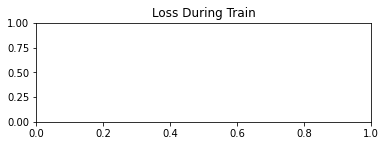

In [1]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss During Train')
pyplot.plot(history.history['loss'], label='total_loss')
pyplot.plot(history.history['output_loss'], label='output_1_loss')
pyplot.plot(history.history['output_1_loss'], label='output_2_loss')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy During Train')
pyplot.plot(history.history['output_output_output_output_output_output_output_output_output_output_output_output_output_output_accuracy'], label='output_1_accuracy')
pyplot.plot(history.history['output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_accuracy'], label='output_2_accuracy')
pyplot.legend()
pyplot.show()

In [ ]:
vectors = Vectors().load_vectors()


def processForModel(context, question, span):
        context = [context]
        question = [question]
        passage = [pas.strip() for pas in context]
        cont = []
        for pas in passage:
            context_tokens = pas.split(" ")
            cont.append(context_tokens)
        original_passage = [pas.lower() for pas in passage]
        quest = []
        for ques in question:
            question_tokens = ques.split(" ")
            quest.append(question_tokens)
        context_batch = vectors.query(cont)
        question_batch = vectors.query(quest)
        pad1 = np.zeros(shape=(1, 250 - len(cont[0]), 400))
        context_batch = np.concatenate((context_batch, pad1), 1)

        pad2 = np.zeros(shape=(1, 20 - len(quest[0]), 400))
        question_batch = np.concatenate((question_batch, pad2), 1)
        answer_span = span.split()
        output1 = np.zeros(shape=(1, 250), dtype=float)
        output2 = np.zeros(shape=(1, 250), dtype=float)
        output1[0][int(answer_span[0])] = 1
        output2[0][int(answer_span[1])] = 1
        # context_batch = tf.convert_to_tensor(context_batch, tf.float32)
        # question_batch = tf.convert_to_tensor(question_batch, tf.float32)
        # output1 = tf.convert_to_tensor(output1, tf.float32)
        # output2 = tf.convert_to_tensor(output2, tf.float32)

        return context_batch, question_batch, output1, output2


In [ ]:
bidef = BidirectionalAttentionFlow(400, 250, 20)
bidef.load_bidaf('drive/My Drive/app/bidaf250_15.h5')
context = "in four months , aonuma 's team managed to present realistic horseback riding , [ l ] which nintendo later revealed to the public with a trailer at electronic entertainment expo 2004 . the game was scheduled to be released the next year , and was no longer a follow-up to the wind waker ; a true sequel to it was released for the nintendo ds in 2007 , in the form of phantom hourglass . miyamoto explained in interviews that the graphical style was chosen to satisfy demand , and that it better fit the theme of an older incarnation of link . the game runs on a modified the wind waker engine ."
question = "where did nintendo preview the horseback riding feature ?"
context = 'from the beginning of 2014 , madonna began to make multiple media appearances . she appeared at the 56th annual grammy awards in january 2014 , performing " open your heart " alongside rappers macklemore & ryan lewis and singer mary lambert , who sang their single " same love " , as 33 couples were wed onstage , officiated by queen latifah . days later , she joined singer miley cyrus on her mtv unplugged special , singing a mash-up of " do n\'t tell me " and cyrus \' single " we ca n\'t stop " ( 2013 ) . she also extended her business ventures and in february 2014 the singer premiered mdna skin , a range of skin care products , in tokyo , japan . after visiting her hometown of detroit during may 2014 , madonna decided to contribute funds to three of the city \'s organizations , to help eliminate poverty from there . the singer released a statement saying that she was inspired by their work , adding that " it was obvious to me that i had to get involved and be part of the solution to help detroit recover " .'
question="which singer did she join on mtv unplugged to sing ?"
span = "70 71"
c, q, s1, s2 = processForModel(context, question, span)
p1, p2 = bidef.predict(c, q)

print(np.amax(p1, axis=1))
print(np.amax(p2, axis=1))

print(p1, p2)
print(s1, s2)


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
passage_input (InputLayer)      [(None, 250, 400)]   0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, 20, 400)]    0                                            
__________________________________________________________________________________________________
highway_layer (Highway)         multiple             320800      question_input[0][0]             
                                                                 passage_input[0][0]              
__________________________________________________________________________________________________
bidirectional_encoder (Bidirect multiple             2563200     highway_layer[0][0]        